In [ ]:

%tensorflow_version 1.x
import tensorflow as tf
print(tf.__version__)

TensorFlow 1.x selected.
1.15.2


In [ ]:
# import os
from google.colab import drive
import pickle 
import pandas as pd

drive.mount('/content/drive')

Mounted at /content/drive


In [ ]:
import os
from google.colab import drive
drive.mount('/content/drive')

# Import: imports
directory_path = "/content/drive/My\ Drive/Embodied_counting/src/"

file_name = "imports.py"
PATH = directory_path + file_name
%run -i $PATH



# Import: manage_results
directory_path = "/content/drive/My\ Drive/Embodied_counting/src/manage_results/"

file_name = "plot_hinton_diagrams.py"
PATH = directory_path + file_name
%run -i $PATH



CUDA_bool = False

Drive already mounted at /content/drive; to attempt to forcibly remount, call drive.mount("/content/drive", force_remount=True).
Import ...!
Libraries/Packages successfully imported...
Load Hinton-diagrams...!!


In [ ]:
### NOT NECESSARY TO RUN

!wget https://bin.equinox.io/c/4VmDzA7iaHb/ngrok-stable-linux-amd64.zip
!unzip ngrok-stable-linux-amd64.zip

LOG_DIR = './log'
get_ipython().system_raw(
    'tensorboard --logdir {} --host 0.0.0.0 --port 6006 &'
    .format(LOG_DIR)
)

get_ipython().system_raw('./ngrok http 6006 &')

! curl -s http://localhost:4040/api/tunnels | python3 -c \
    "import sys, json; print(json.load(sys.stdin)['tunnels'][0]['public_url'])"

--2020-09-16 07:53:29--  https://bin.equinox.io/c/4VmDzA7iaHb/ngrok-stable-linux-amd64.zip
Resolving bin.equinox.io (bin.equinox.io)... 54.84.72.55, 54.159.87.23, 54.198.148.204, ...
Connecting to bin.equinox.io (bin.equinox.io)|54.84.72.55|:443... connected.
HTTP request sent, awaiting response... 200 OK
Length: 13773305 (13M) [application/octet-stream]
Saving to: ‘ngrok-stable-linux-amd64.zip’

ngrok-stable-linux- 100%[===================>]  13.13M  6.08MB/s    in 2.2s    

2020-09-16 07:53:32 (6.08 MB/s) - ‘ngrok-stable-linux-amd64.zip’ saved [13773305/13773305]

Archive:  ngrok-stable-linux-amd64.zip
  inflating: ngrok                   
Traceback (most recent call last):
  File "<string>", line 1, in <module>
IndexError: list index out of range


In [ ]:
##################################
## Load data
##################################

import numpy as np
from copy import copy
from sklearn.model_selection import train_test_split
from google.colab import drive
import random
drive.mount('/content/drive')

X_ = np.load("/content/drive/My Drive/Number_Estimation/numerosity-estimation-master-data/data/train_test/imgs_train_test.npy")
y_ = np.load("/content/drive/My Drive/Number_Estimation/numerosity-estimation-master-data/data/train_test/labels_train_test.npy")
#those npy files should be in the folder data on gitlab/numerosity estimation project folder
# Split data in train/test sets
trX, teX, trY_labels, teY_labels = train_test_split(X_, y_, test_size=0.25, random_state=9, stratify=y_)

def one_hot(a, num_classes):
  b = copy(a)
  for i in range(a[:].size):
    b[i] = b[i] - 1 
  return np.squeeze(np.eye(num_classes)[b.reshape(-1)])

trY = one_hot(trY_labels,10)
teY = one_hot(teY_labels,10)

print (trX.shape, trY.shape, teX.shape, teY.shape)
print (trX.max(), trX.min(), teX.max(), teX.min())
print (trY_labels.max(), trY_labels.min(), teY_labels.max(), teY_labels.min())

img_size = int(np.sqrt(trX[0,:].size))
max_objects = 10





Drive already mounted at /content/drive; to attempt to forcibly remount, call drive.mount("/content/drive", force_remount=True).
(45000, 784) (45000, 10) (15000, 784) (15000, 10)
255 0 255 0
10 1 10 1


In [ ]:

import tensorflow as tf
#tf.reset_default_graph()
#from tensorflow.examples.tutorials.mnist import input_data
import numpy as np
import matplotlib
import matplotlib.pyplot as plt
import scipy.misc as smp
import os
from tensorflow.python import debug as tf_debug
#from fs.osfs import OSFS
import datetime
now = datetime.datetime.now()
#from tensorflow.contrib.tensorboard.plugins import projector

n_hidden_neurons = 90


tf.reset_default_graph()

################################
## AUXILIARY FUNCTIONS
################################
def array_to_image(data):
    img = smp.toimage(np.reshape(data, (img_size,img_size)))
    return  img

def init_weights(shape, name):
    return tf.Variable(tf.random_normal(shape, stddev=0.01), name=name)
  
def conv_to_tensorboard(conv_layer, conv_name, scope_name ):
    with tf.variable_scope(scope_name):
        kernel_str = conv_name + '/kernel'
        kernel = tf.get_collection(tf.GraphKeys.VARIABLES, kernel_str)[0]
         # scale weights to [0 1], type is still float
        x_min = tf.reduce_min(kernel)
        x_max = tf.reduce_max(kernel)
        kernel_0_to_1 = (kernel - x_min) / (x_max - x_min)
        # to tf.image_summary format [batch_size, height, width, channels]
        kernel_transposed = tf.transpose (kernel_0_to_1, [3, 0, 1, 2])
        #kernel_transposed = tf.reshape(tf.transpose (kernel_0_to_1, [3, 0, 1, 2]), [-1,3,3,1])
        #kernel_transposed = kernel_0_to_1
        # this will display random 3 filters from the 64 in conv1
        tf.summary.image('conv1_filters', kernel_transposed,max_outputs=32)
        #tf.summary.image('conv2_filters', kernel_transposed,max_outputs=64)
        
def layer_and_input_activ_to_tensorboard(layer, inputt, input_id, scope_name, img_w, img_h):
    with tf.name_scope("Sizes"):
      layer_shape = layer.get_shape().as_list()
      widthy = layer.get_shape().as_list()[1]
      whole_layer = layer
    imgy = tf.reshape(layer, [-1, img_w, img_h, 1])    
    imgy2 = tf.reshape(inputt, [-1, img_size, img_size, 1])
    input_str = 'Input_' + input_id
    layer_str = scope_name + '_of_' + input_str
    tf.summary.image(input_id, imgy)
    tf.summary.image(input_id, imgy2)

    
################################
## NN - Models
################################
# This network is the same as the previous one except with an extra hidden layer + dropout

def fully_connected_net(X, w_h, w_h2, w_o, p_keep_input, p_keep_hidden,is_trainy):
    # Add layer name scopes for better graph visualization
    with tf.name_scope("layer1"):
        X = tf.nn.dropout(X, p_keep_input)
        h = tf.nn.relu(tf.matmul(X, w_h))
    with tf.name_scope("layer2"):
        h = tf.nn.dropout(h, p_keep_hidden)
        h2 = tf.nn.relu(tf.matmul(h, w_h2))
    with tf.name_scope("layer3"):
        h2 = tf.nn.dropout(h2, p_keep_hidden)
        h3 = tf.nn.relu(tf.matmul(h2, w_h3))
    with tf.name_scope("layer4"):
        h3 = tf.nn.dropout(h3, p_keep_hidden)
        h4 = tf.nn.relu(tf.matmul(h3, w_h4))
    with tf.name_scope("layer5"):
        h4 = tf.nn.dropout(h4, p_keep_hidden)
        h5 = tf.nn.relu(tf.matmul(h4, w_h5))
    with tf.name_scope("layer5"):
        h5 = tf.nn.dropout(h5, p_keep_hidden)
        return tf.matmul(h5, w_o)



def conv_net(x_arr, n_classes, dropout, is_training, reuse):
    # data input might come as a 1-D vector of 784 features (28*28 pixels)
    # Reshape to match picture format [Height x Width x Channel]
    # Tensor input become 4-D: [Batch Size, Height, Width, Channel]
    x = tf.reshape(x_arr, shape=[-1, img_size, img_size, 1])

    # Convolution Layer with 32 filters and a kernel size of 5
    with tf.name_scope("conv1"):
      #kernel = _variable_with_weight_decay('weights', shape=[5, 5, 3, 64],
       #                                stddev=1e-4, wd=0.0)
      #conv = tf.nn.conv2d(images, kernel, [1, 1, 1, 1], padding='SAME')
      #conv1 = tf.layers.conv2d(x, 32, 5, activation=tf.nn.relu)
      conv1 = tf.layers.conv2d(inputs=x,filters=8,kernel_size=[5, 5],padding="same",activation=tf.nn.relu, name='conv1')
      #conv1 = tf.layers.conv2d(inputs=x,filters=8,kernel_size=[5, 5],padding="same",activation=tf.nn.relu, name='conv1')    #original
      # Max Pooling (down-sampling) with strides of 2 and kernel size of 2
      conv1 = tf.layers.max_pooling2d(conv1, 2, 2)

    # Convolution Layer with 64 filters and a kernel size of 3
    with tf.name_scope("conv2"):
      conv2 = tf.layers.conv2d(conv1, 64, 3, activation=tf.nn.relu, name='conv2')
      #conv2 = tf.layers.conv2d(conv1, 8, 3, activation=tf.nn.relu, name='conv2')  #original
      # Max Pooling (down-sampling) with strides of 2 and kernel size of 2
      conv2 = tf.layers.max_pooling2d(conv2, 2, 2)

    # Flatten the data to a 1-D vector for the fully connected layer
    conv2_flatten = tf.contrib.layers.flatten(conv2)
    # Fully connected layer (in tf contrib folder for now)
    fc1 = tf.layers.dense(conv2_flatten, n_hidden_neurons)   #original 1024
    # Apply Dropout (if is_training is False, dropout is not applied)
    fc1 = tf.layers.dropout(fc1, rate=dropout, training=is_training)
    fc1 = tf.sigmoid(fc1)
    

    #new_test_layer = tf.math.multiply(tf_test_layer_stacked, tf_filty_stacked)
    fc1 = tf.math.multiply(fc1, filtery)
    
    
    # Output layer, class prediction
    out = tf.nn.softmax(tf.layers.dense(fc1, n_classes))
    
    ######################
    #### PLOT LAYERS IN TENSORBOARD
    ######################
    conv_to_tensorboard(conv1, 'conv1', 'Conv1_Kernel_visualization' ) 
    #conv_to_tensorboard(conv2, 'conv2', 'Conv2_Kernel_visualization' ) 
    
    layer_shape = fc1[0].get_shape()
    widthy = fc1.get_shape().as_list()[1]
    whole_layer = fc1
    
    '''
    with tf.variable_scope('Last_layer_activation'):
      for obj in range(5):   
        layer_and_input_activ_to_tensorboard(fc1[obj:obj+1], x[obj:obj+1], str(obj), 'Last_layer_activation',3,3)
    '''
       
    with tf.variable_scope('conv1'):
      for obj in range(5):   
        layer_and_input_activ_to_tensorboard(conv1[obj:obj+1], x[obj:obj+1], str(obj), 'conv1_activation',img_size,img_size)  
    
      

       
    return out, fc1

  

################################
## LOAD DATA
################################

#mnist = input_data.read_data_sets("MNIST_data/", one_hot=True)
#trX, trY, teX, teY = mnist.train.images, mnist.train.labels, mnist.test.images, mnist.test.labels

## If you have uploaded files above:
#trX = np.load('trX.npy')
#trY = np.load('trY.npy')
#teX = np.load('teX.npy')
#teY = np.load('teY.npy')

# If you have created the files within this notebook:
#trX = mult_img
#trY = mult_class
#teX = mult_img_T
#teY = mult_class_T

#print(trX.shape)
#print(trY.shape)
#print(teX.shape)
#print(teY.shape)





  
  
  



In [ ]:
##########################################
## CREATE QUANTITIES/PLACEHOLDERS and SET THEM INTO NN
#########################################

#Step 2 - Create input and output placeholders for data
X = tf.placeholder("float", [None, trX[0,:].size], name="X")
Y = tf.placeholder("float", [None, trY[0,:].size], name="Y")

filtery = tf.placeholder("float", [None, n_hidden_neurons], name="Y")

is_training = tf.placeholder(tf.bool)
failed_object = tf.placeholder(tf.int32, name="FAILY")
failed_object_string = tf.placeholder(dtype=tf.string)

#Step 3 - Initialize weights


#Step 5 - Add dropout to input and hidden layers
p_keep_input = tf.placeholder("float", name="p_keep_input")
p_keep_hidden = tf.placeholder("float", name="p_keep_hidden")



#Step 6 - Create Model
#py_x = fully_connected_net(X, w_h, w_h2, w_o, p_keep_input, p_keep_hidden)
py_x, fc1 = conv_net(X, trY[0,:].size, 0.25, is_training, reuse=False)




##########################################
## COST + TRAIN_STEP
#########################################
#Step 7 Create cost function
with tf.name_scope("cost"):
    cost = tf.reduce_mean(tf.nn.softmax_cross_entropy_with_logits(logits=py_x,labels= Y))
    train_op = tf.train.RMSPropOptimizer(0.0005, 0.7).minimize(cost)
    # Add scalar summary for cost tensor
    tf.summary.scalar("cost", cost)

#Step 8 Measure accuracy
with tf.name_scope("accuracy"):
    correct_pred = tf.equal(tf.argmax(Y, 1), tf.argmax(py_x, 1)) # Count correct predictions
    acc_op = tf.reduce_mean(tf.cast(correct_pred, "float")) # Cast boolean to float to average
    # Add scalar summary for accuracy tensor
    tf.summary.scalar("accuracy", acc_op)
   
  
  
##########################################
## PLOT INCORRECT PREDICTIONS
#########################################
with tf.variable_scope('Failed_test_examples'):
  incorrect_pred = tf.not_equal(tf.argmax(Y, 1), tf.argmax(py_x, 1))
  indices = tf.where(incorrect_pred)
  x_arr = tf.reshape(X, shape=[-1, img_size, img_size, 1])
  x_arr_reduced = tf.gather_nd(x_arr, indices)
  imgy2 = tf.reshape(x_arr_reduced, [-1, img_size, img_size, 1])  
  to_tensi = tf.summary.image('Test', imgy2 ,max_outputs=20)


def save_and_plot_acc_cost(file_path, x_values, y_values, y_axis, x_axis='Episodes', y_values_2=None):

    matplotlib.get_backend()
    plt.plot(x_values, y_values, label='Test set')
    if(y_values_2 is not None):
       plt.plot(x_values, y_values_2, label='Train set')
       plt.legend()
    plt.ylabel(y_axis)
    plt.xlabel(x_axis)
    #plt.ylim(0,1)
    #titlestring = 'Accuracy development during learning to count up to ' + str(trY[0].size) + ' object with a CNN'
    titlestring = y_axis + ' development during learning to count up to ' + "10" + ' objects'

    img_path = file_path + "_" + y_axis + ".png"

    plt.title(titlestring)
    plt.savefig(img_path, dpi = 600)
    plt.show()

Instructions for updating:
Use `tf.keras.layers.Conv2D` instead.
Instructions for updating:
Please use `layer.__call__` method instead.
Instructions for updating:
Use keras.layers.MaxPooling2D instead.
The TensorFlow contrib module will not be included in TensorFlow 2.0.
For more information, please see:
  * https://github.com/tensorflow/community/blob/master/rfcs/20180907-contrib-sunset.md
  * https://github.com/tensorflow/addons
  * https://github.com/tensorflow/io (for I/O related ops)
If you depend on functionality not listed there, please file an issue.

Instructions for updating:
Use keras.layers.flatten instead.
Instructions for updating:
Use keras.layers.Dense instead.
Instructions for updating:
Use keras.layers.dropout instead.
Instructions for updating:
Use `tf.GraphKeys.GLOBAL_VARIABLES` instead.
Instructions for updating:

Future major versions of TensorFlow will allow gradients to flow
into the labels input on backprop by default.

See `tf.nn.softmax_cross_entropy_with_log

Instructions for updating:
Use `tf.global_variables_initializer` instead.
0 0.38826665
1 0.44066668


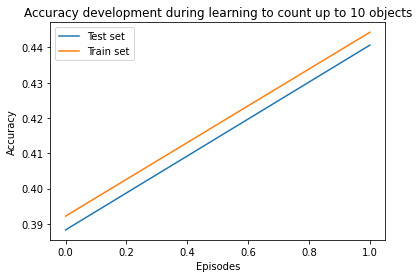

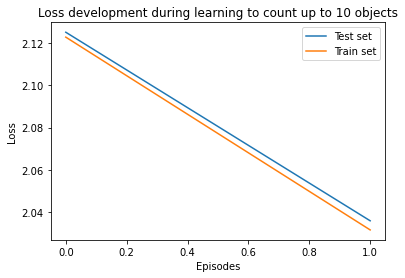

model_id=  7857
0.44066668


In [ ]:
    
###############
##########################################
## TRAIN MODEL
## SESSION / ACTUAL RUN - keyyyy
#########################################
###############


#Step 9 Create a session
test_acc_arr = []
test_cost_arr = []
train_acc_arr = []
train_cost_arr = []
episodes = []
n_episodes = 2

final_acc = np.zeros(10)

## Create 1000 test examples for each number

mult_images = []
mult_classes = []
test_acc = []

with tf.Session() as sess:
        #sess = tf_debug.TensorBoardDebugWrapperSession(sess, "localhost:6064")
        

        # Define directory name to log on.
        #fily = str(now.year) + '_' + str(now.month) + '_' + str(now.day) + '_' + str(now.hour) + 'h_' + str(now.minute)
        #fily = "simple"
        fily = './log' #+ fily
        #test_writer = tf.train.SummaryWriter(this_test)
        writer = tf.summary.FileWriter(fily, sess.graph) # for 0.8
        merged = tf.summary.merge_all()

        # Step 11 you need to initialize all variables
        tf.initialize_all_variables().run()
        #file_name = os.path.join(dirname, 'logs/events.out.tfevents.1539591730.NTNU15406')
        #save_model_path = '/content/drive/My Drive/Tensorflow_NumEst/saved_models/simple_model'
        result_path = "/content/drive/My Drive/Number_Estimation/Results/"
        model_id = str(random.randint(1000,10000))
        directory_name = str(model_id) + "/"
        file_name = "nn_model_" + str(model_id)
        directory_path = result_path + directory_name
        file_path = directory_path + file_name
        save_model_path = file_path

        if(not os.path.exists(directory_path) ):
              os.mkdir(directory_path)

        saver = tf.train.Saver()
        #saver.restore(sess, tf.train.latest_checkpoint(file_name))      ## if you want to get e.g. weights from a last session you can do it here!!!!!!!!
        

        
        
        #Step 12 train the  model
        for i in range(n_episodes):
            #if(i==0):
                #saver.restore(sess, './logs/Last_model')
            n_batch = 80
            batch_bool = 0
            tf_filty_stacked_2 = np.ones((128,n_hidden_neurons))
            if(batch_bool==0):
                for start, end in zip(range(0, len(trX), 128), range(128, len(trX)+1, 128)):
                    sess.run(train_op,                    feed_dict={X: trX[start:end].astype(np.float32), Y: trY[start:end].astype(np.float32),p_keep_input: 0.8, p_keep_hidden: 0.5, is_training: True, filtery:tf_filty_stacked_2})
            else:
                for b in range(int(trX[0,:].size/n_batch)):
                    batch_xs = trX[b*n_batch:b*n_batch+n_batch]
                    batch_ys = trY[b*n_batch:b*n_batch+n_batch]
                    sess.run(train_op, feed_dict={X: batch_xs, Y: batch_ys, p_keep_input: 0.8, p_keep_hidden: 0.5,is_training: True})
                    
            tf_filty_stacked_2 = np.ones((int(teX[:,0].size),n_hidden_neurons))
            indi, summary, test_acc, test_cost = sess.run([indices, merged, acc_op, cost], feed_dict={X: teX.astype(np.float32), Y: teY.astype(np.float32),p_keep_input: 1.0, p_keep_hidden: 1.0,is_training: False, failed_object: 0,failed_object_string: "0", filtery:tf_filty_stacked_2})
            tf_filty_stacked_2 = np.ones((int(trX[:,0].size),n_hidden_neurons))
            train_acc, train_cost = sess.run([acc_op, cost], feed_dict={X: trX.astype(np.float32), Y: trY.astype(np.float32),p_keep_input: 1.0, p_keep_hidden: 1.0,is_training: False, failed_object: 0,failed_object_string: "0", filtery:tf_filty_stacked_2})

            
          
            writer.add_summary(summary, i)  # Write summary
            print(i, test_acc)                   # Report the accuracy

            ## Append accuracies, costs and episodes
            test_acc_arr = np.append(test_acc_arr,test_acc)
            test_cost_arr = np.append(test_cost_arr,test_cost)
            train_acc_arr = np.append(train_acc_arr,train_acc)
            train_cost_arr = np.append(train_cost_arr,train_cost)
            episodes = np.append(episodes, i)


        #### Check for accuracy for final model and each number 
        last_layer_activity = np.zeros( shape=(max_objects,100,n_hidden_neurons ) )
        saver.save(sess, save_model_path)    
        tf_filty_stacked_2 = np.ones((100,n_hidden_neurons))    
        ### Create 1000 test examples for each number of squares each
        #for i in range(max_objects):
        #    mult_img2, mult_class2,areas, orig_areas = Create_N_Images(100, only_one_number=True, n_squares=i+1) 
        #    mult_images.append(mult_img2)
        #    mult_classes.append(mult_class2)
            
        #    indi, summary, acc, last_layer_activity[i,:] = sess.run([indices, merged, acc_op, fc1], feed_dict={X: mult_img2.astype(np.float32), Y: mult_class2.astype(np.float32),filtery: tf_filty_stacked_2, p_keep_input: 1.0, p_keep_hidden: 1.0,is_training: False, failed_object: 0,failed_object_string: "0"})
        #    final_acc[i] = acc
        #test_acc.append(acc)

        ###### save and plot accuracies, costs, episodes and last layer activity
        # Accuracies and costs during training: for training and test set
        test_acc_path = file_path + "_test_accuracies"
        test_cost_path = file_path + "_test_cost"
        train_acc_path = file_path + "_train_accuracies"
        train_cost_path = file_path + "_train_cost"
        last_layer_act_path = file_path + "_last_layer_activity"
        final_acc_path = file_path + "_final_accuracy"

        np.save(test_acc_path, test_acc_arr)
        np.save(test_cost_path, test_cost_arr)
        np.save(train_acc_path, train_acc_arr)
        np.save(train_cost_path, train_cost_arr)
        np.save(last_layer_act_path, last_layer_activity)
        np.save(final_acc_path, final_acc)

        save_and_plot_acc_cost(file_path, episodes, test_acc_arr, 'Accuracy', x_axis='Episodes', y_values_2=train_acc_arr)
        save_and_plot_acc_cost(file_path, episodes, test_cost_arr, 'Loss', x_axis='Episodes', y_values_2=train_cost_arr)
        print("model_id= ", model_id)

     
    
print(test_acc)    



In [ ]:
## Get tuning data:

def get_last_layer_activity_for_each_number(model_id, teX, teY_labels, turn_off_neurons_list_=None,turn_on_neurons_list_=None, plotty=False, num_list=None ):

    with tf.Session() as sess:

        #sess = tf_debug.TensorBoardDebugWrapperSession(sess, "localhost:6064")
        restore_model_id = model_id
        save_model_path = '/content/drive/My Drive/Number_Estimation/Results/' + str(restore_model_id) + '/'
        saver = tf.train.Saver()
        saver.restore(sess, tf.train.latest_checkpoint(save_model_path))

        last_layer_activity_list = []
        #last_layer_activity = np.zeros( shape=(max_objects,90 ) )
                                         
        test_acc = []
        test_acc_2 = []
        index_list = []

        if(num_list is None):
          num_list = np.unique(teY_labels)

          
        ### Test single number seperately  
        for i in num_list:


            indis = np.where(teY_labels == i)
            index_list.append(list(indis)[0] )
            teX_sub = teX[indis]
            teY_sub_labels = teY_labels[indis]
            teY_sub = one_hot(teY_sub_labels, 10)
            last_layer_activity = np.zeros( shape=(teX_sub.shape[0],n_hidden_neurons ) )

            #print(teX_sub.shape)
            #print(teY_sub.shape)
            #print(one_hot(teY_labels, 10).shape)
            #print(last_layer_activity.shape)
            
            if(turn_off_neurons_list_ is None and turn_on_neurons_list_ is None):
              tf_filty_stacked_2 = np.ones((teX_sub.shape[0],n_hidden_neurons))
            else:
              if(turn_off_neurons_list_ is not None):
                tf_filty_stacked_2 = create_neuron_filter(teX_sub.shape[0],turn_off_neurons_list_)
              if(turn_on_neurons_list_ is not None):
                tf_filty_stacked_2 = create_neuron_filter_turn_on(teX_sub.shape[0],turn_on_neurons_list_)
            #print(tf_filty_stacked_2.shape)
            
                        
            indi, acc, last_layer_activity = sess.run([indices, acc_op, fc1], feed_dict={X: teX_sub.astype(np.float32), Y: teY_sub.astype(np.float32),filtery: tf_filty_stacked_2, p_keep_input: 1.0, p_keep_hidden: 1.0,is_training: False, failed_object: 0,failed_object_string: "0"})
            last_layer_activity_list.append(last_layer_activity)
            test_acc.append(acc)
            #print("Individual_accuracy", i, ": ", acc)

        last_layer_activity_array_mean = activity_list_to_mean_array(last_layer_activity_list)
        
        if(plotty):
          matplotlib.get_backend()
          plt.plot(np.arange(1,max_objects+1), test_acc)
          #plt.plot(np.arange(1,max_objects+1), test_acc_2, label='Network with missing neurons')
          #plt.legend([test_acc, test_acc_2], ['Full network', 'Network with missing neurons'])
          plt.ylabel('Accuracy')
          plt.xlabel('Number of Objects')
          plt.ylim(0,1.2)
          titlestring = 'Accuracy of counting up to' + str(teY_sub[0].size) + ' objects with a CNN'
          plt.title(titlestring)
          path_img = '/content/drive/My Drive/Number_Estimation/Tensorflow_NumEst/plots/comparison_turn_off_neurons'
          ##plt.plot([1,2,3], [1,1,1])
          plt.legend()
          #plt.savefig(path_img, dpi = 1000)
          plt.show()


        return last_layer_activity_array_mean, test_acc, last_layer_activity_list, index_list

def activity_list_to_mean_array(last_layer_activity_list):
    last_layer_activity_array = np.zeros((len(last_layer_activity_list), n_hidden_neurons) )

    for i in range( len(last_layer_activity_list) ):
      last_layer_activity_i = np.mean(last_layer_activity_list[i], axis=0)
      last_layer_activity_array[i, :] = last_layer_activity_i

    return last_layer_activity_array  


def create_neuron_filter(batch_size, listy_, n_neurons=n_hidden_neurons):
    filty = np.ones(n_neurons)
    listy = listy_
    filty[listy] = 0

    # Stacked filter
    filty_stacked = np.zeros((batch_size,n_neurons))
    for i in range(batch_size):
      filty_stacked[i,:] = filty

    return filty_stacked 


def create_neuron_filter_turn_on(batch_size, listy_, n_neurons=n_hidden_neurons):
    filty = np.zeros(n_neurons)
    listy = listy_
    filty[listy] = 1

    # Stacked filter
    filty_stacked = np.zeros((batch_size,n_neurons))
    for i in range(batch_size):
      filty_stacked[i,:] = filty

    return filty_stacked
   

In [ ]:
#########################################
## Get Responsible Neurons for each Number
##########################################

#last_layer_activity_array, test_acc = get_last_layer_activity_for_each_number(model_id, teX, teY_labels)

def plot_last_layer_activity(last_layer_activity_array, num_list=None):
    fig, ax = plt.subplots(9, 10, sharex='col', sharey='row', figsize=(15,15))

    if(num_list is None):
      num_list = range(last_layer_activity_array.shape[0])
    num_list_len = len(num_list)
    responsible_neurons_for_each_numerosity = [[] for _ in range(num_list_len)]
    #fig.tight_layout()

    neural_activity_incr = [0]*num_list_len
    neural_activity_decr = [0]*num_list_len

    first_active_incr_already = [False]*11
    first_active_decr_already = [False]*11

    # axes are in a two-dimensional array, indexed by [row, col]
    for i in range(n_hidden_neurons):
            title_string = 'N= ' + str(i)
            ax[int(i/10), i%10].set_title(title_string)
            #ax[int(i/10), i%10].plot(range(5), range(5) )
            ax[int(i/10), i%10].plot(num_list, last_layer_activity_array[:,i], 'o' )


            # Increasing tuning curves (decreasing cardinality)
            first_active = 10
            if(last_layer_activity_array[0,i]<0.1):
              was_active = False
              
              for k in range(1,last_layer_activity_array[:,i].size):
                  if(last_layer_activity_array[k,i] > 0.5 and was_active==False):
                      first_active = k+1
                      was_active = True
              if(first_active_incr_already[first_active]==False):
                neural_activity_incr[first_active-1] = last_layer_activity_array[:,i]
                first_active_incr_already[first_active]=True
            else:
              was_active = False

              for k in range(1,last_layer_activity_array[:,i].size):
                  if(last_layer_activity_array[k,i] < 0.5 and was_active==False):
                      first_active = k
                      was_active = True
              if(first_active_decr_already[first_active]==False):
                neural_activity_decr[first_active-1] = last_layer_activity_array[:,i]
                first_active_decr_already[first_active]=True
                print("Decreasing neuron: ", i)

            ax[int(i/10), i%10].text(4,0.5,str(first_active), color='red')

            responsible_neurons_for_each_numerosity[first_active-1].append(i)
            #ax[int(i/10), i%10].set_xticks(self, ticks, minor=False)

    for n in range(num_list_len):
      stringy = "Responsible units for N= " + str(n+1) + ": " + str(responsible_neurons_for_each_numerosity[n])
      print(stringy)
    plt.subplots_adjust()
    print("test_acc: ", test_acc)
    path_img = '/content/drive/My Drive/Number_Estimation/Tensorflow_NumEst/plots/last_layer_activity.svg'
    fig.savefig(path_img, format='svg')

    return responsible_neurons_for_each_numerosity, neural_activity_incr, neural_activity_decr

def plot_positive_accuracy(responsible_neurons_for_each_numerosity, model_id, teX, teY_labels):
    fig, ax = plt.subplots(1, max_objects, figsize=(40,3))

    test_acc_for_each_filtered_num = []

    for i in range(max_objects):
        n=i
        turn_on_neurons_list = responsible_neurons_for_each_numerosity[n]
        last_layer_activity_array_, test_acc, _, _ = get_last_layer_activity_for_each_number(model_id, teX, teY_labels, turn_on_neurons_list_ = turn_on_neurons_list, plotty=False)

        matplotlib.get_backend()
        ax[i].plot(np.arange(1,len(test_acc)+1), test_acc)
        ax[i].set_ylim(0.0, 1.1)

        test_acc_for_each_filtered_num.append(test_acc)

    return test_acc_for_each_filtered_num

def plot_accuracy_from_existing_test_acc(test_acc_for_each_filtered_num):
    fig, ax = plt.subplots(1, max_objects, figsize=(40,3))

    for i in range(len(test_acc_for_each_filtered_num)):

        test_acc = test_acc_for_each_filtered_num[i]
        matplotlib.get_backend()
        ax[i].plot(np.arange(1,len(test_acc)+1), test_acc)
        ax[i].set_ylim(0.0, 1.1)


def plot_negative_accuracy(responsible_neurons_for_each_numerosity, model_id, teX, teY_labels):
    fig, ax = plt.subplots(1, max_objects, figsize=(40,3))

    test_acc_for_each_filtered_num = []

    for i in range(max_objects):
        n=i
        turn_off_neurons_list = responsible_neurons_for_each_numerosity[n]
        last_layer_activity_array_, test_acc, _, _ = get_last_layer_activity_for_each_number(model_id, teX, teY_labels, turn_off_neurons_list_ = turn_off_neurons_list, plotty=False)

        matplotlib.get_backend()
        ax[i].plot(np.arange(1,max_objects+1), test_acc)
        ax[i].set_ylim(0.0, 1.1)
        ax[i].set_xticks(range(1,11))

        test_acc_for_each_filtered_num.append(test_acc)

    return test_acc_for_each_filtered_num


def plot_negative_accuracy_two_rows(responsible_neurons_for_each_numerosity, model_id, teX, teY_labels):
    fig, ax = plt.subplots(2, 5, sharex='col', sharey='row', figsize=(18,8))


    for i in range(10):
      turn_off_neurons_list = responsible_neurons_for_each_numerosity[i]
      last_layer_activity_array_, test_acc, _, _ = get_last_layer_activity_for_each_number(model_id, teX, teY_labels, turn_off_neurons_list_ = turn_off_neurons_list, plotty=False)
      ax[int(i/5), i%5].plot(np.arange(1,max_objects+1), test_acc)
      ax[int(i/5), i%5].set_ylim(0.0, 1.1)
      ax[int(i/5), i%5].set_xticks(range(1,11))  
      ax[int(i/5), i%5].set_xlabel('Number of Objects', fontsize=14)

      if(i%5==0):
        ax[int(i/5), i%5].set_ylabel('Accuracy', fontsize=14)
    fig.tight_layout()

    path_img = '/content/drive/My Drive/Number_Estimation/Tensorflow_NumEst/plots/decreasing_accuracy.svg'
    fig.savefig(path_img, format='svg')



def plot_positive_accuracy_two_rows(responsible_neurons_for_each_numerosity, model_id, teX, teY_labels):
    fig, ax = plt.subplots(2, 5, sharex='col', sharey='row', figsize=(18,8))


    for i in range(10):
      turn_on_neurons_list = responsible_neurons_for_each_numerosity[i]
      last_layer_activity_array_, test_acc, _, _ = get_last_layer_activity_for_each_number(model_id, teX, teY_labels, turn_on_neurons_list_ = turn_on_neurons_list, plotty=False)

      ax[int(i/5), i%5].plot(np.arange(1,max_objects+1), test_acc)
      ax[int(i/5), i%5].set_ylim(0.0, 1.1)
      ax[int(i/5), i%5].set_xticks(range(1,11))  
      ax[int(i/5), i%5].set_xlabel('Number of Objects', fontsize=14)

      if(i%5==0):
        ax[int(i/5), i%5].set_ylabel('Accuracy', fontsize=14)
    fig.tight_layout()

    path_img = '/content/drive/My Drive/Number_Estimation/Tensorflow_NumEst/plots/decreasing_accuracy.svg'
    fig.savefig(path_img, format='svg')


def get_neuron_responsibility(last_layer_activity_array, num_list=None):

    if(num_list is None):
      num_list = range(last_layer_activity_array.shape[0])
    num_list_len = len(num_list)
    n_hidden_neurons = 90
    responsible_neurons_for_each_numerosity = []
    #fig.tight_layout()



    # axes are in a two-dimensional array, indexed by [row, col]
    for i in range(n_hidden_neurons):
            title_string = 'N= ' + str(i)

            # Increasing tuning curves (decreasing cardinality)
            first_active = 10
            card_code = "" #later d for decreasing, i for increasing
            if(last_layer_activity_array[0,i]<0.1):
              was_active = False
              
              for k in range(1,last_layer_activity_array[:,i].size):
                  if(last_layer_activity_array[k,i] > 0.5 and was_active==False):
                      first_active = k+1
                      was_active = True
              card_code = "i"
            else:
              was_active = False

              for k in range(1,last_layer_activity_array[:,i].size):
                  if(last_layer_activity_array[k,i] < 0.5 and was_active==False):
                      first_active = k
                      was_active = True
              card_code = "d"

            stringy = str(first_active) + card_code
            responsible_neurons_for_each_numerosity.append(stringy)


    return responsible_neurons_for_each_numerosity


def get_resp_num_for_each_neuron(last_layer_activity_array, num_list=None):

    if(num_list is None):
      num_list = range(last_layer_activity_array.shape[0])
    num_list_len = len(num_list)
    n_hidden_neurons = 90
    num_resp_for_each_neuron = []
    #fig.tight_layout()



    # axes are in a two-dimensional array, indexed by [row, col]
    for i in range(n_hidden_neurons):
            title_string = 'N= ' + str(i)

            # Increasing tuning curves (decreasing cardinality)
            first_active = 10
            card_code = "" #later d for decreasing, i for increasing
            if(last_layer_activity_array[0,i]<0.1):
              was_active = False
              
              for k in range(1,last_layer_activity_array[:,i].size):
                  if(last_layer_activity_array[k,i] > 0.5 and was_active==False):
                      first_active = k+1
                      was_active = True
              card_code = "i"
            else:
              was_active = False

              for k in range(1,last_layer_activity_array[:,i].size):
                  if(last_layer_activity_array[k,i] < 0.5 and was_active==False):
                      first_active = k
                      was_active = True
              card_code = "d"

            #stringy = str(first_active) + card_code
            #responsible_neurons_for_each_numerosity.append(stringy)
            num_resp_for_each_neuron.append(first_active)


    return num_resp_for_each_neuron

def plot_last_layer_activity_ordered(last_layer_activity_array, num_list=None, index_list=None):
    fig, ax = plt.subplots(9, 10, sharex='col', sharey='row', figsize=(15,15))

    if(num_list is None):
      num_list = range(last_layer_activity_array.shape[0])
    num_list_len = len(num_list)
    responsible_neurons_for_each_numerosity = [[] for _ in range(num_list_len)]
    #fig.tight_layout()

    neural_activity_incr = [0]*num_list_len
    neural_activity_decr = [0]*num_list_len

    first_active_incr_already = [False]*11
    first_active_decr_already = [False]*11

    # axes are in a two-dimensional array, indexed by [row, col]
    j = 0
    for i in index_list:

            #ax[int(i/10), i%10].plot(range(5), range(5) )
            ax[int(j/10), j%10].plot(num_list, last_layer_activity_array[:,i], 'o' )


            # Increasing tuning curves (decreasing cardinality)
            first_active = 10
            if(last_layer_activity_array[0,i]<0.1):
              was_active = False
              
              for k in range(1,last_layer_activity_array[:,i].size):
                  if(last_layer_activity_array[k,i] > 0.5 and was_active==False):
                      first_active = k+1
                      was_active = True
              if(first_active_incr_already[first_active]==False):
                neural_activity_incr[first_active-1] = last_layer_activity_array[:,i]
                first_active_incr_already[first_active]=True
            else:
              was_active = False

              for k in range(1,last_layer_activity_array[:,i].size):
                  if(last_layer_activity_array[k,i] < 0.5 and was_active==False):
                      first_active = k
                      was_active = True
              if(first_active_decr_already[first_active]==False):
                neural_activity_decr[first_active-1] = last_layer_activity_array[:,i]
                first_active_decr_already[first_active]=True
                print("Decreasing neuron: ", i)

            #ax[int(j/10), j%10].text(4,0.5,str(first_active), color='red')
            title_string = 'N=' + str(j) + '        ' + 'c'+ str(first_active)
            ax[int(j/10), j%10].set_title(title_string)
            if(int(j/10)==8):
              ax[int(j/10), j%10].set_xticks([1,5,10])

            responsible_neurons_for_each_numerosity[first_active-1].append(i)
            j += 1
            #ax[int(i/10), i%10].set_xticks(self, ticks, minor=False)

    for n in range(num_list_len):
      stringy = "Responsible units for N= " + str(n+1) + ": " + str(responsible_neurons_for_each_numerosity[n])
      print(stringy)
    plt.subplots_adjust()
    plt.tight_layout()
    print("test_acc: ", test_acc)
    path_img = '/content/drive/My Drive/Number_Estimation/Tensorflow_NumEst/plots/last_layer_activity.svg'
    fig.savefig(path_img)

    return responsible_neurons_for_each_numerosity, neural_activity_incr, neural_activity_decr

def plot_last_layer_activity_areas_ordered(df_average, quantity, num_list=None, index_list=None, num_resp_for_each_neuron=None):
    fig, ax = plt.subplots(9, 10, sharex='col', sharey='row', figsize=(15,15))

    x_range = df_average['activity_'+str(0)][:].size
    num_resps = num_resp_for_each_neuron


    # axes are in a two-dimensional array, indexed by [row, col]
    j = 0
    for i in index_list:

            ax[int(j/10), j%10].plot(df_average[quantity].values, df_average['activity_'+str(i)], 'o' )
            

            #ax[int(j/10), j%10].text(4,0.5,str(first_active), color='red')
            
            title_string = 'N=' + str(j) + '        ' + 'c'+ str(num_resps[i])
            ax[int(j/10), j%10].set_title(title_string)
            if(int(j/10)==8):
              min_max = [min(df_average[quantity].values),max(df_average[quantity].values)]
              ax[int(j/10), j%10].set_xticks(min_max)


            j += 1
            #ax[int(i/10), i%10].set_xticks(self, ticks, minor=False)


    plt.subplots_adjust()
    plt.tight_layout()

    path_img = '/content/drive/My Drive/Number_Estimation/Tensorflow_NumEst/plots/Fig_S7_last_layer_activity_areas.svg'
    fig.savefig(path_img)






[10, 9, 5, 10, 7, 3, 1, 3, 1, 2, 8, 2, 3, 4, 4, 2, 2, 4, 6, 9, 6, 10, 3, 5, 5, 2, 3, 5, 10, 3, 10, 4, 1, 2, 1, 5, 1, 2, 6, 4, 5, 7, 1, 10, 3, 4, 4, 2, 8, 2, 1, 2, 5, 4, 10, 5, 4, 1, 3, 3, 4, 10, 3, 3, 6, 7, 10, 2, 6, 2, 7, 8, 1, 3, 6, 3, 5, 5, 10, 10, 10, 10, 3, 5, 7, 3, 10, 7, 8, 9]
[6, 8, 32, 34, 36, 42, 50, 57, 72, 9, 11, 25, 47, 51, 7, 29, 44, 58, 62, 73, 82, 85, 13, 14, 31, 45, 53, 60, 2, 35, 52, 55, 64, 74, 65, 70, 87, 10, 71, 88, 19, 89, 3, 43, 54, 61, 66, 15, 16, 33, 37, 49, 67, 69, 5, 12, 22, 26, 59, 63, 75, 17, 39, 46, 56, 23, 24, 27, 40, 76, 77, 83, 18, 20, 38, 68, 4, 41, 84, 48, 1, 0, 21, 28, 30, 78, 79, 80, 81, 86]


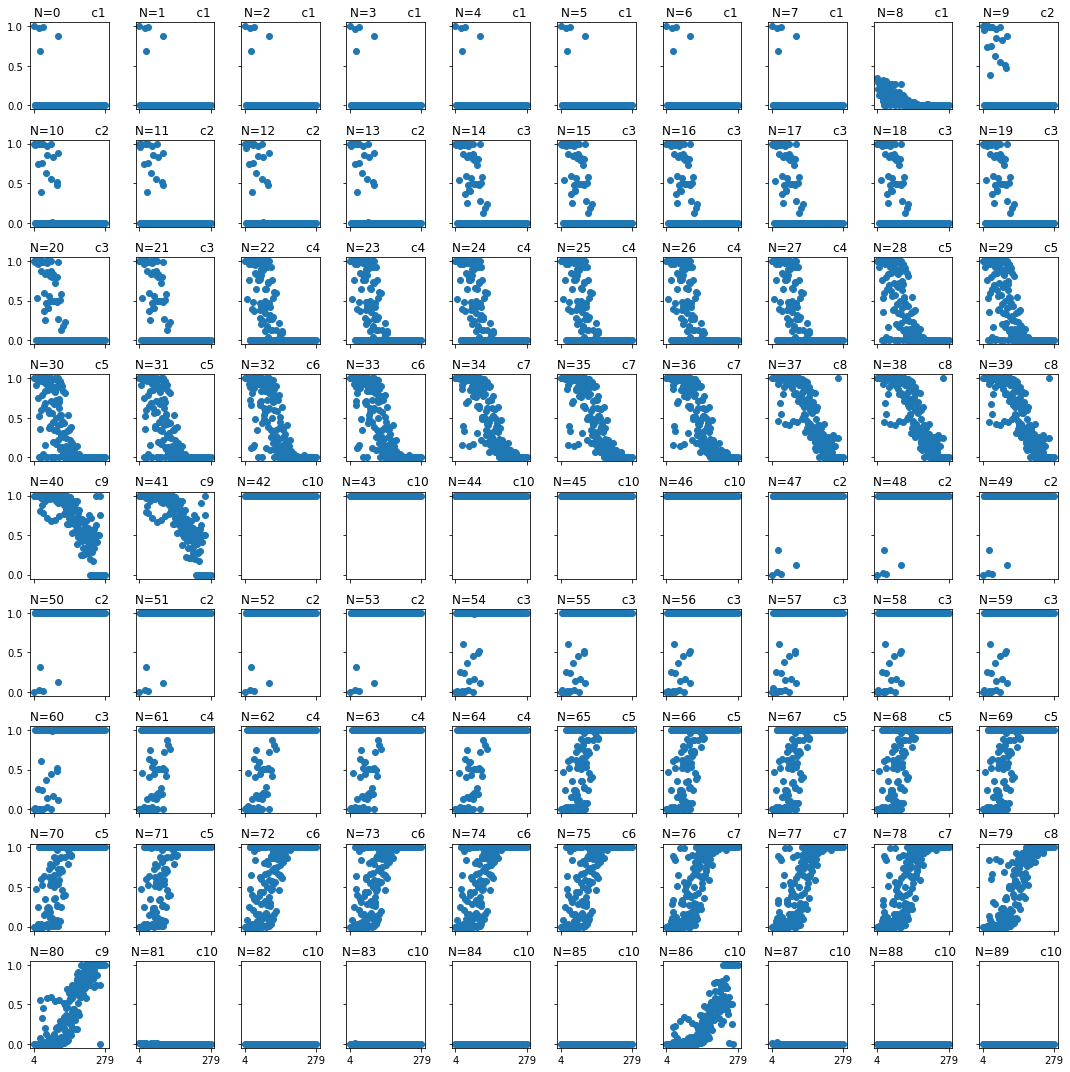

In [ ]:
##keyfct
num_resp_for_each_neuron = get_resp_num_for_each_neuron(last_layer_activity_array)
print(num_resp_for_each_neuron)
print(index_list)
quantity = 'area'
df_average = average_activity_over(df_extended, quantity)
plot_last_layer_activity_areas_ordered(df_average, quantity, num_list=None, index_list=index_list, num_resp_for_each_neuron=num_resp_for_each_neuron)

Decreasing neuron:  6
Decreasing neuron:  9
Decreasing neuron:  7
Decreasing neuron:  13
Decreasing neuron:  2
Decreasing neuron:  64
Decreasing neuron:  65
Decreasing neuron:  10
Decreasing neuron:  19
Decreasing neuron:  3
Responsible units for N= 1: [6, 8, 32, 34, 36, 42, 50, 57, 72]
Responsible units for N= 2: [9, 11, 25, 47, 51, 15, 16, 33, 37, 49, 67, 69]
Responsible units for N= 3: [7, 29, 44, 58, 62, 73, 82, 85, 5, 12, 22, 26, 59, 63, 75]
Responsible units for N= 4: [13, 14, 31, 45, 53, 60, 17, 39, 46, 56]
Responsible units for N= 5: [2, 35, 52, 55, 23, 24, 27, 40, 76, 77, 83]
Responsible units for N= 6: [64, 74, 18, 20, 38, 68]
Responsible units for N= 7: [65, 70, 87, 4, 41, 84]
Responsible units for N= 8: [10, 71, 88, 48]
Responsible units for N= 9: [19, 89, 1]
Responsible units for N= 10: [3, 43, 54, 61, 66, 0, 21, 28, 30, 78, 79, 80, 81, 86]
test_acc:  [1.0, 0.99990064, 0.9999, 0.99901175, 0.9983807, 0.9970417, 0.9975935, 0.9982116, 0.9974892, 0.99445283]


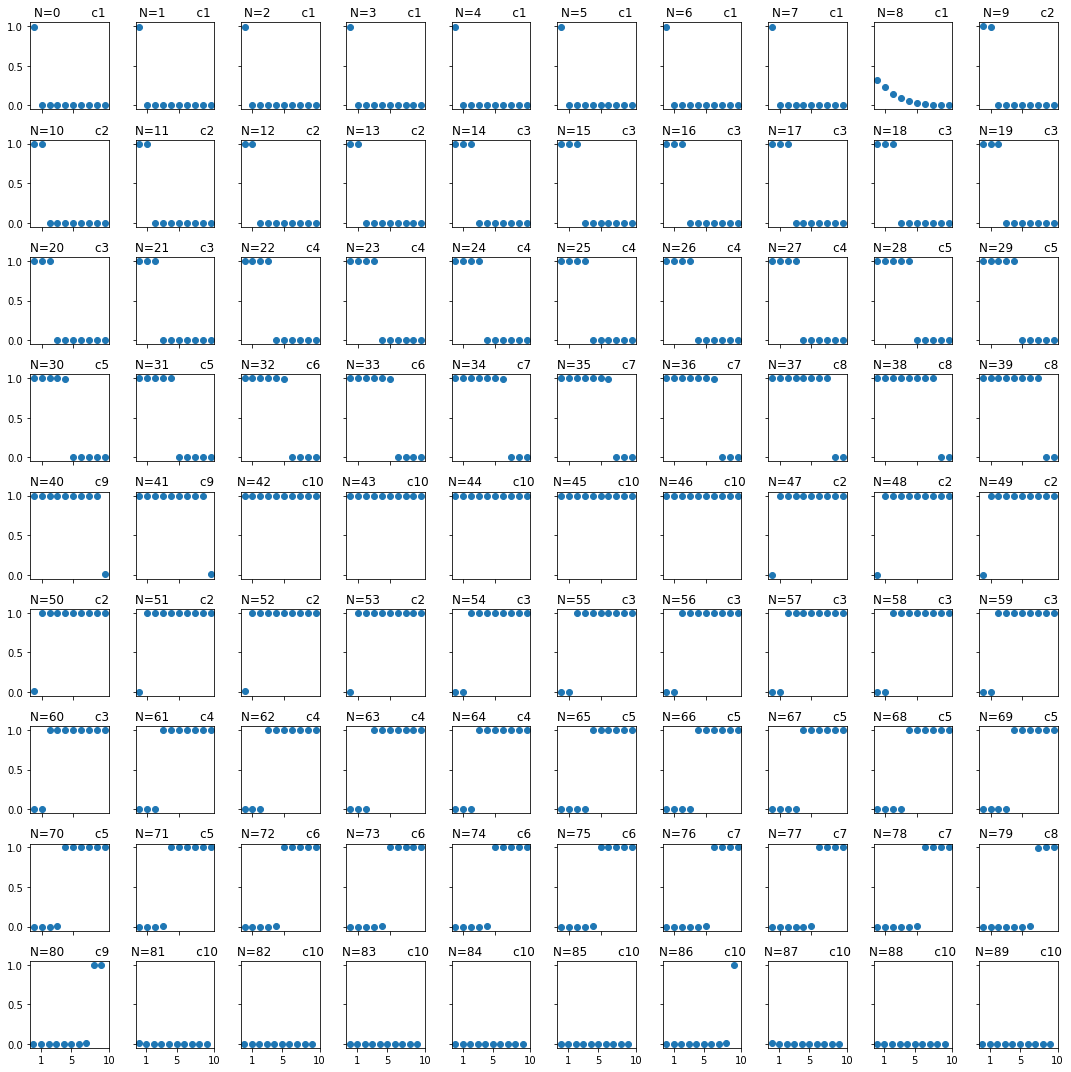

In [ ]:
responsible_neurons_for_each_numerosity, neural_activity_incr, neural_activity_decr = plot_last_layer_activity_ordered(last_layer_activity_array, index_list=index_list)

In [ ]:
#######
###########################
## Whole Dataset ANALYSIS
##########################
#######



model_id = 7214
model_id = 4348
model_id = 2282  # 90 hidden neurons, 200 epochs, responsible neurons for each number USED FOR PAPER
#model_id = 2038
#model_id = 1834  # 10 hidden neurons
#model_id = 1999 # 30 hidden neurons
#last_layer_activity_array = get_last_layer_activity_for_each_number(model_id, teX, teY_labels)
last_layer_activity_array, test_acc, last_layer_activity_list, _ = get_last_layer_activity_for_each_number(model_id, teX, teY_labels)

INFO:tensorflow:Restoring parameters from /content/drive/My Drive/Number_Estimation/Results/2282/nn_model_2282


In [ ]:
last_layer_activity_array, test_acc, last_layer_activity_list, index_list = get_last_layer_activity_for_each_number(model_id, teX, teY_labels)

INFO:tensorflow:Restoring parameters from /content/drive/My Drive/Number_Estimation/Results/2282/nn_model_2282


INFO:tensorflow:Restoring parameters from /content/drive/My Drive/Number_Estimation/Results/2282/nn_model_2282
INFO:tensorflow:Restoring parameters from /content/drive/My Drive/Number_Estimation/Results/2282/nn_model_2282
INFO:tensorflow:Restoring parameters from /content/drive/My Drive/Number_Estimation/Results/2282/nn_model_2282
INFO:tensorflow:Restoring parameters from /content/drive/My Drive/Number_Estimation/Results/2282/nn_model_2282
INFO:tensorflow:Restoring parameters from /content/drive/My Drive/Number_Estimation/Results/2282/nn_model_2282
INFO:tensorflow:Restoring parameters from /content/drive/My Drive/Number_Estimation/Results/2282/nn_model_2282
INFO:tensorflow:Restoring parameters from /content/drive/My Drive/Number_Estimation/Results/2282/nn_model_2282
INFO:tensorflow:Restoring parameters from /content/drive/My Drive/Number_Estimation/Results/2282/nn_model_2282
INFO:tensorflow:Restoring parameters from /content/drive/My Drive/Number_Estimation/Results/2282/nn_model_2282
I

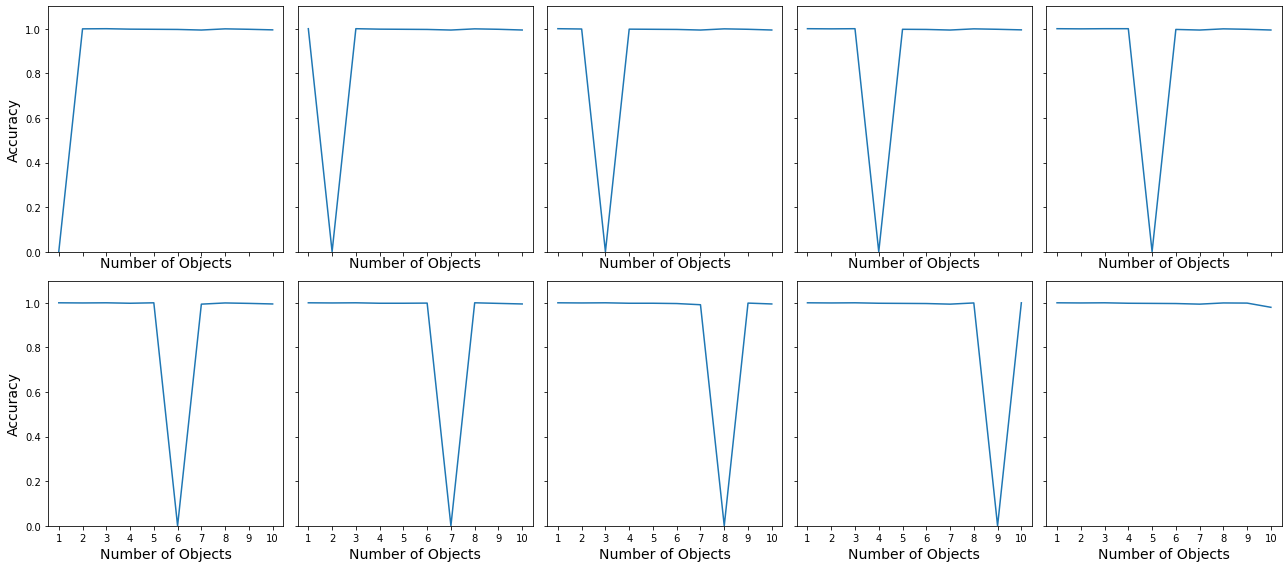

In [ ]:
plot_negative_accuracy_two_rows(responsible_neurons_for_each_numerosity, model_id, teX, teY_labels)

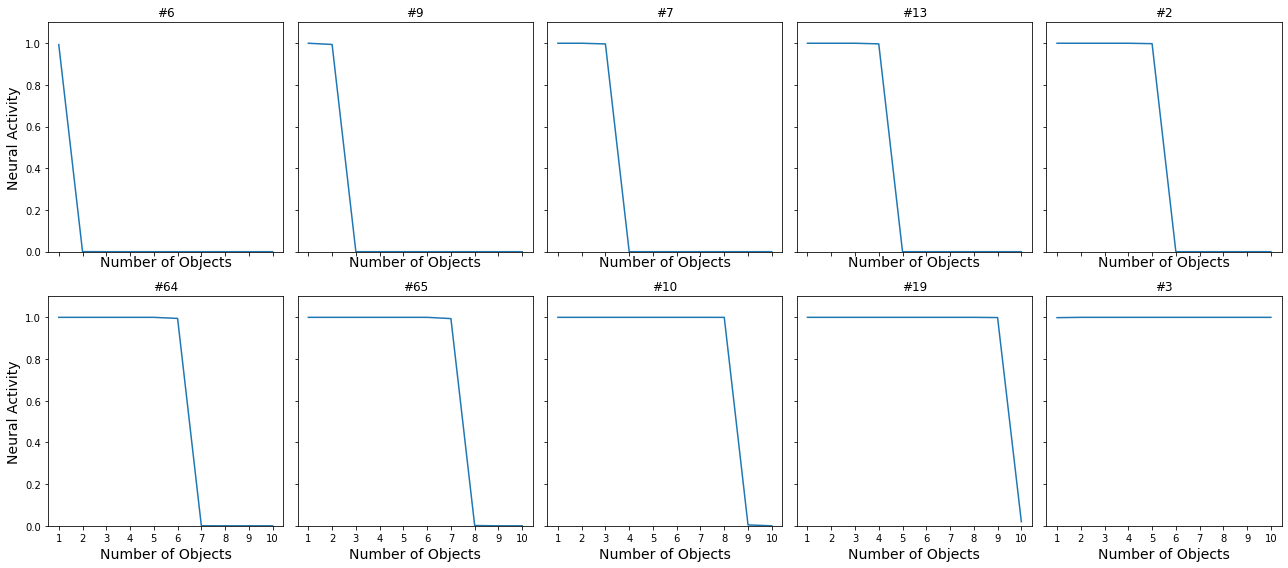

In [ ]:
neuron_list = [6,9, 7, 13, 2, 64, 65, 10, 19, 3]

fig, ax = plt.subplots(2, 5, sharex='col', sharey='row', figsize=(18,8))


for i in range(10):
  ax[int(i/5), i%5].plot(np.arange(1,11),neural_activity_decr[i])
  ax[int(i/5), i%5].set_ylim(0.0, 1.1)
  ax[int(i/5), i%5].set_xticks(range(1,11))  
  ax[int(i/5), i%5].set_xlabel('Number of Objects', fontsize=14)
  title_i = '#' + str(neuron_list[i])
  ax[int(i/5), i%5].set_title(title_i)

  if(i%5==0):
    ax[int(i/5), i%5].set_ylabel('Neural Activity', fontsize=14)
fig.tight_layout()

path_img = '/content/drive/My Drive/Number_Estimation/Tensorflow_NumEst/plots/1_to_10_decreasing_activity.svg'
fig.savefig(path_img,format='svg')


In [ ]:
neuron_list = [6,9, 7, 13, 2, 64, 65, 10, 19, 3]

fig, ax = plt.subplots(1, 5, sharex='col', sharey='row', figsize=(18,3))


for i in range(5):
  ax[i].plot(np.arange(1,11),neural_activity_decr[i])
  ax[i].set_ylim(0.0, 1.1)
  ax[i].set_xticks(range(1,11))  
  ax[i].set_xlabel('Number of Objects', fontsize=14)
  title_i = '#' + str(neuron_list[i])
  ax[i].set_title(title_i)

  if(i==0):
    ax[i].set_ylabel('Neural Activity', fontsize=14)

path_img = '/content/drive/My Drive/Number_Estimation/Tensorflow_NumEst/plots/1_to_5_decreasing_activity.svg'
fig.savefig(path_img,format='svg')

fig, ax = plt.subplots(1, 5, sharex='col', sharey='row', figsize=(18,3))
for i in range(5):
  j = 4+i+1
  ax[i].plot(np.arange(1,11),neural_activity_decr[j])
  ax[i].set_ylim(0.0, 1.1)
  ax[i].set_xticks(range(1,11))
  ax[i].set_xlabel('Number of Objects', fontsize=14)
  title_i = '#' + str(neuron_list[j])
  ax[i].set_title(title_i)

  if(i==0):
    ax[i].set_ylabel('Neural Activity', fontsize=14)
path_img = '/content/drive/My Drive/Number_Estimation/Tensorflow_NumEst/plots/6_to_10_decreasing_activity.svg'
fig.savefig(path_img,format='svg')

NameError: ignored

In [ ]:
resp_neuron_string = get_neuron_responsibility(last_layer_activity_array)
print(resp_neuron_string)

['10i', '9i', '5d', '10d', '7i', '3i', '1d', '3d', '1d', '2d', '8d', '2d', '3i', '4d', '4d', '2i', '2i', '4i', '6i', '9d', '6i', '10i', '3i', '5i', '5i', '2d', '3i', '5i', '10i', '3d', '10i', '4d', '1d', '2i', '1d', '5d', '1d', '2i', '6i', '4i', '5i', '7i', '1d', '10d', '3d', '4d', '4i', '2d', '8i', '2i', '1d', '2d', '5d', '4d', '10d', '5d', '4i', '1d', '3d', '3i', '4d', '10d', '3d', '3i', '6d', '7d', '10d', '2i', '6i', '2i', '7d', '8d', '1d', '3d', '6d', '3i', '5i', '5i', '10i', '10i', '10i', '10i', '3d', '5i', '7i', '3d', '10i', '7d', '8d', '9d']


In [ ]:

print(one_to_ten_string)


['1', '2', '3', '4', '5', '6', '7', '8', '9', '10']


In [ ]:
def hinton(matrix,axis=None, figy=None, input_nodes=None,input_node_description="",output_nodes=None,output_names=None, max_weight=None, ax=None, weight_encoding='size', graphy=None, input_node_names=None):
    """Draw Hinton diagram for visualizing a weight matrix."""
    #ax = ax if ax is not None else plt.gca()
    
    
    
    scale_fig=1.0
    fig_sizy=(matrix.shape[0]*scale_fig,matrix.shape[1]*scale_fig)
    fig, ax = plt.subplots(figsize=fig_sizy)
    
    if(figy is not None and axis is not None):
        fig = figy
        ax = axis
    
    if not max_weight:
        max_weight = 2 ** np.ceil(np.log(np.abs(matrix).max()) / np.log(2))

    ax.patch.set_facecolor('gray') #gray
    ax.set_aspect('equal', 'box')
    ax.xaxis.set_major_locator(plt.NullLocator())
    ax.yaxis.set_major_locator(plt.NullLocator())

    ## Extend patch to left
    text_dist = 1
    text_rect = plt.Rectangle([-7, 0], 1, 0.1, facecolor='gray', edgecolor='gray')
    ax.add_patch(text_rect)

    
    if(output_nodes is not None):
        dist_to_weights = 3
        for y in range(output_nodes.size):
            max_ampl=2 ** np.ceil(np.log(np.abs(output_nodes).max()) / np.log(2))
            color, size = get_rect_size_and_color(amplitude=output_nodes[y],max_amplitude=max_ampl,amplitude_encoding=weight_encoding, fixed_size=1)
            rect = plt.Rectangle([-dist_to_weights - size / 2, y - size / 2], size, size,
                             facecolor=color, edgecolor=color)
            ax.add_patch(rect)
            if(len(str(output_names[y]))>5):
                extra_distance = 1.4
            else:
                extra_distance = 0
    if(output_names is not None):
        dist_to_weights = 3
        extra_distance = -3
        for y in range(len(output_names)):
          ax.text(-dist_to_weights-len(str(output_names[y]))/4-1.2-extra_distance, y+0.3, str(output_names[y]), fontsize=24)
            
    if(input_nodes is not None):
        dist_to_weights = 3
        for x in range(input_nodes.size):
            max_ampl=2 ** np.ceil(np.log(np.abs(input_nodes).max()) / np.log(2))
            color, size = get_rect_size_and_color(amplitude=input_nodes[x],max_amplitude=max_ampl,amplitude_encoding=weight_encoding, fixed_size=1)
            size *= 0.0001
            rect = plt.Rectangle([x - size / 2, -dist_to_weights-size/2], size, size,
                             facecolor=color, edgecolor=color)
            ax.add_patch(rect)

    
    if(input_node_names is not None):
      
      dist_to_weights = 3
      for x in range(len(input_node_names)):
        x_shift = (3-len(input_node_names[x]))/10
        ax.text(x - 1 / 2+x_shift, -dist_to_weights-0.5+2.8, str(input_node_names[x]),fontsize=24)

    for (x, y), w in np.ndenumerate(matrix):

        color, size = get_rect_size_and_color(amplitude=w,max_amplitude=max_weight,amplitude_encoding=weight_encoding, fixed_size=1)    
        rect = plt.Rectangle([x - size / 2, y - size / 2], size, size,
                             facecolor=color, edgecolor=color)
        ax.add_patch(rect)
        
    # Add "W" description
    text_dist = 1
    text_rect = plt.Rectangle([matrix.shape[0]/2-2, matrix.shape[1]+text_dist], 1, 0.1, facecolor='gray', edgecolor='gray')
    ax.add_patch(text_rect)
    ax.text(matrix.shape[0]/2-2, matrix.shape[1]+text_dist, "W", fontsize=18)
    
    # Add representation description
    text_dist = 1
    dist_to_weights = 1
    text_rect = plt.Rectangle([matrix.shape[0]/2-2, -text_dist-dist_to_weights-size-2], 1, 0.1, facecolor='gray', edgecolor='gray')
    ax.add_patch(text_rect)
    ax.text(matrix.shape[0]/2-7.0, -text_dist-dist_to_weights-size, input_node_description, fontsize=18)
        
    ax.autoscale_view()
    ax.invert_yaxis()
    #scale_fig=6
    #ax.fig_size=(x*scale_fig,y*scale_fig)
    
    return fig


In [ ]:
[2,3,233,2].index(2)

0

In [ ]:
## keyweights
def get_weight_matrix(model_id ):

    weights = None
    with tf.Session() as sess:

        restore_model_id = model_id
        save_model_path = '/content/drive/My Drive/Number_Estimation/Results/' + str(restore_model_id) + '/'
        saver = tf.train.Saver()
        saver.restore(sess, tf.train.latest_checkpoint(save_model_path))

        graph = tf.get_default_graph()

        #for i, var in enumerate(saver._var_list):
        #    print('Var {}: {}'.format(i, var))

        weights = tf.get_default_graph().get_tensor_by_name('dense_1/kernel:0').eval()
        bias = tf.get_default_graph().get_tensor_by_name('dense_1/bias:0').eval()

    return weights, bias
    
weights, bias = get_weight_matrix(2282)  

INFO:tensorflow:Restoring parameters from /content/drive/My Drive/Number_Estimation/Results/2282/nn_model_2282


In [ ]:

resp_neuron_string = get_neuron_responsibility(last_layer_activity_array)
print(resp_neuron_string)
index_list = []
for n in range(1,11):
  ni = str(n)+'i'

  if(ni in resp_neuron_string):
    index_sub_list = [i for i, value in enumerate(resp_neuron_string) if value == ni] 
    for i in index_sub_list:
      index_list.append(i)

  nd = str(n)+'d'
  if(nd in resp_neuron_string):
    index_sub_list = [i for i, value in enumerate(resp_neuron_string) if value == nd] 
    for i in index_sub_list:
      index_list.append(i)

print(index_list)

['10i', '9i', '5d', '10d', '7i', '3i', '1d', '3d', '1d', '2d', '8d', '2d', '3i', '4d', '4d', '2i', '2i', '4i', '6i', '9d', '6i', '10i', '3i', '5i', '5i', '2d', '3i', '5i', '10i', '3d', '10i', '4d', '1d', '2i', '1d', '5d', '1d', '2i', '6i', '4i', '5i', '7i', '1d', '10d', '3d', '4d', '4i', '2d', '8i', '2i', '1d', '2d', '5d', '4d', '10d', '5d', '4i', '1d', '3d', '3i', '4d', '10d', '3d', '3i', '6d', '7d', '10d', '2i', '6i', '2i', '7d', '8d', '1d', '3d', '6d', '3i', '5i', '5i', '10i', '10i', '10i', '10i', '3d', '5i', '7i', '3d', '10i', '7d', '8d', '9d']
[6, 8, 32, 34, 36, 42, 50, 57, 72, 15, 16, 33, 37, 49, 67, 69, 9, 11, 25, 47, 51, 5, 12, 22, 26, 59, 63, 75, 7, 29, 44, 58, 62, 73, 82, 85, 17, 39, 46, 56, 13, 14, 31, 45, 53, 60, 23, 24, 27, 40, 76, 77, 83, 2, 35, 52, 55, 18, 20, 38, 68, 64, 74, 4, 41, 84, 65, 70, 87, 48, 10, 71, 88, 1, 19, 89, 0, 21, 28, 30, 78, 79, 80, 81, 86, 3, 43, 54, 61, 66]


In [ ]:
a = np.arange(12).reshape(3,4)
print(a)
print(a[:,[3,2,1,0]])

index_from_respons = {}
index_from_respons['1d'] = [2]
index_from_respons['1i'] = [0]
index_from_respons['2d'] = [1,3]
index_from_respons['2i'] = []


print(resp_neuron_string)
index_list = []


for n in range(1,11):
  nd = str(n)+'d'
  if(nd in resp_neuron_string):
    index_sub_list = [i for i, value in enumerate(resp_neuron_string) if value == nd] 
    for i in index_sub_list:
      index_list.append(i)

for n in range(1,11):
  ni = str(n)+'i'

  if(ni in resp_neuron_string):
    index_sub_list = [i for i, value in enumerate(resp_neuron_string) if value == ni] 
    for i in index_sub_list:
      index_list.append(i)



print(index_list)

[[ 0  1  2  3]
 [ 4  5  6  7]
 [ 8  9 10 11]]
[[ 3  2  1  0]
 [ 7  6  5  4]
 [11 10  9  8]]
['10i', '9i', '5d', '10d', '7i', '3i', '1d', '3d', '1d', '2d', '8d', '2d', '3i', '4d', '4d', '2i', '2i', '4i', '6i', '9d', '6i', '10i', '3i', '5i', '5i', '2d', '3i', '5i', '10i', '3d', '10i', '4d', '1d', '2i', '1d', '5d', '1d', '2i', '6i', '4i', '5i', '7i', '1d', '10d', '3d', '4d', '4i', '2d', '8i', '2i', '1d', '2d', '5d', '4d', '10d', '5d', '4i', '1d', '3d', '3i', '4d', '10d', '3d', '3i', '6d', '7d', '10d', '2i', '6i', '2i', '7d', '8d', '1d', '3d', '6d', '3i', '5i', '5i', '10i', '10i', '10i', '10i', '3d', '5i', '7i', '3d', '10i', '7d', '8d', '9d']
[6, 8, 32, 34, 36, 42, 50, 57, 72, 9, 11, 25, 47, 51, 7, 29, 44, 58, 62, 73, 82, 85, 13, 14, 31, 45, 53, 60, 2, 35, 52, 55, 64, 74, 65, 70, 87, 10, 71, 88, 19, 89, 3, 43, 54, 61, 66, 15, 16, 33, 37, 49, 67, 69, 5, 12, 22, 26, 59, 63, 75, 17, 39, 46, 56, 23, 24, 27, 40, 76, 77, 83, 18, 20, 38, 68, 4, 41, 84, 48, 1, 0, 21, 28, 30, 78, 79, 80, 81, 86]


In [ ]:
indy =  [i for i, value in enumerate(resp_neuron_string) if value == '2i'][0] 
print(index_list)
print(index_list[indy])
#print(enumerate(resp_neuron_string))

[15, 16, 33, 37, 49, 67, 69, 5, 12, 22, 26, 59, 63, 75, 17, 39, 46, 56, 23, 24, 27, 40, 76, 77, 83, 18, 20, 38, 68, 4, 41, 84, 48, 1, 0, 21, 28, 30, 78, 79, 80, 81, 86, 6, 8, 32, 34, 36, 42, 50, 57, 72, 9, 11, 25, 47, 51, 7, 29, 44, 58, 62, 73, 82, 85, 13, 14, 31, 45, 53, 60, 2, 35, 52, 55, 64, 74, 65, 70, 87, 10, 71, 88, 19, 89, 3, 43, 54, 61, 66]
39


In [ ]:
#sorted weight_matrix
sorted_weights = weights[index_list,:]
#sorted input node descrpion: 
sorted_resp_neuron_string = [resp_neuron_string[i] for i in index_list]

#print(sorted_weights)
print(sorted_resp_neuron_string)

['1d', '1d', '1d', '1d', '1d', '1d', '1d', '1d', '1d', '2d', '2d', '2d', '2d', '2d', '3d', '3d', '3d', '3d', '3d', '3d', '3d', '3d', '4d', '4d', '4d', '4d', '4d', '4d', '5d', '5d', '5d', '5d', '6d', '6d', '7d', '7d', '7d', '8d', '8d', '8d', '9d', '9d', '10d', '10d', '10d', '10d', '10d', '2i', '2i', '2i', '2i', '2i', '2i', '2i', '3i', '3i', '3i', '3i', '3i', '3i', '3i', '4i', '4i', '4i', '4i', '5i', '5i', '5i', '5i', '5i', '5i', '5i', '6i', '6i', '6i', '6i', '7i', '7i', '7i', '8i', '9i', '10i', '10i', '10i', '10i', '10i', '10i', '10i', '10i', '10i']


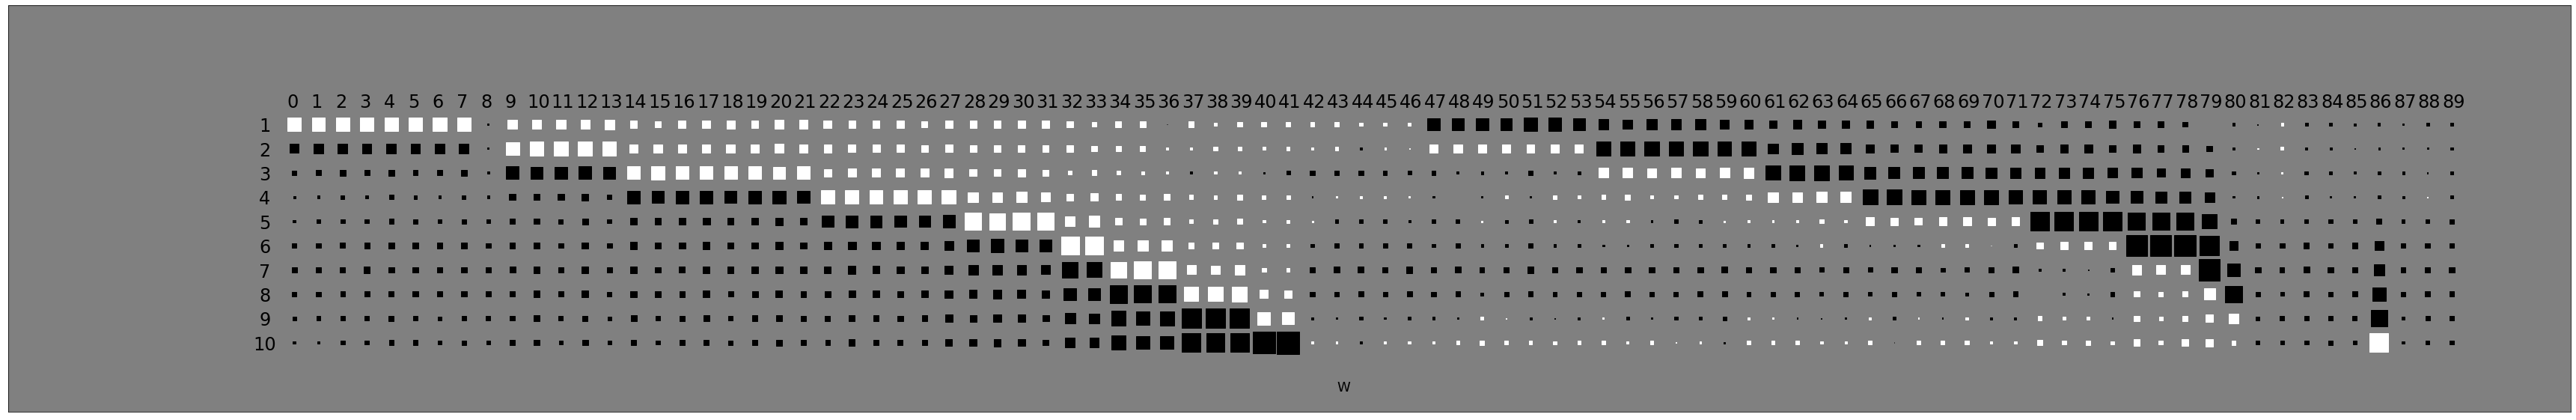

In [ ]:
# keyhinton

input_nodes = np.ones(90)
output_nodes = None #np.ones(10) #bias
weight_matrix = np.ones((20,10))
weight_matrix = sorted_weights
dist_to_weights = 2
one_to_ten_string = [str(i) for i in range(1,11)]
zero_to_ninty_string = [str(i) for i in range(0,90)]
figy = hinton(matrix=weight_matrix,axis=None, figy=None, input_nodes=None,input_node_names=zero_to_ninty_string,output_nodes=output_nodes,output_names=one_to_ten_string, max_weight=None, ax=None, weight_encoding='size', graphy=None)
#figy = hinton(matrix=bias,axis=None, figy=None, input_nodes=input_nodes,input_node_names=resp_neuron_string,output_nodes=output_nodes,output_names=one_to_ten_string, max_weight=None, ax=None, weight_encoding='size', graphy=None)
path_img = '/content/drive/My Drive/Number_Estimation/Tensorflow_NumEst/plots/hinton_diagram_sorted_2.png'
figy.savefig(path_img)

Decreasing neuron:  6
Decreasing neuron:  9
Decreasing neuron:  7
Decreasing neuron:  13
Decreasing neuron:  2
Decreasing neuron:  64
Decreasing neuron:  65
Decreasing neuron:  10
Decreasing neuron:  19
Decreasing neuron:  3
Responsible units for N= 1: [6, 8, 32, 34, 36, 42, 50, 57, 72]
Responsible units for N= 2: [9, 11, 25, 47, 51, 15, 16, 33, 37, 49, 67, 69]
Responsible units for N= 3: [7, 29, 44, 58, 62, 73, 82, 85, 5, 12, 22, 26, 59, 63, 75]
Responsible units for N= 4: [13, 14, 31, 45, 53, 60, 17, 39, 46, 56]
Responsible units for N= 5: [2, 35, 52, 55, 23, 24, 27, 40, 76, 77, 83]
Responsible units for N= 6: [64, 74, 18, 20, 38, 68]
Responsible units for N= 7: [65, 70, 87, 4, 41, 84]
Responsible units for N= 8: [10, 71, 88, 48]
Responsible units for N= 9: [19, 89, 1]
Responsible units for N= 10: [3, 43, 54, 61, 66, 0, 21, 28, 30, 78, 79, 80, 81, 86]
test_acc:  [1.0, 0.99932206, 1.0, 0.9979716, 0.99734396, 0.99667776, 0.993996, 0.9993311, 0.9973527, 0.9947849]


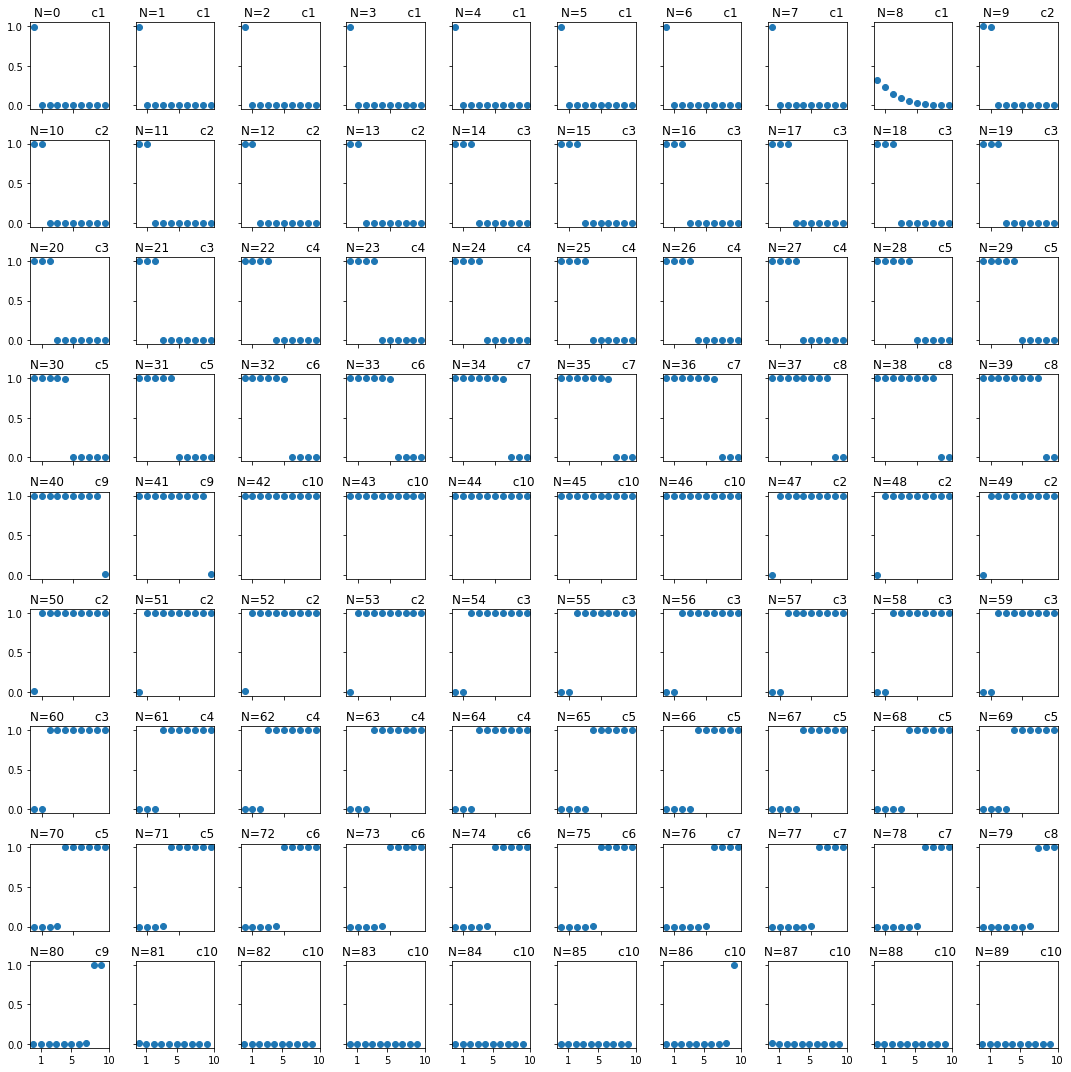

In [ ]:
#plot_last_layer_activity_ordered(last_layer_activity_array, num_list=None, index_list=None)
responsible_neurons_for_each_numerosity, neural_activity_incr, neural_activity_decr = plot_last_layer_activity_ordered(last_layer_activity_array, index_list=index_list)

Decreasing neuron:  2
Decreasing neuron:  3
Decreasing neuron:  6
Decreasing neuron:  7
Decreasing neuron:  9
Decreasing neuron:  10
Decreasing neuron:  13
Decreasing neuron:  19
Decreasing neuron:  64
Decreasing neuron:  65
Responsible units for N= 1: [6, 8, 32, 34, 36, 42, 50, 57, 72]
Responsible units for N= 2: [9, 11, 15, 16, 25, 33, 37, 47, 49, 51, 67, 69]
Responsible units for N= 3: [5, 7, 12, 22, 26, 29, 44, 58, 59, 62, 63, 73, 75, 82, 85]
Responsible units for N= 4: [13, 14, 17, 31, 39, 45, 46, 53, 56, 60]
Responsible units for N= 5: [2, 23, 24, 27, 35, 40, 52, 55, 76, 77, 83]
Responsible units for N= 6: [18, 20, 38, 64, 68, 74]
Responsible units for N= 7: [4, 41, 65, 70, 84, 87]
Responsible units for N= 8: [10, 48, 71, 88]
Responsible units for N= 9: [1, 19, 89]
Responsible units for N= 10: [0, 3, 21, 28, 30, 43, 54, 61, 66, 78, 79, 80, 81, 86]
test_acc:  [1.0, 0.99932206, 1.0, 0.9979716, 0.99734396, 0.99667776, 0.993996, 0.9993311, 0.9973527, 0.9947849]


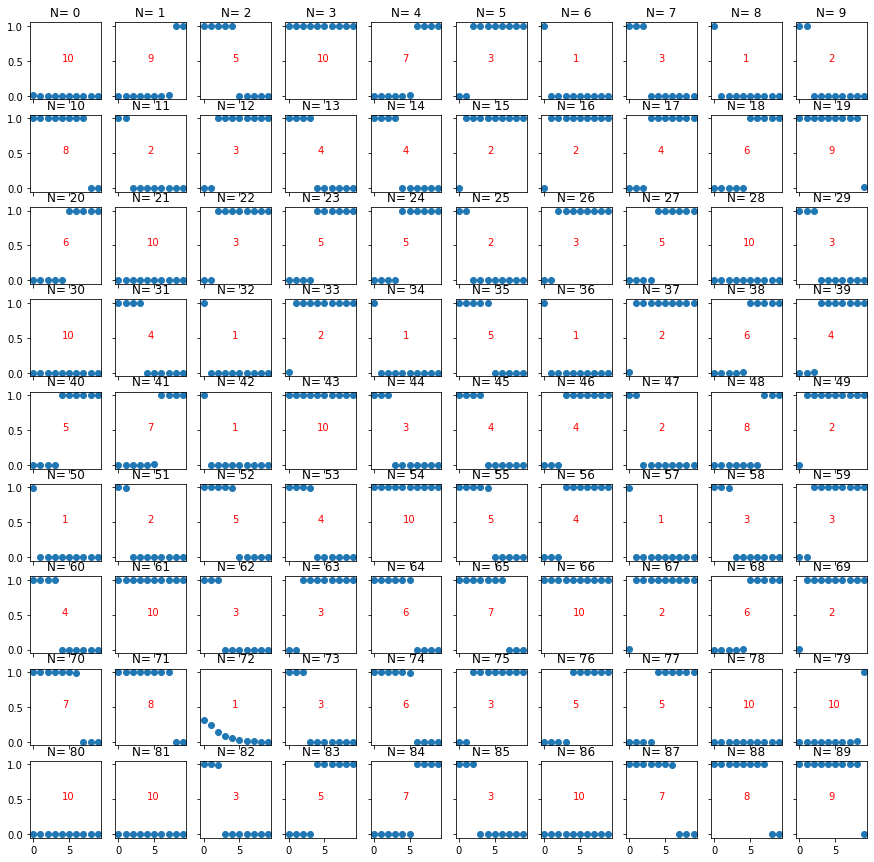

In [ ]:
responsible_neurons_for_each_numerosity, neural_activity_incr, neural_activity_decr = plot_last_layer_activity(last_layer_activity_array)

In [ ]:
# Create ronspinsble neurons: string list

print(responsible_neurons_for_each_numerosity)
print(neural_activity_incr)


[[6, 8, 32, 34, 36, 42, 50, 57, 72], [9, 11, 15, 16, 25, 33, 37, 47, 49, 51, 67, 69], [5, 7, 12, 22, 26, 29, 44, 58, 59, 62, 63, 73, 75, 82, 85], [13, 14, 17, 31, 39, 45, 46, 53, 56, 60], [2, 23, 24, 27, 35, 40, 52, 55, 76, 77, 83], [18, 20, 38, 64, 68, 74], [4, 41, 65, 70, 84, 87], [10, 48, 71, 88], [1, 19, 89], [0, 3, 21, 28, 30, 43, 54, 61, 66, 78, 79, 80, 81, 86]]
[0, array([0.00675636, 0.99956119, 1.        , 1.        , 1.        ,
       1.        , 1.        , 1.        , 1.        , 1.        ]), array([0.        , 0.00116241, 0.9994356 , 1.        , 1.        ,
       1.        , 1.        , 1.        , 1.        , 1.        ]), array([0.00000000e+00, 0.00000000e+00, 9.26510780e-04, 9.99866962e-01,
       1.00000000e+00, 1.00000000e+00, 1.00000000e+00, 1.00000000e+00,
       1.00000000e+00, 1.00000000e+00]), array([0.        , 0.        , 0.        , 0.00289701, 0.99998778,
       1.        , 1.        , 1.        , 1.        , 1.        ]), array([0.        , 0.        , 0. 

Responsible units for N= 1: [0, 3, 6, 8, 21, 28, 30, 32, 34, 36, 42, 43, 50, 54, 57, 61, 66, 72, 78, 80, 81, 86]
Responsible units for N= 2: [9, 11, 15, 16, 25, 33, 37, 47, 49, 51, 67, 69]
Responsible units for N= 3: [5, 7, 12, 22, 26, 29, 44, 58, 59, 62, 63, 73, 75, 82, 85]
Responsible units for N= 4: [13, 14, 17, 31, 39, 45, 46, 53, 56, 60]
Responsible units for N= 5: [2, 23, 24, 27, 35, 40, 52, 55, 76, 77, 83]
Responsible units for N= 6: [18, 20, 38, 64, 68, 74]
Responsible units for N= 7: [4, 41, 65, 70, 84, 87]
Responsible units for N= 8: [10, 48, 71, 88]
Responsible units for N= 9: [1, 19, 89]
Responsible units for N= 10: [79]
test_acc:  [1.0, 0.99932206, 1.0, 0.9979716, 0.99734396, 0.99667776, 0.993996, 0.9993311, 0.9973527, 0.9947849]


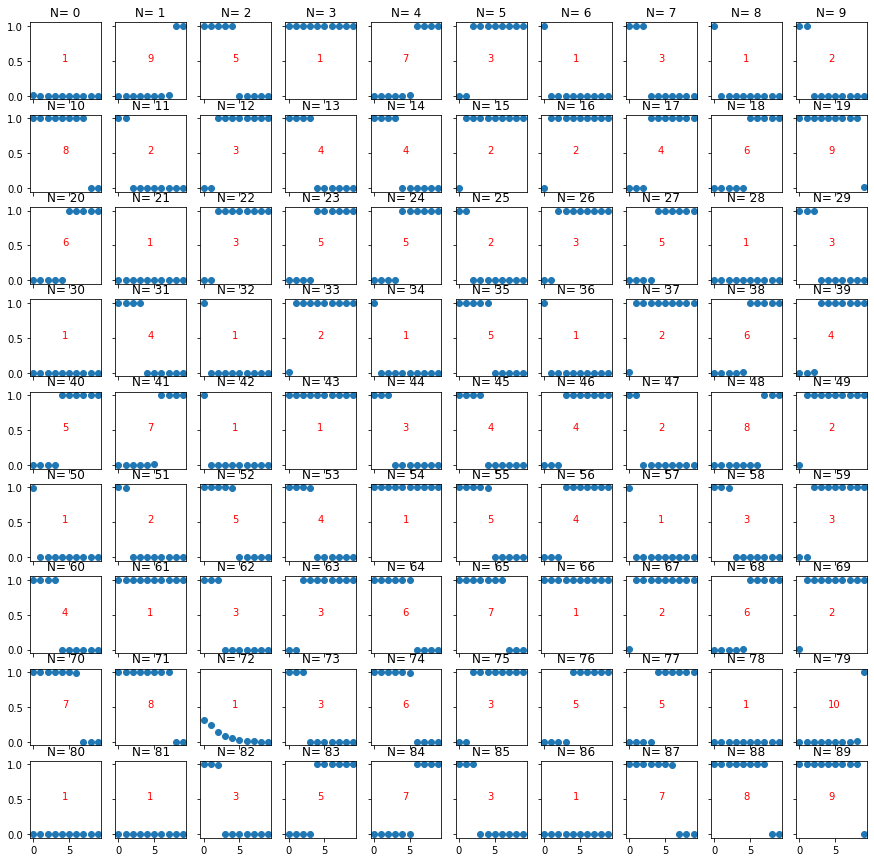

In [ ]:
responsible_neurons_for_each_numerosity = plot_last_layer_activity(last_layer_activity_array)

Responsible units for N= 1: [6, 8, 32, 34, 36, 42, 50, 57, 72]
Responsible units for N= 2: [9, 11, 15, 16, 25, 33, 37, 47, 49, 51, 67, 69]
Responsible units for N= 3: [5, 7, 12, 22, 26, 29, 44, 58, 59, 62, 63, 73, 75, 82, 85]
Responsible units for N= 4: [13, 14, 17, 31, 39, 45, 46, 53, 56, 60]
Responsible units for N= 5: [2, 23, 24, 27, 35, 40, 52, 55, 76, 77, 83]
Responsible units for N= 6: [18, 20, 38, 64, 68, 74]
Responsible units for N= 7: [4, 41, 65, 70, 84, 87]
Responsible units for N= 8: [10, 48, 71, 88]
Responsible units for N= 9: [1, 19, 89]
Responsible units for N= 10: [0, 3, 21, 28, 30, 43, 54, 61, 66, 78, 79, 80, 81, 86]
test_acc:  [1.0, 0.99932206, 1.0, 0.9979716, 0.99734396, 0.99667776, 0.993996, 0.9993311, 0.9973527, 0.9947849]


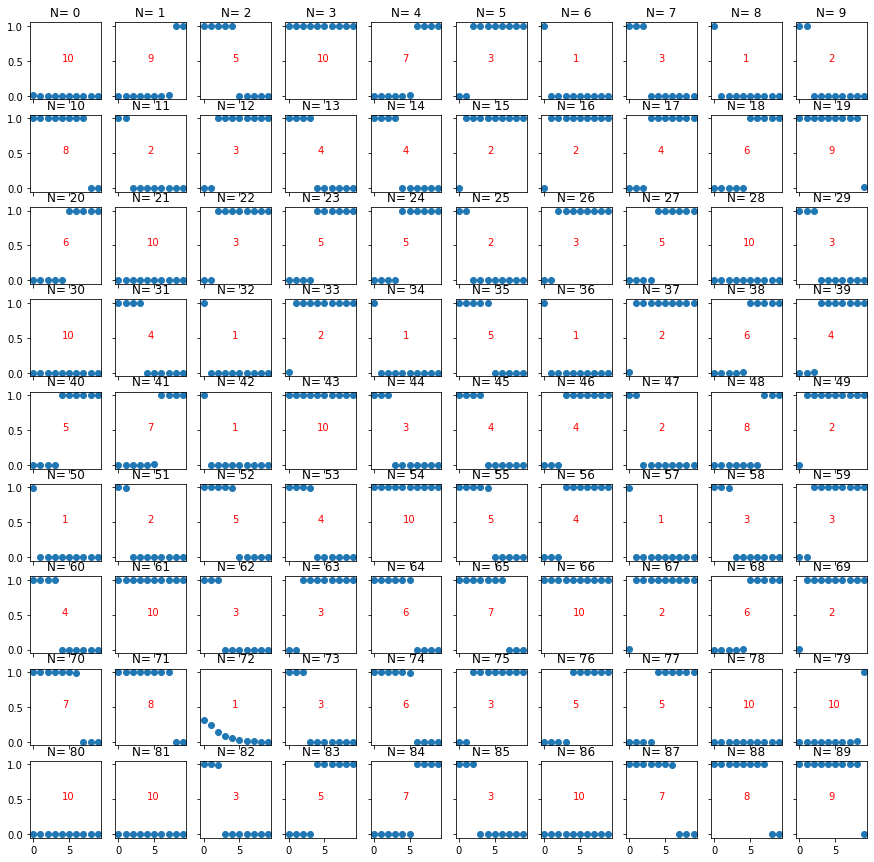

In [ ]:
responsible_neurons_for_each_numerosity, neural_activity_incr, neural_activity_decr = plot_last_layer_activity(last_layer_activity_array)

In [ ]:
neural_activity_incr[0]

array([7.31647853e-03, 3.70756211e-03, 9.63724277e-04, 2.32775041e-04,
       3.06401926e-05, 3.41336381e-05, 9.87612020e-06, 3.71542257e-07,
       5.64094238e-09, 1.09961631e-08])

INFO:tensorflow:Restoring parameters from /content/drive/My Drive/Number_Estimation/Results/2282/nn_model_2282
INFO:tensorflow:Restoring parameters from /content/drive/My Drive/Number_Estimation/Results/2282/nn_model_2282
INFO:tensorflow:Restoring parameters from /content/drive/My Drive/Number_Estimation/Results/2282/nn_model_2282
INFO:tensorflow:Restoring parameters from /content/drive/My Drive/Number_Estimation/Results/2282/nn_model_2282
INFO:tensorflow:Restoring parameters from /content/drive/My Drive/Number_Estimation/Results/2282/nn_model_2282
INFO:tensorflow:Restoring parameters from /content/drive/My Drive/Number_Estimation/Results/2282/nn_model_2282
INFO:tensorflow:Restoring parameters from /content/drive/My Drive/Number_Estimation/Results/2282/nn_model_2282
INFO:tensorflow:Restoring parameters from /content/drive/My Drive/Number_Estimation/Results/2282/nn_model_2282
INFO:tensorflow:Restoring parameters from /content/drive/My Drive/Number_Estimation/Results/2282/nn_model_2282
I

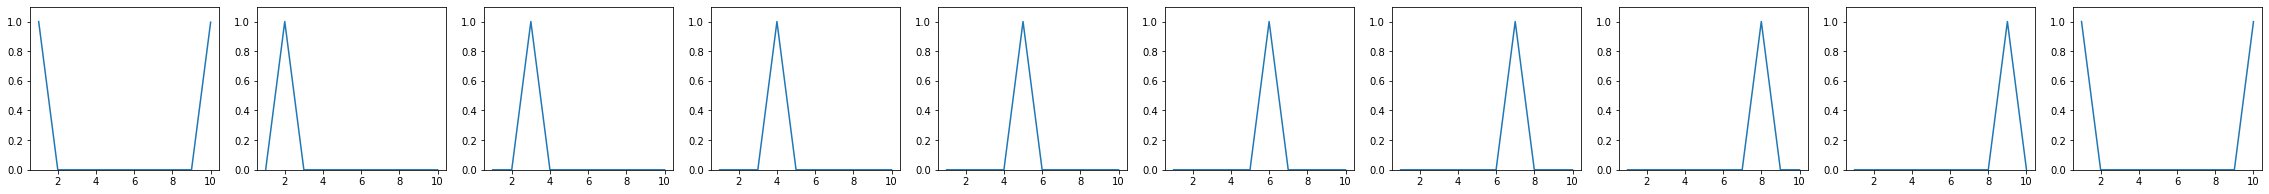

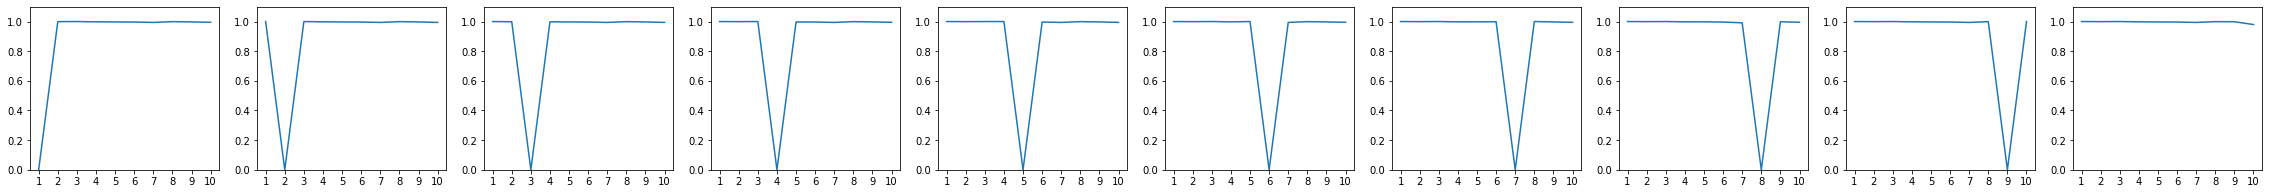

In [ ]:
test_acc_for_each_filtered_num = plot_positive_accuracy(responsible_neurons_for_each_numerosity, model_id, teX, teY_labels)
test_acc_for_each_filtered_num = plot_negative_accuracy(responsible_neurons_for_each_numerosity, model_id, teX, teY_labels)

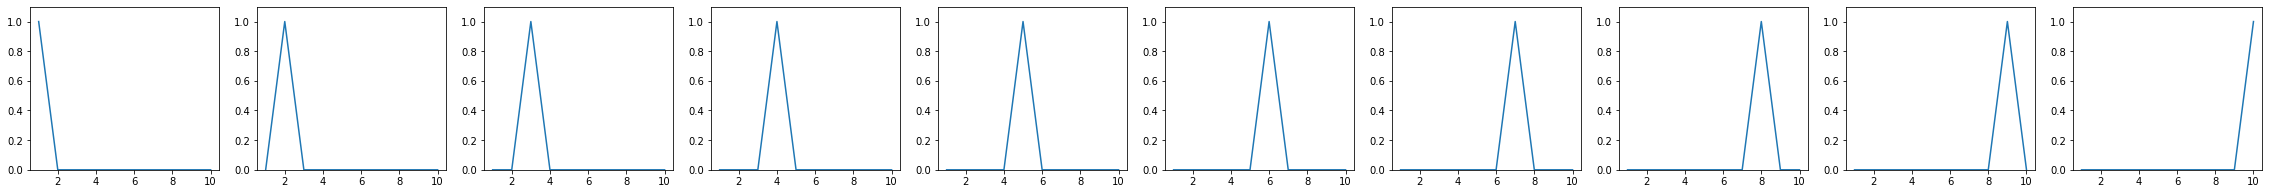

In [ ]:
plot_accuracy_from_existing_test_acc(test_acc_for_each_filtered_num)

In [ ]:
neural_activity_decr

In [ ]:
import collections

def test_act_dict_to_array(neural_activity):
    neural_activity_list = []

    neural_activity_incr_ordered = collections.OrderedDict(sorted(neural_activity.items()))
    for i in neural_activity_incr_ordered.values():
      neural_activity_list.append(i)

    neural_activity_array = np.asarray(neural_activity_list)
    #print(neural_activity_array.shape)
    return neural_activity_array

neural_activity_incr_array = test_act_dict_to_array(neural_activity_incr)
print(neural_activity_incr_array)

In [ ]:
test_acc_positive = plot_positive_accuracy(responsible_neurons_for_each_numerosity, model_id, teX, teY_labels)
test_acc_negative = plot_negative_accuracy(responsible_neurons_for_each_numerosity, model_id, teX, teY_labels)



In [ ]:
def plot_accuracy_from_existing_test_acc(test_acc_for_each_filtered_num):
    fig, ax = plt.subplots(1, max_objects, figsize=(40,3))

    for i in range(len(test_acc_for_each_filtered_num)):

        test_acc = test_acc_for_each_filtered_num[i]
        matplotlib.get_backend()
        ax[i].plot(np.arange(1,len(test_acc)+1), test_acc)
        ax[i].set_ylim(0.0, 1.1)

In [ ]:
# Save nps
basic_path = "/content/drive/My Drive/Number_Estimation/Results/test_acc_and_filtered_tuning_curves/"
test_acc_positive_path = basic_path + "test_acc_positive"
test_acc_negative_path = basic_path + "test_acc_negative"

neural_activity_incr_path = basic_path +  "neural_activity_incr"
neural_activity_decr_path = basic_path + "neural_activity_decr"

#np.save(test_acc_positive_path, test_acc_positive)
#np.save(test_acc_negative_path, test_acc_negative)
np.save(neural_activity_incr_path, neural_activity_incr)
np.save(neural_activity_decr_path, neural_activity_decr)

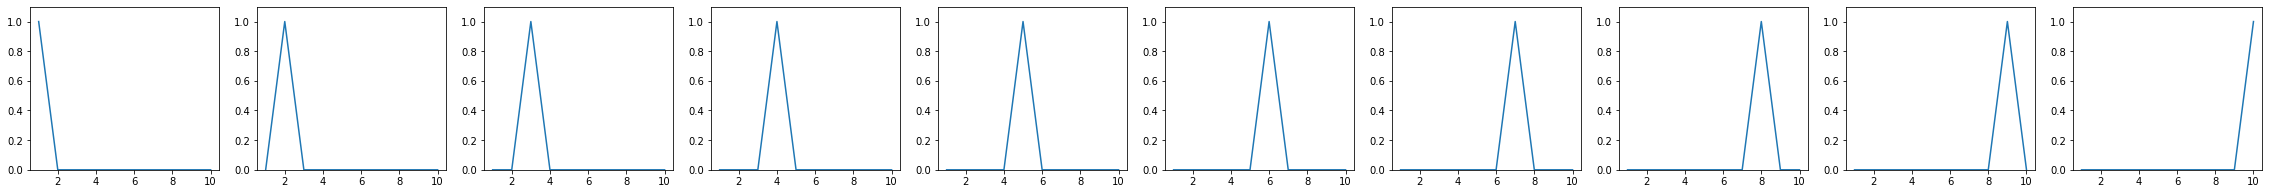

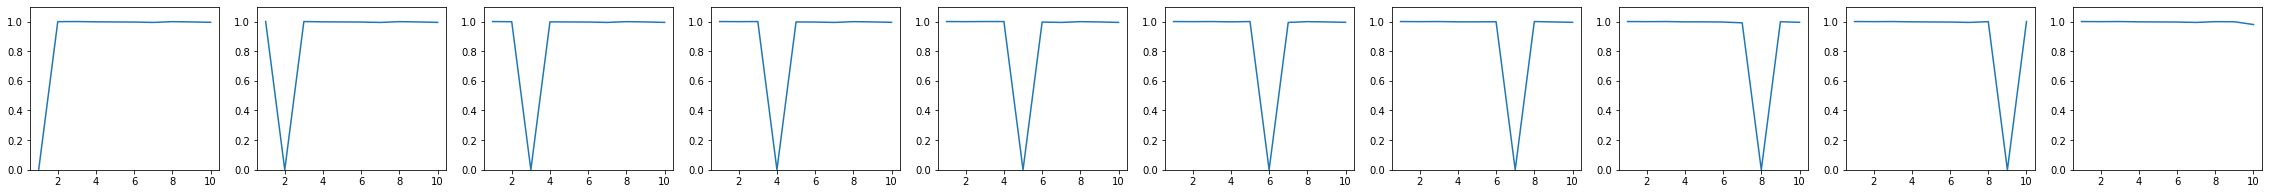

In [ ]:
basic_path = "/content/drive/My Drive/Number_Estimation/Results/test_acc_and_filtered_tuning_curves/"
test_acc_positive_path = basic_path + "test_acc_positive"
test_acc_negative_path = basic_path + "test_acc_negative"

neural_activity_incr_path = basic_path +  "neural_activity_incr"
neural_activity_decr_path = basic_path + "neural_activity_decr"



# Load nps
test_acc_positive = np.load(test_acc_positive_path)
test_acc_negative = np.load(test_acc_negative_path)
neural_activity_incr_array = np.load(neural_activity_incr_path)
neural_activity_decr_array = np.load(neural_activity_decr_path)


plot_accuracy_from_existing_test_acc(test_acc_positive)
plot_accuracy_from_existing_test_acc(test_acc_negative)

plot_accuracy_from_existing_test_acc(neural_activity_incr_array)
plot_accuracy_from_existing_test_acc(neural_activity_decr_array)

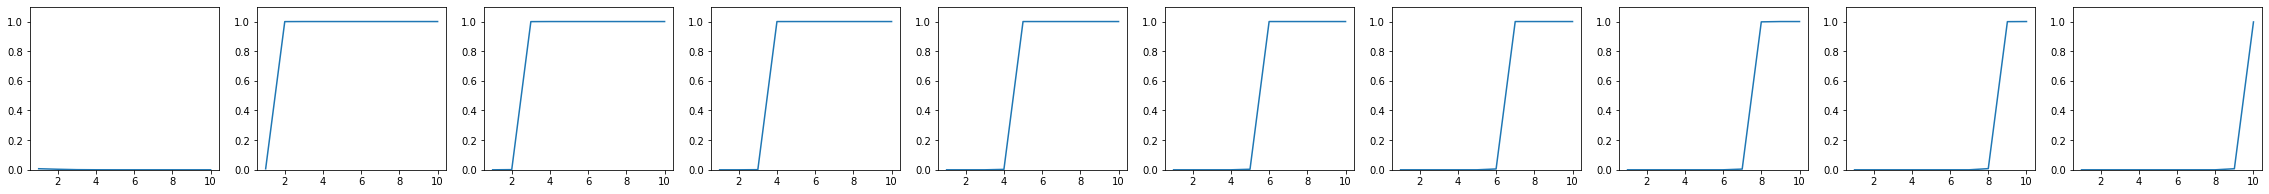

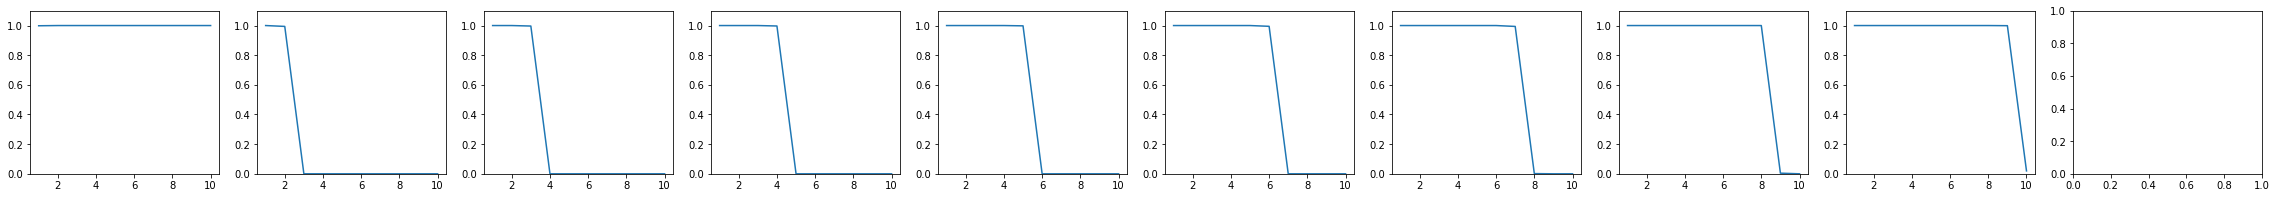

In [ ]:
neural_activity_incr_array = test_act_dict_to_array(neural_activity_incr)
neural_activity_decr_array = test_act_dict_to_array(neural_activity_decr)
#print(neural_activity_decr_array)
plot_accuracy_from_existing_test_acc(neural_activity_incr_array)
plot_accuracy_from_existing_test_acc(neural_activity_decr_array)

INFO:tensorflow:Restoring parameters from /content/drive/My Drive/Number_Estimation/Results/2282/nn_model_2282
INFO:tensorflow:Restoring parameters from /content/drive/My Drive/Number_Estimation/Results/2282/nn_model_2282
INFO:tensorflow:Restoring parameters from /content/drive/My Drive/Number_Estimation/Results/2282/nn_model_2282
INFO:tensorflow:Restoring parameters from /content/drive/My Drive/Number_Estimation/Results/2282/nn_model_2282
INFO:tensorflow:Restoring parameters from /content/drive/My Drive/Number_Estimation/Results/2282/nn_model_2282
INFO:tensorflow:Restoring parameters from /content/drive/My Drive/Number_Estimation/Results/2282/nn_model_2282
INFO:tensorflow:Restoring parameters from /content/drive/My Drive/Number_Estimation/Results/2282/nn_model_2282
INFO:tensorflow:Restoring parameters from /content/drive/My Drive/Number_Estimation/Results/2282/nn_model_2282
INFO:tensorflow:Restoring parameters from /content/drive/My Drive/Number_Estimation/Results/2282/nn_model_2282
I

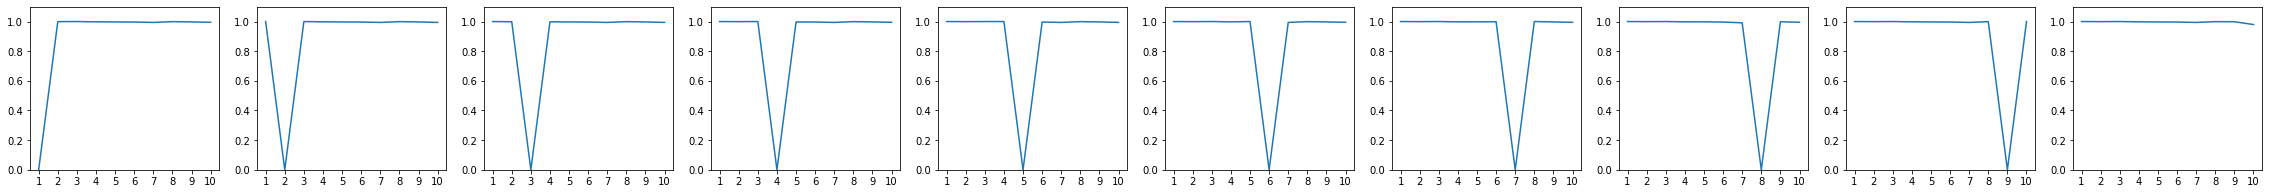

In [ ]:
plot_negative_accuracy(responsible_neurons_for_each_numerosity, model_id, teX, teY_labels)

In [ ]:
### Try out on/off your own to turn of certain neurons
#7
turn_off_neurons_list =  [4, 41, 65, 70, 84, 87]
turn_off_neurons_list =  [4, 41,84]
turn_off_neurons_list =  [65, 70,87]

#8
turn_off_neurons_list = [10, 48, 71, 88]
turn_off_neurons_list = [48]
turn_off_neurons_list = [10, 71, 88]
turn_off_neurons_list = [10, 48]
last_layer_activity_array_, _ = get_last_layer_activity_for_each_number(model_id, teX, teY_labels, turn_off_neurons_list_ = turn_off_neurons_list, plotty=True)

In [ ]:
turn_on_neurons_list =  [4, 41, 65, 70, 84, 87]
turn_on_neurons_list =  [4, 41,84]
turn_on_neurons_list =  [65, 70,87]

turn_on_neurons_list =  [4,41]
turn_on_neurons_list =  [4,84]
turn_on_neurons_list =  [65,70,87,4,41]

#8
#turn_on_neurons_list = [10, 48, 71, 88]
#turn_on_neurons_list = [48]
#turn_on_neurons_list = [10, 48] # 1D1I
#turn_on_neurons_list = [71, 10] # 2I


last_layer_activity_array_,_ = get_last_layer_activity_for_each_number(model_id, teX, teY_labels, turn_on_neurons_list_ = turn_on_neurons_list, plotty=True)

In [ ]:
#######
###########################
## Area/Hull Dataset: get individual tuning curves for different areas and hulls
##########################
#######

In [ ]:
# Load data-set
import pandas as pd
df_data_h_a = pd.read_csv('/content/drive/My Drive/Number_Estimation/numerosity-estimation-master-data/data/test_neural/data_h_a.csv')
df_data_a_h = pd.read_csv('/content/drive/My Drive/Number_Estimation/numerosity-estimation-master-data/data/test_neural/data_a_h.csv')
df_imgs_a_h = np.load('/content/drive/My Drive/Number_Estimation/numerosity-estimation-master-data/data/test_neural/imgs_a_h.npy')
df_imgs_h_a = np.load('/content/drive/My Drive/Number_Estimation/numerosity-estimation-master-data/data/test_neural/imgs_h_a.npy')

df_big = pd.read_csv('/content/drive/My Drive/Number_Estimation/numerosity-estimation-master-data/data/test_neural/data_100000.csv')
df_imgs_big = np.load('/content/drive/My Drive/Number_Estimation/numerosity-estimation-master-data/data/test_neural/imgs_100000.npy')
df_big_labels = df_big.num.values

# Create labels for the data-set
h_a_labels = np.ones(900)
k = 0
for i in range(2,11):
  h_a_labels[k:k+100] = int(i)
  k += 100
h_a_labels = (h_a_labels).astype(int)
print(h_a_labels[899])


10


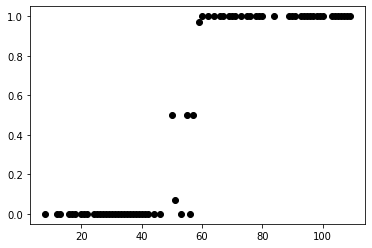

In [ ]:
#plt.plot(df_data_a_h_extended['area'],df_data_a_h_extended['activity_0'], 'o') 
### chiavo
plt.plot(df_data_a_h_average_test['area'], df_data_a_h_average_test['activity_4'], 'o', color='black')


In [ ]:
### both the data-frame and the last layer activity should refer to the same a_h/h_a/... data-set
def extend_df_with_activities(df, last_layer_activity_array_numpy):  
    df_extended = copy(df)
    for i in range(90):  #last_layer_activity_array_numpy[0][0,:].size
        last_layer_activity_for_one_neuron = last_layer_activity_array_numpy[:,:,i]  #last_layer_activity_array_numpy[:][:,i] 
        flatten_last_layer_activity_for_one_neuron = last_layer_activity_for_one_neuron.reshape(-1)
        df_extended['activity_'+str(i)] = flatten_last_layer_activity_for_one_neuron

    return df_extended

def extend_df_with_activities_with_index(df, last_layer_activity_array_, index_list):  
    df_act = pd.DataFrame()

    big_list = index_list[0]
    for list_i in index_list[1:]:
        big_list = np.append(big_list, list_i)
    df_act['index'] = big_list


    big_list_act = last_layer_activity_array_[0]
    for list_i in last_layer_activity_array_[1:]:
        big_list_act = np.append(big_list_act, list_i, axis=0)
    for i in range(90):
        df_act['activity_' + str(i)] = big_list_act[:,i]

    df_extended = pd.merge(left=df_big, right=df_act, left_on='index', right_on='index').sort_values(by='num').reset_index()

    return df_extended


def average_activity_over(df_extended, quantity):
    df_average = pd.DataFrame()
    df_average[quantity] = df_extended[quantity].unique()
    #df_data_a_h_average = df_data_a_h_extended.groupby('num').activity_0.mean().to_frame().reset_index()
    n_neurons = 90

    for n in range(n_neurons):
      stringy = 'activity_'+str(n)
      df_average['activity_'+str(n)] = df_extended.groupby(quantity)[stringy].mean().to_frame().reset_index()[stringy]
    df_average

    return df_average

def plot_last_layer_activity_areas(df_average, quantity, num_list=None):
    fig, ax = plt.subplots(9, 10, sharex='col', sharey='row', figsize=(15,15))

    x_range = df_average['activity_'+str(0)][:].size

    if(quantity=='num'):
        responsible_neurons_for_each_numerosity = [[] for _ in range(x_range)]
    else:
        responsible_neurons_for_each_numerosity = []

    # axes are in a two-dimensional array, indexed by [row, col]
    for i in range(n_hidden_neurons):
            title_string = 'N= ' + str(i)
            ax[int(i/10), i%10].set_title(title_string)
            ax[int(i/10), i%10].plot(df_average[quantity].values, df_average['activity_'+str(i)], 'o' )

            if(quantity=='num'):
                  # Increasing tuning curves (decreasing cardinality)
                  if(df_average['activity_'+str(i)][0]<0.1):
                    was_active = False
                    first_active = 1
                    for k in range(1,x_range):
                        if(df_average['activity_'+str(i)][k] > 0.5 and was_active==False):
                            first_active = k+1
                            was_active = True
                  else:
                    was_active = False
                    first_active = 1
                    for k in range(1,x_range):
                        if(df_average['activity_'+str(i)][k] < 0.5 and was_active==False):
                            first_active = k
                            was_active = True

                  ax[int(i/10), i%10].text(4,0.5,str(first_active), color='red')

                  responsible_neurons_for_each_numerosity[first_active-1].append(i)
                  #ax[int(i/10), i%10].set_xticks(self, ticks, minor=False)
    if(quantity=='num'):
        for n in range(x_range):
            stringy = "Responsible units for N= " + str(n+1) + ": " + str(responsible_neurons_for_each_numerosity[n])
            print(stringy)
        plt.subplots_adjust()
        #print("test_acc: ", test_acc)

    plt.subplots_adjust()

    path_img = '/content/drive/My Drive/Number_Estimation/Tensorflow_NumEst/plots/Fig_S7_last_layer_activity_areas.svg'
    fig.savefig(path_img, format='svg')

    return responsible_neurons_for_each_numerosity

    
'''
# 1: Define dataframe
df = df_data_h_a
df_imgs = df_imgs_h_a
quantity = 'hull'

# 2: Get last layer activity
model_id = 2282  # 90 hidden neurons, 200 epochs, responsible neurons for each number
last_layer_activity_array_mean, test_acc,  last_layer_activity_array_ = get_last_layer_activity_for_each_number(model_id, df_imgs, h_a_labels, plotty=False)
last_layer_activity_array_numpy = np.asarray(last_layer_activity_array_)

df_extended = extend_df_with_activities(df,last_layer_activity_array_numpy)
df_average = average_activity_over(df_extended, quantity)
responsible_neurons_for_each_numerosity = plot_last_layer_activity_areas(df_average, quantity)
'''

"\n# 1: Define dataframe\ndf = df_data_h_a\ndf_imgs = df_imgs_h_a\nquantity = 'hull'\n\n# 2: Get last layer activity\nmodel_id = 2282  # 90 hidden neurons, 200 epochs, responsible neurons for each number\nlast_layer_activity_array_mean, test_acc,  last_layer_activity_array_ = get_last_layer_activity_for_each_number(model_id, df_imgs, h_a_labels, plotty=False)\nlast_layer_activity_array_numpy = np.asarray(last_layer_activity_array_)\n\ndf_extended = extend_df_with_activities(df,last_layer_activity_array_numpy)\ndf_average = average_activity_over(df_extended, quantity)\nresponsible_neurons_for_each_numerosity = plot_last_layer_activity_areas(df_average, quantity)\n"

INFO:tensorflow:Restoring parameters from /content/drive/My Drive/Number_Estimation/Results/2282/nn_model_2282


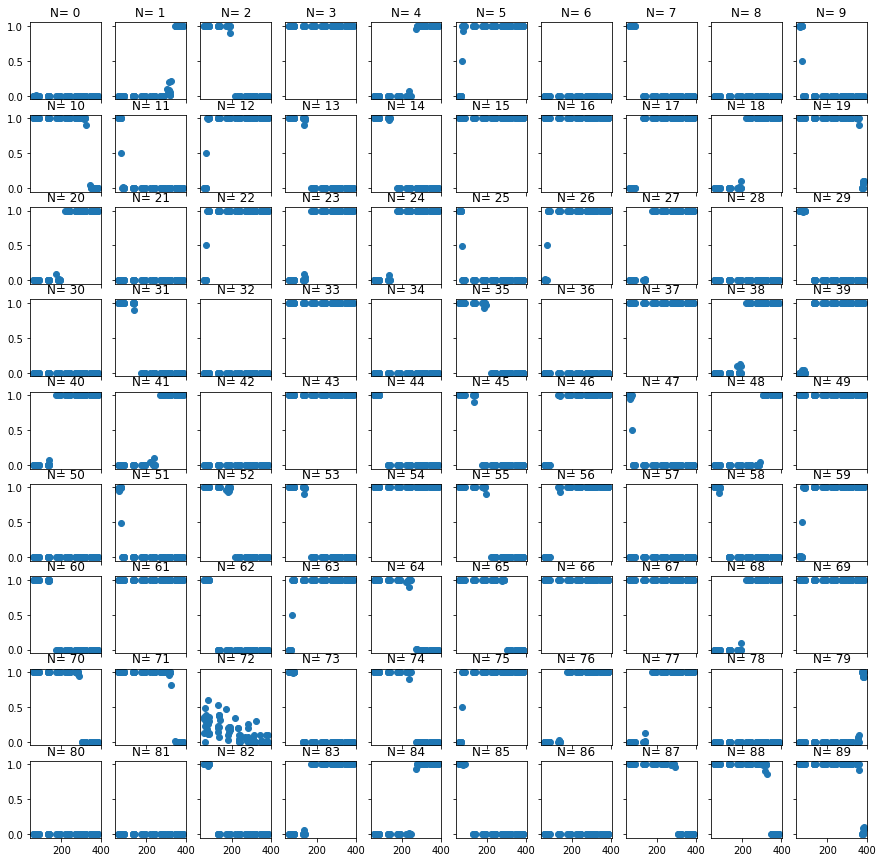

In [ ]:
################################
## FULL RUN - h_a_DATASET
##################################

# 1: Define dataframe
df = df_data_h_a
df_imgs = df_imgs_h_a
quantity = 'hull'

# 2: Get last layer activity
model_id = 2282  # 90 hidden neurons, 200 epochs, responsible neurons for each number
last_layer_activity_array_mean, test_acc,  last_layer_activity_array_, index_list = get_last_layer_activity_for_each_number(model_id, df_imgs, h_a_labels, plotty=False)
last_layer_activity_array_numpy = np.asarray(last_layer_activity_array_)

df_extended = extend_df_with_activities(df,last_layer_activity_array_numpy)
df_average = average_activity_over(df_extended, quantity)
responsible_neurons_for_each_numerosity = plot_last_layer_activity_areas(df_average, quantity)

In [ ]:
################################
## FULL RUN - BIG_DATASET
##################################

# 1: Define dataframe
df_imgs = df_imgs_big
labels = df_big_labels
quantity = 'num'

# 2: Get last layer activity
model_id = 2282  # 90 hidden neurons, 200 epochs, responsible neurons for each number
last_layer_activity_array_mean, test_acc,  last_layer_activity_array_, index_list = get_last_layer_activity_for_each_number(model_id, df_imgs, labels, plotty=False)
last_layer_activity_array_numpy = np.asarray(last_layer_activity_array_)

df_extended = extend_df_with_activities_with_index(df_imgs,last_layer_activity_array_,index_list)
df_average = average_activity_over(df_extended, quantity)
#responsible_neurons_for_each_numerosity = plot_last_layer_activity_areas(df_average, quantity)

INFO:tensorflow:Restoring parameters from /content/drive/My Drive/Number_Estimation/Results/2282/nn_model_2282


In [ ]:
# 1: Define dataframe
#df = df_data_h_a
df_imgs = df_imgs_big
labels = df_big_labels
#quantity = 'hull'

# 2: Get last layer activity
model_id = 2282  # 90 hidden neurons, 200 epochs, responsible neurons for each number
last_layer_activity_array_mean, test_acc,  last_layer_activity_array_, index_list = get_last_layer_activity_for_each_number(model_id, df_imgs, labels, plotty=False)

INFO:tensorflow:Restoring parameters from /content/drive/My Drive/Number_Estimation/Results/2282/nn_model_2282


In [ ]:
df_big.head()

,num,area,hull,index
0,5,95,403,0
1,2,34,72,1
2,3,44,87,2
3,10,147,466,3
4,1,16,16,4


In [ ]:
##############################
## Extend big data set with neural activities
##################################

df_act = pd.DataFrame()

big_list = index_list[0]
for list_i in index_list[1:]:
  big_list = np.append(big_list, list_i)

df_act['index'] = big_list

df_act.head()




,index
0,4
1,42
2,47
3,62
4,68


In [ ]:

big_list_act = last_layer_activity_array_[0]
for list_i in last_layer_activity_array_[1:]:
  big_list_act = np.append(big_list_act, list_i, axis=0)
for i in range(90):
  df_act['activity_' + str(i)] = big_list_act[:,i]
df_act.head()

,index,activity_0,activity_1,activity_2,activity_3,activity_4,activity_5,activity_6,activity_7,activity_8,activity_9,activity_10,activity_11,activity_12,activity_13,activity_14,activity_15,activity_16,activity_17,activity_18,activity_19,activity_20,activity_21,activity_22,activity_23,activity_24,activity_25,activity_26,activity_27,activity_28,activity_29,activity_30,activity_31,activity_32,activity_33,activity_34,activity_35,activity_36,activity_37,activity_38,...,activity_50,activity_51,activity_52,activity_53,activity_54,activity_55,activity_56,activity_57,activity_58,activity_59,activity_60,activity_61,activity_62,activity_63,activity_64,activity_65,activity_66,activity_67,activity_68,activity_69,activity_70,activity_71,activity_72,activity_73,activity_74,activity_75,activity_76,activity_77,activity_78,activity_79,activity_80,activity_81,activity_82,activity_83,activity_84,activity_85,activity_86,activity_87,activity_88,activity_89
0,4,5.029023e-03,0.0,1.0,0.999966,0.0,0.0,0.999957,1.0,1.000000,1.0,1.0,1.0,0.0,1.0,1.0,8.672476e-06,0.000240,0.0,0.0,1.0,0.0,0.000047,0.0,0.0,0.0,1.0,0.0,0.0,0.000097,1.0,1.379848e-05,1.0,0.999971,0.000012,0.999988,1.0,0.999993,0.000384,0.0,...,0.999850,1.0,1.0,1.0,0.999996,1.0,0.0,0.999965,1.0,0.0,1.0,0.999985,1.0,0.0,1.0,1.0,0.999996,2.712011e-06,0.0,0.000583,1.0,1.0,0.949286,1.0,1.0,0.0,0.0,0.0,0.000233,0.0,1.013279e-06,2.175570e-05,1.0,0.0,0.0,1.0,0.000446,1.0,1.0,1.0
1,42,9.238720e-07,0.0,1.0,0.999967,0.0,0.0,0.999974,1.0,0.999998,1.0,1.0,1.0,0.0,1.0,1.0,7.152557e-07,0.000012,0.0,0.0,1.0,0.0,0.000133,0.0,0.0,0.0,1.0,0.0,0.0,0.000188,1.0,1.405180e-04,1.0,0.999997,0.000001,0.999998,1.0,0.999984,0.000271,0.0,...,0.999997,1.0,1.0,1.0,0.999998,1.0,0.0,0.999999,1.0,0.0,1.0,0.999973,1.0,0.0,1.0,1.0,0.999975,4.768372e-07,0.0,0.000014,1.0,1.0,0.215235,1.0,1.0,0.0,0.0,0.0,0.000275,0.0,5.760789e-05,1.131743e-03,1.0,0.0,0.0,1.0,0.000033,1.0,1.0,1.0
2,47,2.046824e-04,0.0,1.0,0.999270,0.0,0.0,0.992948,1.0,0.999992,1.0,1.0,1.0,0.0,1.0,1.0,4.076362e-04,0.001149,0.0,0.0,1.0,0.0,0.000799,0.0,0.0,0.0,1.0,0.0,0.0,0.000161,1.0,4.172325e-07,1.0,0.999972,0.000038,0.998890,1.0,0.999160,0.000828,0.0,...,0.999825,1.0,1.0,1.0,0.999879,1.0,0.0,0.999844,1.0,0.0,1.0,0.999957,1.0,0.0,1.0,1.0,0.999960,5.307794e-05,0.0,0.000867,1.0,1.0,0.659854,1.0,1.0,0.0,0.0,0.0,0.000248,0.0,2.194643e-04,2.107024e-05,1.0,0.0,0.0,1.0,0.000865,1.0,1.0,1.0
3,62,1.042247e-03,0.0,1.0,0.998899,0.0,0.0,0.999982,1.0,1.000000,1.0,1.0,1.0,0.0,1.0,1.0,2.384186e-06,0.000011,0.0,0.0,1.0,0.0,0.000082,0.0,0.0,0.0,1.0,0.0,0.0,0.000037,1.0,8.940697e-08,1.0,0.999996,0.000008,0.999997,1.0,1.000000,0.000015,0.0,...,0.999993,1.0,1.0,1.0,0.999967,1.0,0.0,0.999999,1.0,0.0,1.0,0.999998,1.0,0.0,1.0,1.0,0.999980,7.748604e-07,0.0,0.000042,1.0,1.0,0.000066,1.0,1.0,0.0,0.0,0.0,0.000067,0.0,3.278255e-07,2.682209e-07,1.0,0.0,0.0,1.0,0.000002,1.0,1.0,1.0
4,68,3.815055e-03,0.0,1.0,0.999931,0.0,0.0,0.999987,1.0,1.000000,1.0,1.0,1.0,0.0,1.0,1.0,3.814697e-06,0.000178,0.0,0.0,1.0,0.0,0.000061,0.0,0.0,0.0,1.0,0.0,0.0,0.000018,1.0,1.052022e-05,1.0,0.999965,0.000002,0.999983,1.0,0.999997,0.001110,0.0,...,0.999926,1.0,1.0,1.0,0.999999,1.0,0.0,0.999998,1.0,0.0,1.0,0.999998,1.0,0.0,1.0,1.0,0.999982,2.622604e-06,0.0,0.000385,1.0,1.0,0.841285,1.0,1.0,0.0,0.0,0.0,0.000067,0.0,5.662441e-07,8.285046e-06,1.0,0.0,0.0,1.0,0.000979,1.0,1.0,1.0


In [ ]:
df_extended[df_extended['level_0']==4].head()

,level_0,num,area,hull,index,activity_0,activity_1,activity_2,activity_3,activity_4,activity_5,activity_6,activity_7,activity_8,activity_9,activity_10,activity_11,activity_12,activity_13,activity_14,activity_15,activity_16,activity_17,activity_18,activity_19,activity_20,activity_21,activity_22,activity_23,activity_24,activity_25,activity_26,activity_27,activity_28,activity_29,activity_30,activity_31,activity_32,activity_33,activity_34,...,activity_50,activity_51,activity_52,activity_53,activity_54,activity_55,activity_56,activity_57,activity_58,activity_59,activity_60,activity_61,activity_62,activity_63,activity_64,activity_65,activity_66,activity_67,activity_68,activity_69,activity_70,activity_71,activity_72,activity_73,activity_74,activity_75,activity_76,activity_77,activity_78,activity_79,activity_80,activity_81,activity_82,activity_83,activity_84,activity_85,activity_86,activity_87,activity_88,activity_89
8861,4,1,16,16,4,0.005029,0.0,1.0,0.999966,0.0,0.0,0.999957,1.0,1.0,1.0,1.0,1.0,0.0,1.0,1.0,0.000009,0.00024,0.0,0.0,1.0,0.0,0.000047,0.0,0.0,0.0,1.0,0.0,0.0,0.000097,1.0,0.000014,1.0,0.999971,0.000012,0.999988,...,0.99985,1.0,1.0,1.0,0.999996,1.0,0.0,0.999965,1.0,0.0,1.0,0.999985,1.0,0.0,1.0,1.0,0.999996,0.000003,0.0,0.000583,1.0,1.0,0.949286,1.0,1.0,0.0,0.0,0.0,0.000233,0.0,0.000001,0.000022,1.0,0.0,0.0,1.0,0.000446,1.0,1.0,1.0


In [ ]:
##########
## Merge df_act and df_big
########################

df_extended = pd.merge(left=df_big, right=df_act, left_on='index', right_on='index').sort_values(by='num').reset_index()
df_extended.head()

,level_0,num,area,hull,index,activity_0,activity_1,activity_2,activity_3,activity_4,activity_5,activity_6,activity_7,activity_8,activity_9,activity_10,activity_11,activity_12,activity_13,activity_14,activity_15,activity_16,activity_17,activity_18,activity_19,activity_20,activity_21,activity_22,activity_23,activity_24,activity_25,activity_26,activity_27,activity_28,activity_29,activity_30,activity_31,activity_32,activity_33,activity_34,...,activity_50,activity_51,activity_52,activity_53,activity_54,activity_55,activity_56,activity_57,activity_58,activity_59,activity_60,activity_61,activity_62,activity_63,activity_64,activity_65,activity_66,activity_67,activity_68,activity_69,activity_70,activity_71,activity_72,activity_73,activity_74,activity_75,activity_76,activity_77,activity_78,activity_79,activity_80,activity_81,activity_82,activity_83,activity_84,activity_85,activity_86,activity_87,activity_88,activity_89
0,49999,1,25,25,49999,1.490116e-07,0.0,1.0,0.995674,0.0,0.0,0.999997,1.0,1.000000,1.0,1.0,1.0,0.0,1.0,1.0,6.258488e-07,0.000017,0.0,0.0,1.0,0.0,0.000226,0.0,0.0,0.0,1.0,0.0,0.0,0.001117,1.0,3.904104e-06,1.0,0.999999,4.172325e-07,0.999999,...,0.999996,1.0,1.0,1.0,0.999999,1.0,0.0,1.000000,1.0,0.0,1.0,0.999993,1.0,0.0,1.0,1.0,0.999883,1.072884e-06,0.0,0.000009,1.0,1.0,0.001567,1.0,1.0,0.0,0.0,0.0,0.000197,0.0,0.004799,0.000039,1.0,0.0,0.0,1.0,0.001935,1.0,1.0,1.0
1,28342,1,25,25,28342,5.377829e-04,0.0,1.0,0.999939,0.0,0.0,0.999995,1.0,1.000000,1.0,1.0,1.0,0.0,1.0,1.0,3.758073e-05,0.000038,0.0,0.0,1.0,0.0,0.000005,0.0,0.0,0.0,1.0,0.0,0.0,0.000278,1.0,3.337860e-06,1.0,0.999997,1.102686e-06,0.999997,...,0.999998,1.0,1.0,1.0,1.000000,1.0,0.0,1.000000,1.0,0.0,1.0,0.999535,1.0,0.0,1.0,1.0,0.999997,5.364418e-07,0.0,0.000023,1.0,1.0,0.433219,1.0,1.0,0.0,0.0,0.0,0.000304,0.0,0.000485,0.000004,1.0,0.0,0.0,1.0,0.000045,1.0,1.0,1.0
2,65905,1,25,25,65905,2.980232e-08,0.0,1.0,0.999526,0.0,0.0,0.999952,1.0,0.999993,1.0,1.0,1.0,0.0,1.0,1.0,1.251698e-06,0.000007,0.0,0.0,1.0,0.0,0.000083,0.0,0.0,0.0,1.0,0.0,0.0,0.000938,1.0,2.831221e-06,1.0,0.999996,1.859665e-05,0.999998,...,0.999976,1.0,1.0,1.0,0.999998,1.0,0.0,0.999997,1.0,0.0,1.0,0.999966,1.0,0.0,1.0,1.0,0.999825,8.344650e-07,0.0,0.000061,1.0,1.0,0.007606,1.0,1.0,0.0,0.0,0.0,0.001949,0.0,0.000432,0.000007,1.0,0.0,0.0,1.0,0.000193,1.0,1.0,1.0
3,28333,1,9,9,28333,0.000000e+00,0.0,1.0,0.999874,0.0,0.0,0.998162,1.0,0.999608,1.0,1.0,1.0,0.0,1.0,1.0,6.891489e-04,0.000139,0.0,0.0,1.0,0.0,0.000045,0.0,0.0,0.0,1.0,0.0,0.0,0.000112,1.0,0.000000e+00,1.0,0.999960,9.022355e-04,0.999878,...,0.999996,1.0,1.0,1.0,0.999999,1.0,0.0,0.999950,1.0,0.0,1.0,0.999999,1.0,0.0,1.0,1.0,1.000000,1.579523e-06,0.0,0.008333,1.0,1.0,0.000010,1.0,1.0,0.0,0.0,0.0,0.000016,0.0,0.000006,0.000014,1.0,0.0,0.0,1.0,0.000013,1.0,1.0,1.0
4,65916,1,25,25,65916,1.127720e-04,0.0,1.0,0.996311,0.0,0.0,0.999929,1.0,0.999999,1.0,1.0,1.0,0.0,1.0,1.0,2.682209e-06,0.000086,0.0,0.0,1.0,0.0,0.000157,0.0,0.0,0.0,1.0,0.0,0.0,0.000019,1.0,1.788139e-07,1.0,0.999976,2.831221e-06,0.999999,...,0.999977,1.0,1.0,1.0,1.000000,1.0,0.0,0.999992,1.0,0.0,1.0,0.999313,1.0,0.0,1.0,1.0,0.999933,6.735325e-06,0.0,0.000116,1.0,1.0,0.000295,1.0,1.0,0.0,0.0,0.0,0.000045,0.0,0.000006,0.000001,1.0,0.0,0.0,1.0,0.000151,1.0,1.0,1.0


In [ ]:
##########
## Merge df_act and df_big
########################

df_extended = pd.merge(left=df_big, right=df_act, left_on='index', right_on='index').sort_values(by='num').reset_index()
df_extended.head()

,level_0,num,area,hull,index,activity_0,activity_1,activity_2,activity_3,activity_4,activity_5,activity_6,activity_7,activity_8,activity_9,activity_10,activity_11,activity_12,activity_13,activity_14,activity_15,activity_16,activity_17,activity_18,activity_19,activity_20,activity_21,activity_22,activity_23,activity_24,activity_25,activity_26,activity_27,activity_28,activity_29,activity_30,activity_31,activity_32,activity_33,activity_34,...,activity_50,activity_51,activity_52,activity_53,activity_54,activity_55,activity_56,activity_57,activity_58,activity_59,activity_60,activity_61,activity_62,activity_63,activity_64,activity_65,activity_66,activity_67,activity_68,activity_69,activity_70,activity_71,activity_72,activity_73,activity_74,activity_75,activity_76,activity_77,activity_78,activity_79,activity_80,activity_81,activity_82,activity_83,activity_84,activity_85,activity_86,activity_87,activity_88,activity_89
0,49999,1,25,25,49999,1.490116e-07,0.0,1.0,0.995674,0.0,0.0,0.999997,1.0,1.000000,1.0,1.0,1.0,0.0,1.0,1.0,6.258488e-07,0.000017,0.0,0.0,1.0,0.0,0.000226,0.0,0.0,0.0,1.0,0.0,0.0,0.001117,1.0,3.904104e-06,1.0,0.999999,4.172325e-07,0.999999,...,0.999996,1.0,1.0,1.0,0.999999,1.0,0.0,1.000000,1.0,0.0,1.0,0.999993,1.0,0.0,1.0,1.0,0.999883,1.072884e-06,0.0,0.000009,1.0,1.0,0.001567,1.0,1.0,0.0,0.0,0.0,0.000197,0.0,0.004799,0.000039,1.0,0.0,0.0,1.0,0.001935,1.0,1.0,1.0
1,28342,1,25,25,28342,5.377829e-04,0.0,1.0,0.999939,0.0,0.0,0.999995,1.0,1.000000,1.0,1.0,1.0,0.0,1.0,1.0,3.758073e-05,0.000038,0.0,0.0,1.0,0.0,0.000005,0.0,0.0,0.0,1.0,0.0,0.0,0.000278,1.0,3.337860e-06,1.0,0.999997,1.102686e-06,0.999997,...,0.999998,1.0,1.0,1.0,1.000000,1.0,0.0,1.000000,1.0,0.0,1.0,0.999535,1.0,0.0,1.0,1.0,0.999997,5.364418e-07,0.0,0.000023,1.0,1.0,0.433219,1.0,1.0,0.0,0.0,0.0,0.000304,0.0,0.000485,0.000004,1.0,0.0,0.0,1.0,0.000045,1.0,1.0,1.0
2,65905,1,25,25,65905,2.980232e-08,0.0,1.0,0.999526,0.0,0.0,0.999952,1.0,0.999993,1.0,1.0,1.0,0.0,1.0,1.0,1.251698e-06,0.000007,0.0,0.0,1.0,0.0,0.000083,0.0,0.0,0.0,1.0,0.0,0.0,0.000938,1.0,2.831221e-06,1.0,0.999996,1.859665e-05,0.999998,...,0.999976,1.0,1.0,1.0,0.999998,1.0,0.0,0.999997,1.0,0.0,1.0,0.999966,1.0,0.0,1.0,1.0,0.999825,8.344650e-07,0.0,0.000061,1.0,1.0,0.007606,1.0,1.0,0.0,0.0,0.0,0.001949,0.0,0.000432,0.000007,1.0,0.0,0.0,1.0,0.000193,1.0,1.0,1.0
3,28333,1,9,9,28333,0.000000e+00,0.0,1.0,0.999874,0.0,0.0,0.998162,1.0,0.999608,1.0,1.0,1.0,0.0,1.0,1.0,6.891489e-04,0.000139,0.0,0.0,1.0,0.0,0.000045,0.0,0.0,0.0,1.0,0.0,0.0,0.000112,1.0,0.000000e+00,1.0,0.999960,9.022355e-04,0.999878,...,0.999996,1.0,1.0,1.0,0.999999,1.0,0.0,0.999950,1.0,0.0,1.0,0.999999,1.0,0.0,1.0,1.0,1.000000,1.579523e-06,0.0,0.008333,1.0,1.0,0.000010,1.0,1.0,0.0,0.0,0.0,0.000016,0.0,0.000006,0.000014,1.0,0.0,0.0,1.0,0.000013,1.0,1.0,1.0
4,65916,1,25,25,65916,1.127720e-04,0.0,1.0,0.996311,0.0,0.0,0.999929,1.0,0.999999,1.0,1.0,1.0,0.0,1.0,1.0,2.682209e-06,0.000086,0.0,0.0,1.0,0.0,0.000157,0.0,0.0,0.0,1.0,0.0,0.0,0.000019,1.0,1.788139e-07,1.0,0.999976,2.831221e-06,0.999999,...,0.999977,1.0,1.0,1.0,1.000000,1.0,0.0,0.999992,1.0,0.0,1.0,0.999313,1.0,0.0,1.0,1.0,0.999933,6.735325e-06,0.0,0.000116,1.0,1.0,0.000295,1.0,1.0,0.0,0.0,0.0,0.000045,0.0,0.000006,0.000001,1.0,0.0,0.0,1.0,0.000151,1.0,1.0,1.0


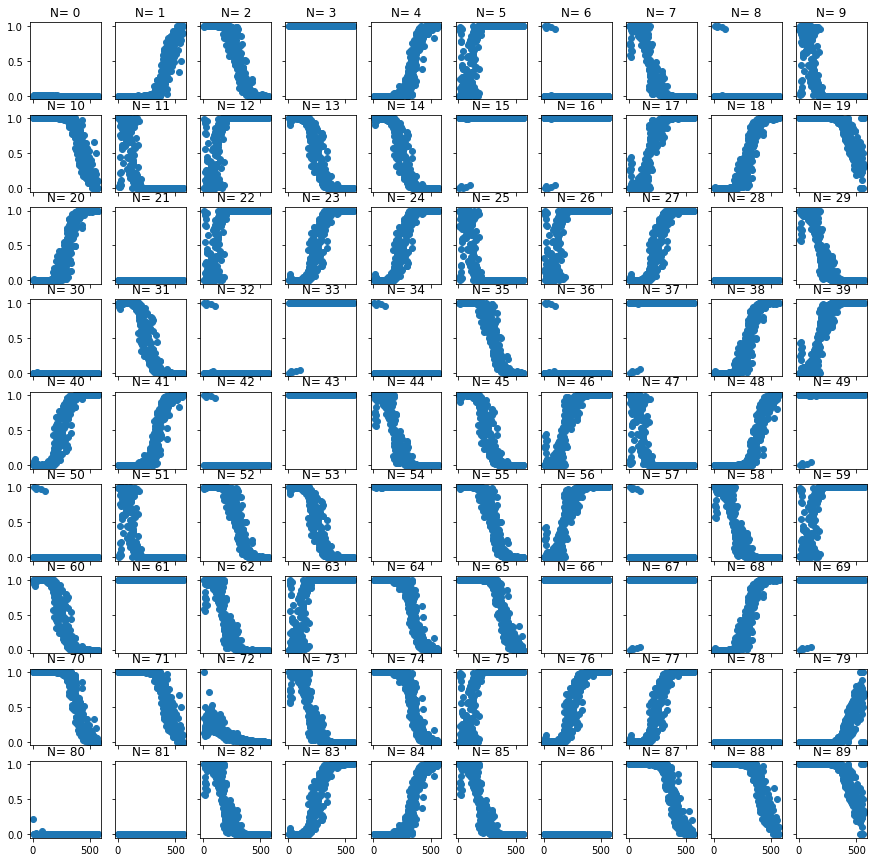

In [ ]:
#keysvg

quantity = 'hull'
df_average = average_activity_over(df_extended, quantity)
#df_average.head()
responsible_neurons_for_each_numerosity = plot_last_layer_activity_areas(df_average, quantity)

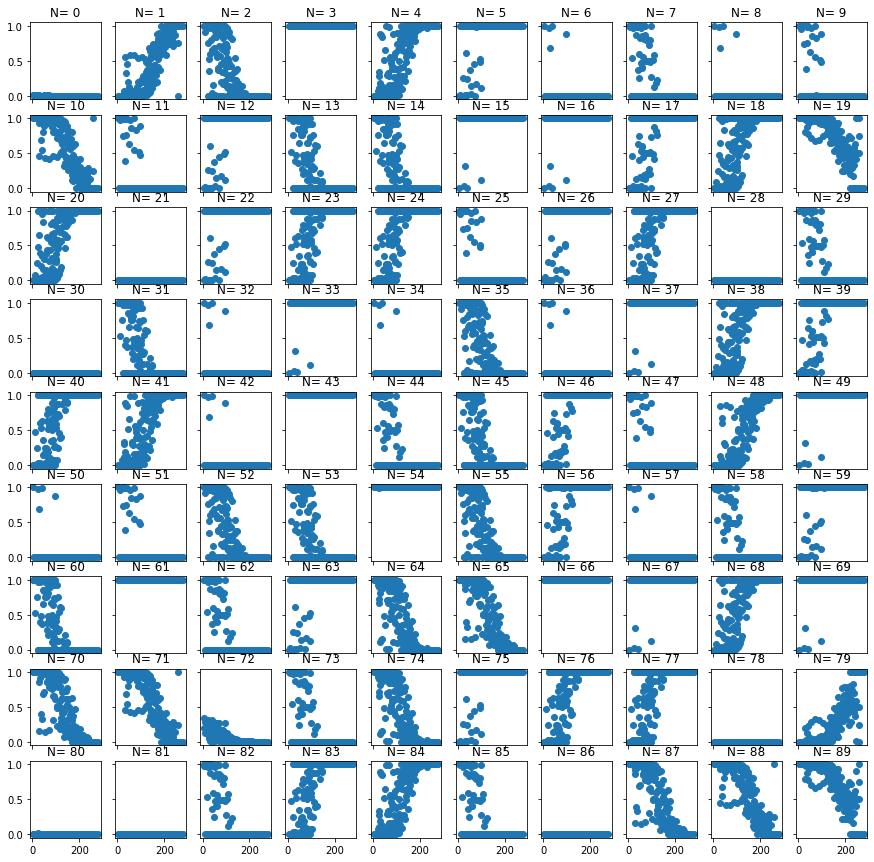

In [ ]:
#keysvg

quantity = 'area'
df_average = average_activity_over(df_extended, quantity)
#df_average.head()
responsible_neurons_for_each_numerosity = plot_last_layer_activity_areas(df_average, quantity)

In [ ]:
print( index_list[0].shape)
print( index_list[1].shape)
#print ( list(index_list[1]) )

flat_list = [index for sublist in [list for list in index_list] for index in [list for list in index_list] ]
list_i = index_list[0]
big_list = np.array([])
big_list = [np.append( big_list, list(list_i)  ) for list_i in index_list ] #np.append(index_list[0], index_list[1])
print( len( big_list) )

#big_list = [index for sublist in [list for list in index_list] for index in [list for list in index_list] ]
#print(big_list)
#stacked_index_list = np.stack(index_list[0], index_list[1]) #[list()]

(9884,)
(10064,)
10


In [ ]:
act_for_each_neuron_list = []
for num in range(10):
  big_list = last_layer_activity_array_[num]
  for i in range(90):
    
    
  



  
  for list_i in index_list[1:]:
    big_list = np.append(big_list, list_i)
  

big_list.shape

(100000,)

In [ ]:
last_layer_activity_array_[0].shape

(9884, 90)

In [ ]:
big_list = last_layer_activity_array_[0]
for list_i in last_layer_activity_array_[1:]:
  big_list = np.append(big_list, list_i, axis=0)
big_list.shape

NameError: ignored

In [ ]:
#df_extended = extend_df_with_activities(df,last_layer_activity_array_)

INFO:tensorflow:Restoring parameters from /content/drive/My Drive/Number_Estimation/Results/2282/nn_model_2282
Responsible units for N= 1: [0, 3, 6, 8, 9, 11, 15, 16, 21, 25, 28, 30, 32, 33, 34, 36, 37, 42, 43, 47, 49, 50, 51, 54, 57, 61, 66, 67, 69, 72, 78, 80, 81, 86]
Responsible units for N= 2: [5, 7, 12, 22, 26, 29, 44, 58, 59, 62, 63, 73, 75, 82, 85]
Responsible units for N= 3: [13, 14, 17, 31, 39, 45, 46, 53, 56, 60]
Responsible units for N= 4: [2, 23, 24, 27, 35, 40, 52, 55, 76, 77, 83]
Responsible units for N= 5: [18, 20, 38, 64, 68, 74]
Responsible units for N= 6: [4, 41, 65, 70, 84, 87]
Responsible units for N= 7: [10, 48, 71, 88]
Responsible units for N= 8: [1, 19, 89]
Responsible units for N= 9: [79]


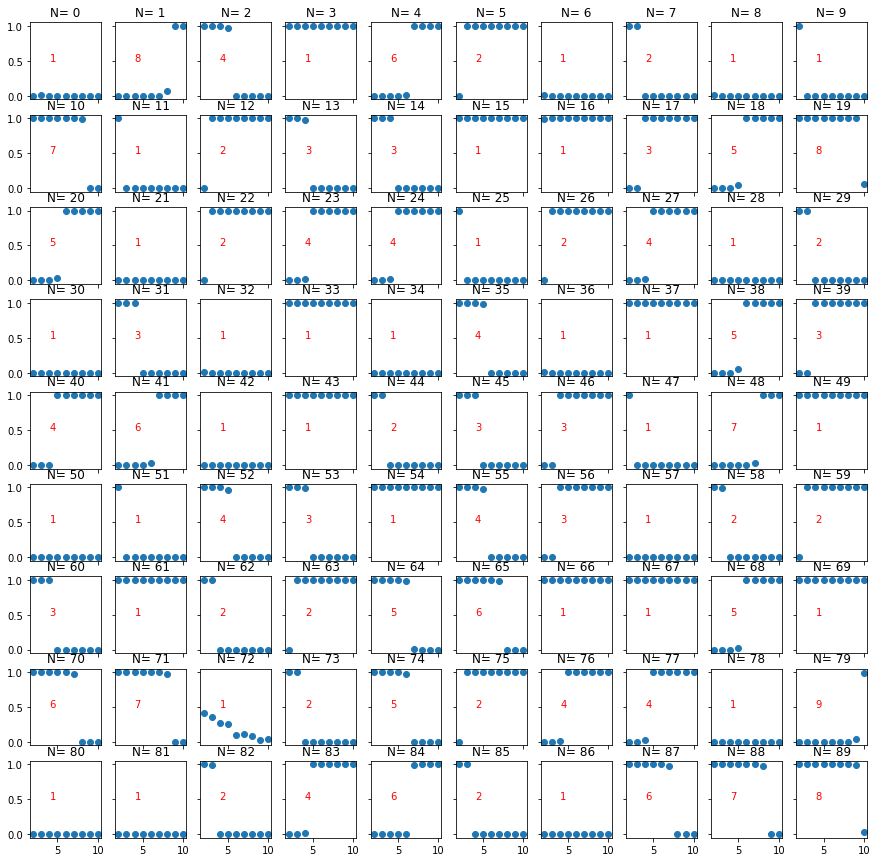

In [ ]:
# 1: Define dataframe
df = df_data_a_h
df_imgs = df_imgs_a_h
labels = df.num.values

quantity = 'num'

# 2: Get last layer activity
model_id = 2282  # 90 hidden neurons, 200 epochs, responsible neurons for each number
last_layer_activity_array_mean, test_acc,  last_layer_activity_array_, index_list = get_last_layer_activity_for_each_number(model_id, df_imgs, labels, plotty=False)

last_layer_activity_array_numpy = np.asarray(last_layer_activity_array_)
#print(last_layer_activity_array_numpy.shape)
#print(last_layer_activity_array_numpy[:,:,0].shape)
#print(len(df.num.unique() ))

df_extended = extend_df_with_activities(df,last_layer_activity_array_numpy)
df_average = average_activity_over(df_extended, quantity)
responsible_neurons_for_each_numerosity = plot_last_layer_activity_areas(df_average, quantity)

In [ ]:
df_big.head()

,num,area,hull,index
0,5,95,403,0
1,2,34,72,1
2,3,44,87,2
3,10,147,466,3
4,1,16,16,4


In [ ]:
len(last_layer_activity_array_[:])

for i in range(10):
last_layer_activity_array_[:]



(9884, 90)

In [ ]:
last_layer_activity_array_mean, test_acc,  last_layer_activity_array_ = get_last_layer_activity_for_each_number(model_id, df_imgs, labels, plotty=False)
last_layer_activity_array_numpy = np.asarray(last_layer_activity_array_)
last_layer_activity_array_[0].shape

INFO:tensorflow:Restoring parameters from /content/drive/My Drive/Number_Estimation/Results/2282/nn_model_2282


(9884, 90)

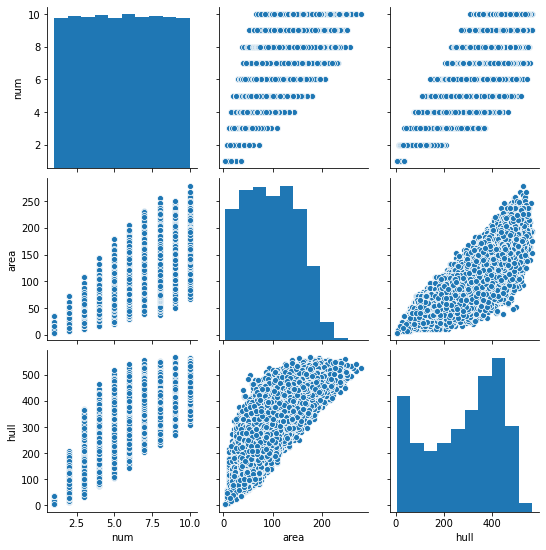

In [ ]:
#datakey
import seaborn as sns
df_sel = df_big
sns_plot = sns.pairplot(df_sel[['num','area','hull']]);
#fig = sns_plot.get_figure()
path_img = '/content/drive/My Drive/Number_Estimation/Tensorflow_NumEst/plots/Fig_S3_data_statistics.svg'
sns_plot.savefig(path_img, format='svg')

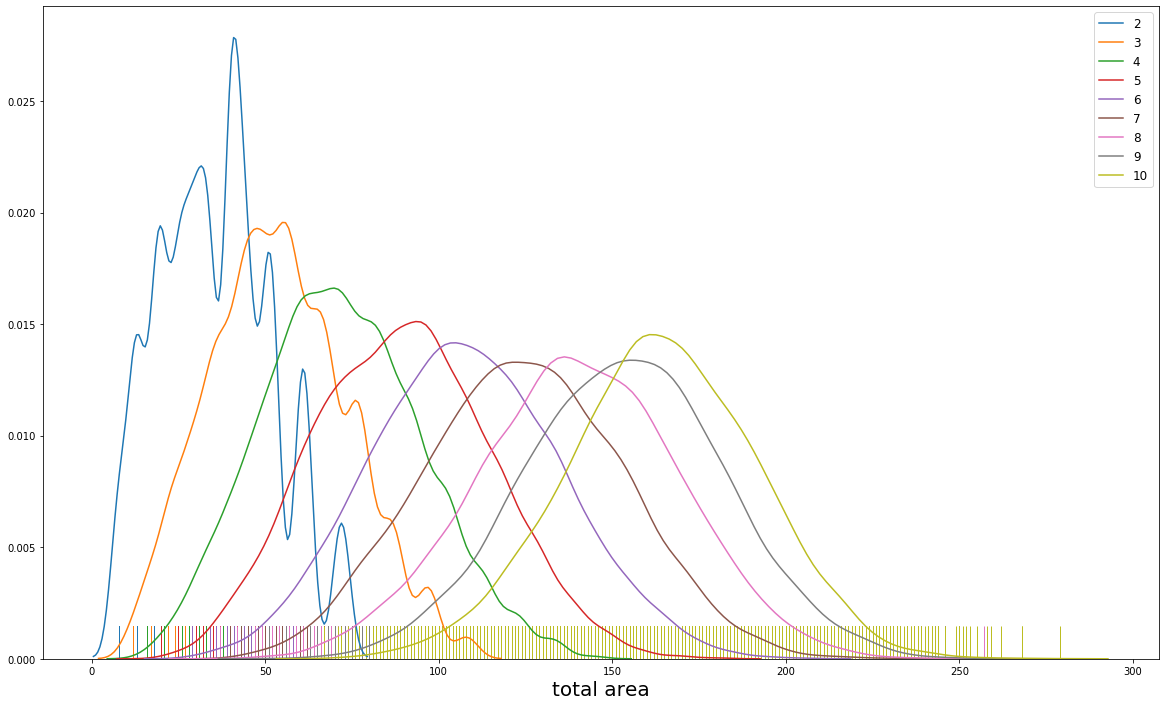

In [ ]:
fig = plt.figure(figsize=(20, 12))
for k in range(2,11,1):
    b = sns.distplot(df_sel[df_sel.num==k]['area'], label=str(k), hist = False, kde = True, rug=True)  
    plt.legend(prop={'size': 12})
    b.set_xlabel("total area",fontsize=20)

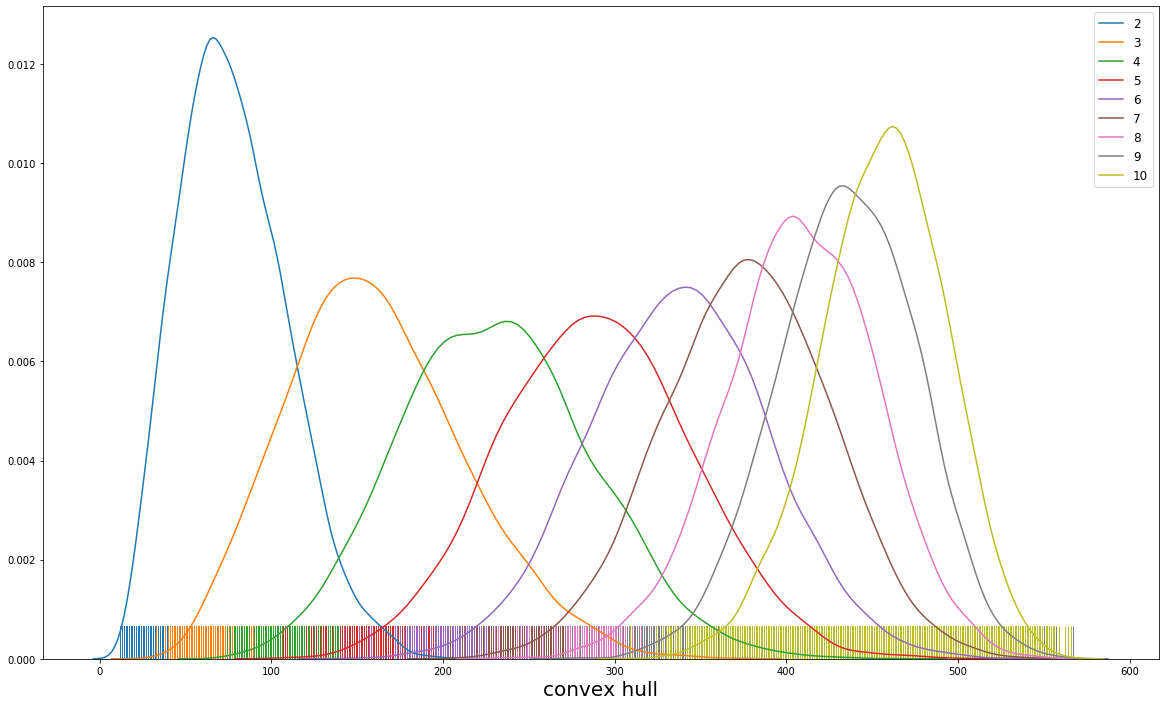

In [ ]:
fig = plt.figure(figsize=(20, 12))
for k in range(2,11,1):
    b = sns.distplot(df_sel[df_sel.num==k]['hull'], label=str(k), hist = False, kde = True, rug=True)  
    plt.legend(prop={'size': 12})
    b.set_xlabel("convex hull",fontsize=20)

In [ ]:
df_data_a_h_average = pd.DataFrame()
df_data_a_h_average['num'] = np.arange(2,11)
#df_data_a_h_average = df_data_a_h_extended.groupby('num').activity_0.mean().to_frame().reset_index()

for n in range(n_neurons):
  stringy = 'activity_'+str(n)
  df_data_a_h_average['activity_'+str(n)] = df_data_a_h_extended.groupby('num')[stringy].mean().to_frame().reset_index()[stringy]
df_data_a_h_average


# average = 0
# for i in range(100):
#   average += df_data_a_h_extended[df_data_a_h_extended.num==3].activity_0.values[i]
# average /= 100
# average

#df_data_a_h_average['activity'] = f_data_a_h_extended.groupby(by=num)d
#last_layer_activity_array_mean = df_data_a_h_extended
#responsible_neurons_for_each_numerosity = plot_last_layer_activity(last_layer_activity_array_mean)

,num,activity_0,activity_1,activity_2,activity_3,activity_4,activity_5,activity_6,activity_7,activity_8,activity_9,activity_10,activity_11,activity_12,activity_13,activity_14,activity_15,activity_16,activity_17,activity_18,activity_19,activity_20,activity_21,activity_22,activity_23,activity_24,activity_25,activity_26,activity_27,activity_28,activity_29,activity_30,activity_31,activity_32,activity_33,activity_34,activity_35,activity_36,activity_37,activity_38,...,activity_50,activity_51,activity_52,activity_53,activity_54,activity_55,activity_56,activity_57,activity_58,activity_59,activity_60,activity_61,activity_62,activity_63,activity_64,activity_65,activity_66,activity_67,activity_68,activity_69,activity_70,activity_71,activity_72,activity_73,activity_74,activity_75,activity_76,activity_77,activity_78,activity_79,activity_80,activity_81,activity_82,activity_83,activity_84,activity_85,activity_86,activity_87,activity_88,activity_89
0,2,3.345239e-03,0.000000,1.000000e+00,0.999973,0.000000,0.000120,0.008497,1.000000,0.006776,0.999667,1.000000,0.999757,0.000278,1.000000,1.000000,0.997556,0.993224,0.000000,0.000000,1.000000,0.000000,4.022389e-05,0.000423,0.000000,0.000000,0.999217,0.000518,0.000000,2.443889e-04,1.000000,4.251867e-05,1.000000e+00,0.003802,0.996,0.000977,1.000000,0.008042,0.993224,0.0000,...,0.00698,0.999435,1.000000e+00,1.000000e+00,0.999956,1.000000e+00,0.000000,0.004466,1.000000e+00,0.000143,1.000000e+00,0.999796,1.000000,0.000128,1.000000,1.000000,0.999986,0.995098,0.000000,0.997495,1.000000,1.000000,0.411511,1.000000,1.000000,0.000313,0.000000,0.000000,2.264735e-04,0.000000e+00,1.217500e-03,2.190593e-04,1.000000,0.000000,0.000000,1.000000,3.029910e-04,1.000000,1.000000,1.000000
1,3,5.109973e-03,0.000000,1.000000e+00,1.000000,0.000000,0.999551,0.000000,0.997615,0.000000,0.000016,1.000000,0.001132,0.997188,1.000000,1.000000,1.000000,1.000000,0.000948,0.000000,1.000000,0.000000,9.676814e-07,0.998564,0.000000,0.000000,0.001306,0.999281,0.000000,4.740089e-05,0.996887,1.056701e-05,1.000000e+00,0.000000,1.000,0.000000,1.000000,0.000000,1.000000,0.0000,...,0.00000,0.000652,1.000000e+00,1.000000e+00,0.999999,1.000000e+00,0.000877,0.000000,9.937529e-01,0.999250,1.000000e+00,0.999900,0.999589,0.999798,1.000000,1.000000,0.999419,1.000000,0.000000,1.000000,1.000000,1.000000,0.363113,0.998376,1.000000,0.998842,0.000000,0.000000,7.668496e-05,0.000000e+00,1.236010e-04,2.988279e-06,0.993699,0.000000,0.000000,0.999862,1.677304e-05,1.000000,1.000000,1.000000
2,4,4.590549e-03,0.000000,1.000000e+00,1.000000,0.000000,1.000000,0.000000,0.000026,0.000000,0.000000,1.000000,0.000000,1.000000,0.968798,0.998959,1.000000,1.000000,0.999989,0.000000,1.000000,0.000000,4.768371e-09,1.000000,0.018656,0.024216,0.000000,1.000000,0.014016,5.164981e-05,0.000012,6.037057e-06,9.952306e-01,0.000000,1.000,0.000000,1.000000,0.000000,1.000000,0.0000,...,0.00000,0.000000,1.000000e+00,9.859605e-01,1.000000,1.000000e+00,0.999996,0.000000,8.937716e-07,1.000000,9.919729e-01,1.000000,0.000130,1.000000,1.000000,1.000000,1.000000,1.000000,0.000000,1.000000,1.000000,1.000000,0.270014,0.000002,1.000000,1.000000,0.011474,0.027487,5.996228e-07,0.000000e+00,7.209182e-07,8.296967e-07,0.000008,0.016245,0.000000,0.000198,5.489767e-05,1.000000,1.000000,1.000000
3,5,1.308024e-06,0.000000,9.709673e-01,1.000000,0.000000,1.000000,0.000000,0.000000,0.000000,0.000000,1.000000,0.000000,1.000000,0.000075,0.000018,1.000000,1.000000,1.000000,0.044901,1.000000,0.034665,0.000000e+00,1.000000,1.000000,0.999998,0.000000,1.000000,0.999992,1.010299e-07,0.000000,2.062321e-07,3.919005e-07,0.000000,1.000,0.000000,0.978585,0.000000,1.000000,0.0504,...,0.00000,0.000000,9.701390e-01,6.270409e-07,1.000000,9.745518e-01,1.000000,0.000000,0.000000e+00,1.000000,4.735589e-07,1.000000,0.000000,1.000000,1.000000,1.000000,1.000000,1.000000,0.019746,1.000000,1.000000,1.000000,0.255759,0.000000,1.000000,1.000000,0.999976,0.999998,2.384186e-08,0.000000e+00,2.629757e-06,1.043081e-08,0.000000,0.999971,0.0

Responsible units for N= 1: [0, 3, 6, 8, 9, 11, 15, 16, 21, 25, 28, 30, 32, 33, 34, 36, 37, 42, 43, 47, 49, 50, 51, 54, 57, 61, 66, 67, 69, 72, 78, 80, 81, 86]
Responsible units for N= 2: [5, 7, 12, 22, 26, 29, 44, 58, 59, 62, 63, 73, 75, 82, 85]
Responsible units for N= 3: [13, 14, 17, 31, 39, 45, 46, 53, 56, 60]
Responsible units for N= 4: [2, 23, 24, 27, 35, 40, 52, 55, 76, 77, 83]
Responsible units for N= 5: [18, 20, 38, 64, 68, 74]
Responsible units for N= 6: [4, 41, 65, 70, 84, 87]
Responsible units for N= 7: [10, 48, 71, 88]
Responsible units for N= 8: [1, 19, 89]
Responsible units for N= 9: [79]
test_acc:  [1.0, 1.0, 0.99, 0.97, 0.99, 0.98, 0.98, 1.0, 0.97]


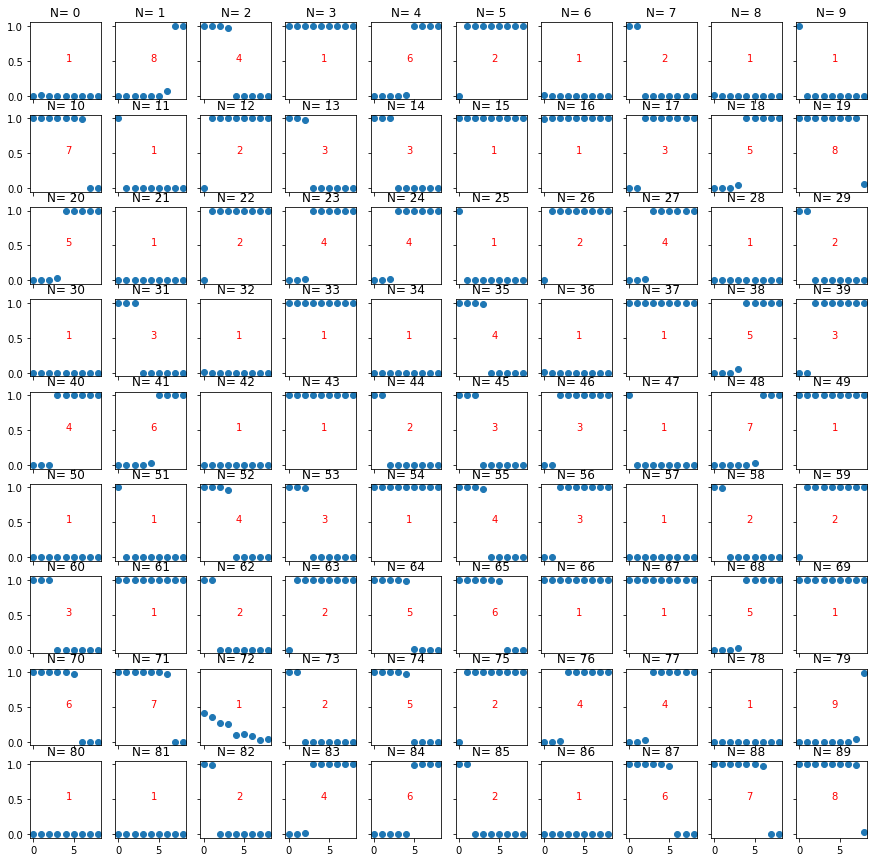

In [ ]:
#responsible_neurons_for_each_numerosity = plot_last_layer_activity(last_layer_activity_array_mean)
df_data_a_h_average.values[:,1:].shape
last_layer_activity_array_mean_from_df = df_data_a_h_average.values[:,1:]
responsible_neurons_for_each_numerosity = plot_last_layer_activity(last_layer_activity_array_mean_from_df)
#print(type(df_data_a_h_average.values[:,1:]) )


In [ ]:
# Get last layer activity
model_id = 2282  # 90 hidden neurons, 200 epochs, responsible neurons for each number
last_layer_activity_array_mean, test_acc,  last_layer_activity_array_ = get_last_layer_activity_for_each_number(model_id, df_imgs_a_h, h_a_labels, plotty=False)
last_layer_activity_array_numpy = np.asarray(last_layer_activity_array_)

INFO:tensorflow:Restoring parameters from /content/drive/My Drive/Number_Estimation/Results/2282/nn_model_2282


In [ ]:
print(last_layer_activity_array_mean.shape)

(9, 90)


In [ ]:
last_layer_activity_for_one_neuron = last_layer_activity_array_numpy[:,:,0]
last_layer_activity_for_one_neuron.shape

(9, 100)

In [ ]:
flatten_last_layer_activity_for_one_neuron = last_layer_activity_for_one_neuron.reshape(-1)
flatten_last_layer_activity_for_one_neuron.shape

(900,)

In [ ]:
a = np.array([[1,2,3],[3,4,5]])
print(a)
print(a.shape)
a_flatten = a.reshape(-1)
print(a_flatten)
print(a_flatten.shape)

[[1 2 3]
 [3 4 5]]
(2, 3)
[1 2 3 3 4 5]
(6,)


Responsible units for N= 1: [0, 3, 6, 8, 9, 11, 15, 16, 21, 25, 28, 30, 32, 33, 34, 36, 37, 42, 43, 47, 49, 50, 51, 54, 57, 61, 66, 67, 69, 72, 78, 80, 81, 86]
Responsible units for N= 2: [5, 7, 12, 22, 26, 29, 44, 58, 59, 62, 63, 73, 75, 82, 85]
Responsible units for N= 3: [13, 14, 17, 31, 39, 45, 46, 53, 56, 60]
Responsible units for N= 4: [2, 23, 24, 27, 35, 40, 52, 55, 76, 77, 83]
Responsible units for N= 5: [18, 20, 38, 64, 68, 74]
Responsible units for N= 6: [4, 41, 65, 70, 84, 87]
Responsible units for N= 7: [10, 48, 71, 88]
Responsible units for N= 8: [1, 19, 89]
Responsible units for N= 9: [79]
test_acc:  [1.0, 1.0, 0.99, 0.97, 0.99, 0.98, 0.98, 1.0, 0.97]


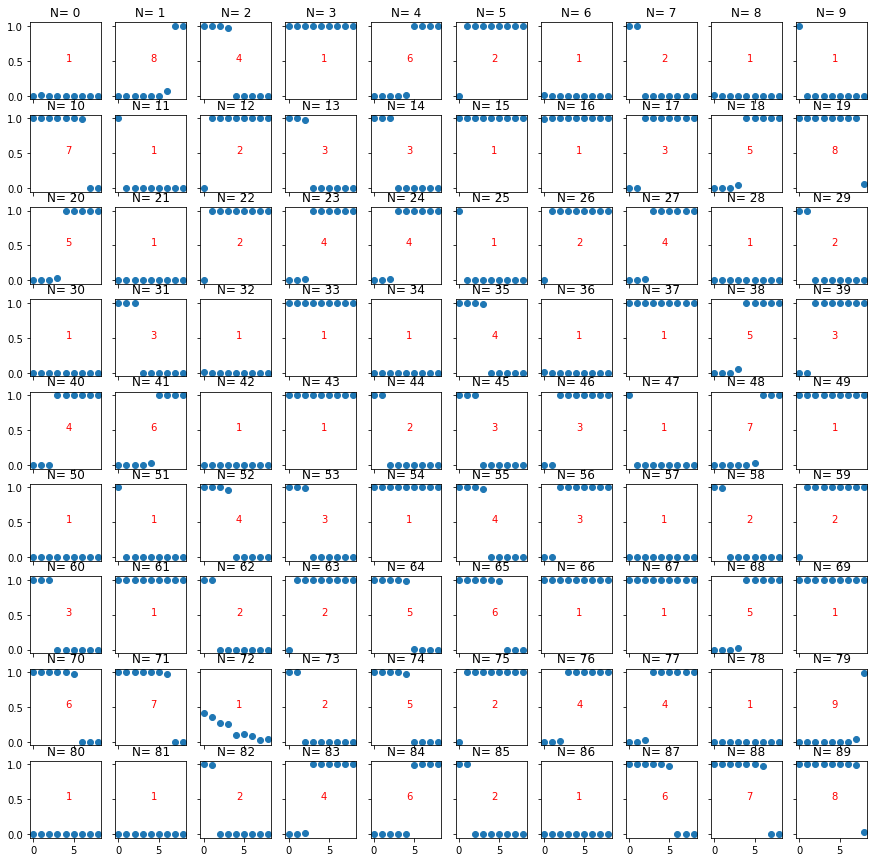

In [ ]:
responsible_neurons_for_each_numerosity = plot_last_layer_activity(last_layer_activity_array_mean)

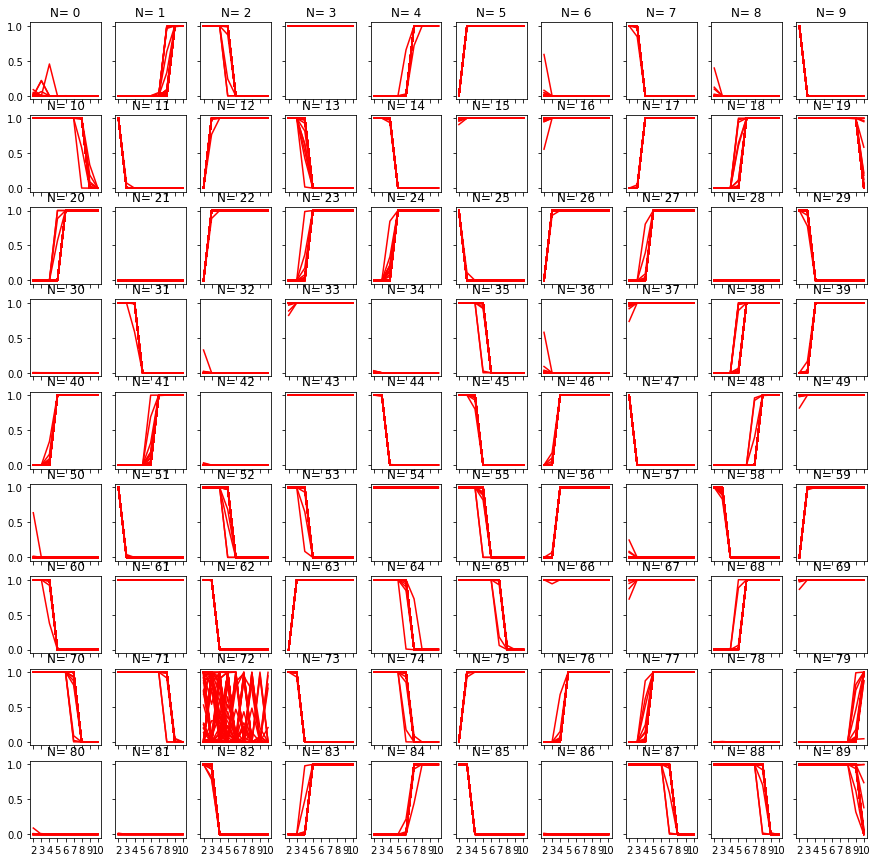

In [ ]:
def plot_individual_last_layer_activity_for_all_neurons(last_layer_activity_array_numpy):
  num_list = range(2,11)
  fig, ax = plt.subplots(9, 10, sharex='col', sharey='row', figsize=(15,15))
  
  for i in range(100):
    add_tuning_curve_to_plot(fig, ax, last_layer_activity_array_numpy[:,i,:], colory="red")

def add_tuning_curve_to_plot(fig, ax, last_layer_activity_array, colory="red"):
    # axes are in a two-dimensional array, indexed by [row, col]
    num_list = range(2,11)
    for i in range(90):
            title_string = 'N= ' + str(i)
            ax[int(i/10), i%10].set_title(title_string)
            ax[int(i/10), i%10].plot(num_list, last_layer_activity_array[:,i], color=colory )
            ax[int(i/10), i%10].set_xticks(range(2,11))

plot_individual_last_layer_activity_for_all_neurons(last_layer_activity_array_numpy)

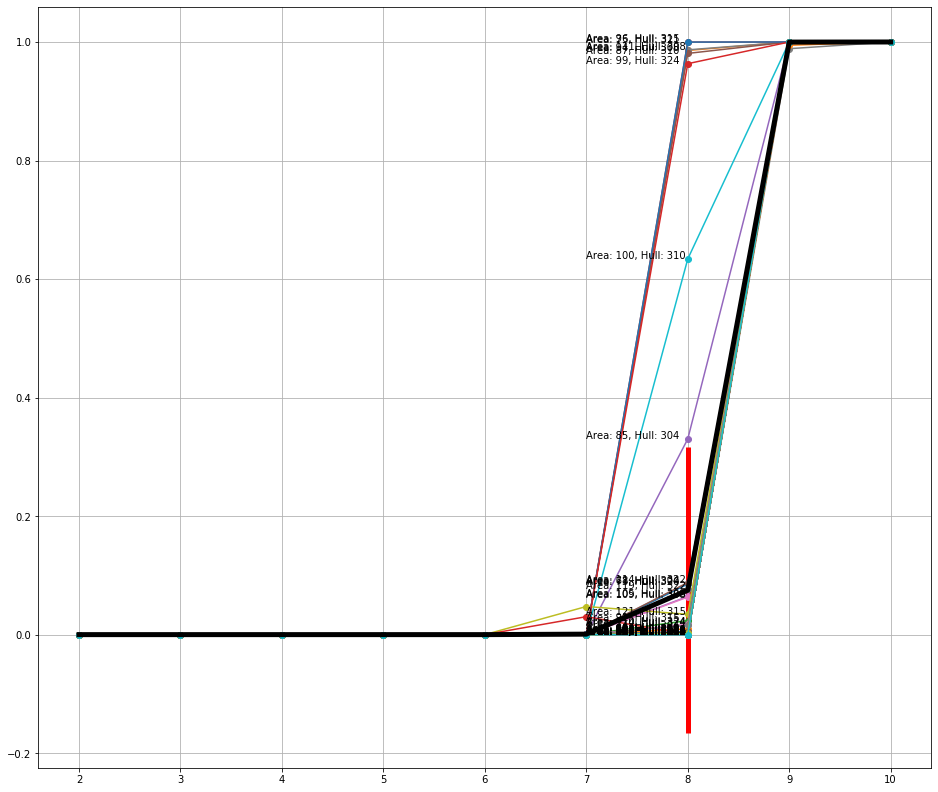

In [ ]:
def plot_individual_last_layer_activity_for_neuron_n(last_layer_activity_array_numpy, neuron_n):
    n_neuron = 1
    num_list = range(2,11)
    fig = plt.figure(figsize=(16,14))
    ax = fig.add_subplot()
    ax.plot(num_list, last_layer_activity_array_numpy[:,:,neuron_n], 'o-')
    std = np.std(last_layer_activity_array_numpy[:,:,neuron_n], axis=1)
    ax.errorbar(num_list, last_layer_activity_array_mean[:,neuron_n], yerr=np.transpose(std), ecolor='red', linestyle='-', linewidth=5, markersize=8, color='black')
    ax.grid()
    ax.set_xticks(num_list)

    annotaty = True
    if(annotaty == True):

        number_n_descripted = 8
        k=100*(number_n_descripted-2)

        area_hull_string_list = []
        for i in range(df_data_h_a['area'].values[k:k+100].size):
          area_string = "Area: " + str(df_data_h_a['area'].values[k:k+100][i])
          hull_string = "Hull: " + str(df_data_h_a['hull'].values[k:k+100][i])
          area_hull_string = area_string + ", " + hull_string
          area_hull_string_list.append(area_hull_string)

        for i in range(last_layer_activity_array_numpy.shape[1]):
          s = area_hull_string_list[i]
          ax.annotate(s, (number_n_descripted-1,last_layer_activity_array_numpy[number_n_descripted-2,i,neuron_n]) )
          

plot_individual_last_layer_activity_for_neuron_n(last_layer_activity_array_numpy, neuron_n=1)

Areas:
[ 68  74  75  82  85  87 101 103 105 111  65  94  95  99 105 108 109 111
 116 117  64  75  78  80  82  87  90  91  92 100  47  78  86  91  92  97
  98 102 107 114  66  86  91  96  97 103 105 113 121 122  80  85  91  93
  96  99 103 107 109 119  73  86  94  97 102 105 106 109 110 112  75  86
 100 106 108 114 115 116 120 124  85 101 107 108 112 114 115 119 120 123
  77  82  91  99 100 107 110 114 118 132]

Hulls:
[304 304 304 304 304 304 304 304 304 304 308 308 308 308 308 308 308 308
 308 308 310 310 310 310 310 310 310 310 310 310 314 314 314 314 314 314
 314 314 314 314 315 315 315 315 315 315 315 315 315 315 318 318 318 318
 318 318 318 318 318 318 320 320 320 320 320 320 320 320 320 320 321 321
 321 321 321 321 321 321 321 321 322 322 322 322 322 322 322 322 322 322
 324 324 324 324 324 324 324 324 324 324]


(array([ 1.,  0.,  4., 10., 12., 17., 20., 21., 13.,  2.]),
 array([ 47. ,  55.5,  64. ,  72.5,  81. ,  89.5,  98. , 106.5, 115. ,
        123.5, 132. ]),
 <a list of 10 Patch objects>)

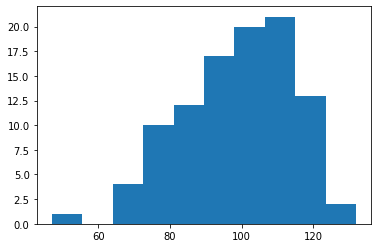

In [ ]:
################
## Get areas and hulls of a certain numerosity of the data set. Can  be useful weather the outliers above lie in the lower/higher range of areas/hulls.

numerosity = 8
k=100*(numerosity-2)
print("Areas:")
print(df_data_h_a['area'].values[k:k+100])
print("")
print("Hulls:")
print(df_data_h_a['hull'].values[k:k+100])

area_hull_string_list = []
for i in range(df_data_h_a['area'].values[k:k+100].size):
  area_string = "Area: " + str(df_data_h_a['area'].values[k:k+100][i])
  hull_string = "Hull: " + str(df_data_h_a['hull'].values[k:k+100][i])
  area_hull_string = area_string + ", " + hull_string
  area_hull_string_list.append(area_hull_string)

plt.hist(df_data_h_a['area'].values[k:k+100])
#plt.hist(df_data_h_a['hull'].values[k:k+100])

In [ ]:
#########################
###
####
#### THE END
####
###
##########################

In [ ]:
df_data_h_a['area'].values[k:k+100]
df_data_h_a[df_data_h_a.num==4].area.value_counts()
max_len = 0

for a in range(130):
    len(df_data_h_a[df_data_h_a.area==a].index.values)

,num,area,hull,index
403,6,55,220,53805
500,7,55,271,13524


In [ ]:
last_layer_activity_array_numpy.shape

# Average over same hulls
same_hull_avg = 0
neuron_n = 1


(9, 100, 90)

In [ ]:
df_data_h_a[ (df_data_h_a.num==2) & (df_data_h_a.hull==57) ]

,num,area,hull,index
0,2,8,57,57980
1,2,13,57,30314
2,2,18,57,37780
3,2,20,57,30032
4,2,25,57,71729
5,2,29,57,65835
6,2,32,57,12148
7,2,34,57,83905
8,2,40,57,46256
9,2,41,57,69153


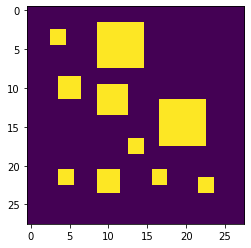

In [ ]:
df_data_h_a.head(102)

plt.imshow(df_imgs_h_a[899].reshape((28,28)))

In [ ]:

print(last_layer_activity_array_numpy.shape)

(9, 100, 90)


In [ ]:
last_layer_activity_array_numpy.shape

(9, 100, 90)

In [ ]:
last_layer_activity_array_numpy[:,:,n_neuron]
print(last_layer_activity_array_numpy[3,:,n_neuron].shape)
std_i = np.std(last_layer_activity_array_numpy[3,:,n_neuron])
print(std_i)

(100,)
0.09680249


In [ ]:
#sum of squared deviations
sum_err = 0
vec = last_layer_activity_array_numpy[3,:,n_neuron]
mean_vec = np.mean(vec)
for i in range(100):
  sum_err += (mean_vec-vec[i])*(mean_vec-vec[i])
mean_sum_err = np.sqrt(sum_err/100)

print(mean_sum_err)


0.09680249137791384


(9,)


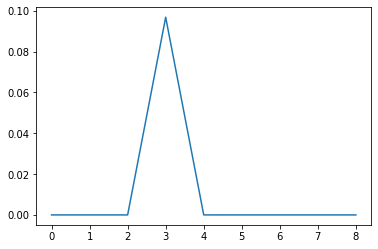

In [ ]:
#### Calculate standard deviation for each numerosity
#std = np.std(last_layer_activity_array_numpy[:,:,1], axis=1)
print(std.shape)
plt.plot(std)

In [ ]:
## chiavo

print(len(last_layer_activity_array_))
print(last_layer_activity_array_[0].shape)
print(last_layer_activity_array_mean.shape)


9
(100, 90)
(9, 90)


In [ ]:
###############################
## TEST AND USE LEARNED MODEL: Last layer activity
###########################

def get_and_save_last_layer_activity(model_id, teX, teY, set_name):
    with tf.Session() as sess:
        #sess = tf_debug.TensorBoardDebugWrapperSession(sess, "localhost:6064")
        restore_model_id = model_id
        save_model_path = '/content/drive/My Drive/Number_Estimation/Results/' + str(restore_model_id) + '/'
        saver = tf.train.Saver()
        saver.restore(sess, tf.train.latest_checkpoint(save_model_path)) 
            
        last_layer_activity = np.zeros( shape=(100,90 ) )
            
        
        ### Test test set
        ### Now create actual filter
        # Filter
        #filty = np.ones(90)
        #listy = [2,16,23,42,52,59,63,74,79]
        #listy = [1,15,22,41,51,58,62,73,78]

        #tf_filty_stacked = create_neuron_filter(9000, listy) 
        tf_filty_stacked_2 = np.ones((int(teX[:,0].size),90))
        
        indi, summary, acc,last_layer_activity = sess.run([indices, merged, acc_op, fc1], feed_dict={X: teX.astype(np.float32), Y: teY.astype(np.float32),filtery: tf_filty_stacked_2, p_keep_input: 1.0, p_keep_hidden: 1.0,is_training: False, failed_object: 0,failed_object_string: "0"})
        print("Total accuracy with all neurons: ", acc)

        save_activity_path = save_model_path + "last_layer_activity_" + set_name
        np.save(save_activity_path, last_layer_activity)
          
        #indi, summary, acc = sess.run([indices, merged, acc_op], feed_dict={X: teX.astype(np.float32), Y: teY.astype(np.float32),filtery: tf_filty_stacked, p_keep_input: 1.0, p_keep_hidden: 1.0,is_training: False, failed_object: 0,failed_object_string: "0"})
        #print("Total accuracy with missing neurons: ", acc)  
          
        #tf_filty_stacked_2 = np.ones((100,90)) 
        #tf_filty_stacked = create_neuron_filter(100, listy) 
          
        #test_acc = []
        #test_acc_2 = []

          
        ### Test single number seperately  
        ### Create 1000 test examples for each number of squares each
        #for i in range(max_objects):
        #    mult_img2, mult_class2,areas, orig_areas = Create_N_Images(100, only_one_number=True, n_squares=i+1) 
        #    mult_images.append(mult_img2)
        #    mult_classes.append(mult_class2)
            
        #    indi, summary, acc, last_layer_activity[i,:] = sess.run([indices, merged, acc_op, fc1], feed_dict={X: mult_img2.astype(np.float32), Y: mult_class2.astype(np.float32),filtery: tf_filty_stacked_2, p_keep_input: 1.0, p_keep_hidden: 1.0,is_training: False, failed_object: 0,failed_object_string: "0"})
        #    test_acc.append(acc)
        #    print("Individual_accuracy", i, ": ", acc)

In [ ]:
###############################
## TEST AND USE LEARNED MODEL: Last layer activity
###########################

with tf.Session() as sess:
    #sess = tf_debug.TensorBoardDebugWrapperSession(sess, "localhost:6064")
    save_model_path = '/content/drive/My Drive/Tensorflow_NumEst/saved_models/'
    saver = tf.train.Saver()
    saver.restore(sess, tf.train.latest_checkpoint(save_model_path)) 
        
    last_layer_activity = np.zeros( shape=(max_objects,100,90 ) )
        
    
    ### Test test set
    ### Now create actual filter
    # Filter
    filty = np.ones(90)
    listy = [2,16,23,42,52,59,63,74,79]
    listy = [1,15,22,41,51,58,62,73,78]

    #tf_filty_stacked = create_neuron_filter(9000, listy) 
    tf_filty_stacked_2 = np.ones((9000,90))
    
    indi, summary, acc = sess.run([indices, merged, acc_op], feed_dict={X: teX.astype(np.float32), Y: teY.astype(np.float32),filtery: tf_filty_stacked_2, p_keep_input: 1.0, p_keep_hidden: 1.0,is_training: False, failed_object: 0,failed_object_string: "0"})
    print("Total accuracy with all neurons: ", acc)
      
    #indi, summary, acc = sess.run([indices, merged, acc_op], feed_dict={X: teX.astype(np.float32), Y: teY.astype(np.float32),filtery: tf_filty_stacked, p_keep_input: 1.0, p_keep_hidden: 1.0,is_training: False, failed_object: 0,failed_object_string: "0"})
    print("Total accuracy with missing neurons: ", acc)  
      
    tf_filty_stacked_2 = np.ones((100,90)) 
    #tf_filty_stacked = create_neuron_filter(100, listy) 
      
    test_acc = []
    test_acc_2 = []
    #test_avg = []
    #test_avg_2 = []
      
    ### Test single number seperately  
    ### Create 1000 test examples for each number of squares each
    '''
    for i in range(max_objects):
        mult_img2, mult_class2,areas, orig_areas = Create_N_Images(100, only_one_number=True, n_squares=i+1) 
        mult_images.append(mult_img2)
        mult_classes.append(mult_class2)
        
        indi, summary, acc, last_layer_activity[i,:] = sess.run([indices, merged, acc_op, fc1], feed_dict={X: mult_img2.astype(np.float32), Y: mult_class2.astype(np.float32),filtery: tf_filty_stacked_2, p_keep_input: 1.0, p_keep_hidden: 1.0,is_training: False, failed_object: 0,failed_object_string: "0"})
        test_acc.append(acc)
        print("Individual_accuracy", i, ": ", acc)
    '''

INFO:tensorflow:Restoring parameters from /content/drive/My Drive/Tensorflow_NumEst/saved_models/simple_model
Total accuracy with all neurons:  0.70155555
Total accuracy with missing neurons:  0.70155555


In [ ]:
print(X[0].size)
print(X[1].size)
print(Y[0].size)
print(Y[1].size)

print(Y[:4])
arr = Y[:4]
newArr = np.where(arr, arr[7]==1)
print("next line")
print(newArr)

In [ ]:
print(dic_a_h['imgs'].shape)
print(dic_a_h['imgs'].shape[0])
print(dic_a_h['imgs'].shape[1])
#flatty = dic_a_h['imgs'].reshape()
print(dic_a_h['num'])

In [ ]:
#X = teX
#Y = teY

X = dic_a_h['imgs']
Y = one_hot(dic_a_h['num'], 10)

In [ ]:
print(dic_a_h[0])

KeyError: ignored

In [ ]:
# example: numerosity = 3, areas considered = n_areas, hulls per area = n_hulls
num=5
n_areas=10
n_hulls=10
dic_a_h = select_images_areas_hulls(num, df, n_areas, n_hulls)
dic_a_h

In [ ]:
# example: numerosity = 3, n_hulls considered = n_hulls, n_areas per hull = n_areas
num=5
n_hulls=10
n_areas=10
dic_h_a = select_images_hulls_areas(num, df, n_hulls, n_areas)
dic_h_a

In [ ]:
dic_a_h_2s = [dic_a_h[i] for i in select_list if i==2] 

print(dic_a_h['num'])
print(dic_a_h_2s)

In [ ]:
print(X[0].size)

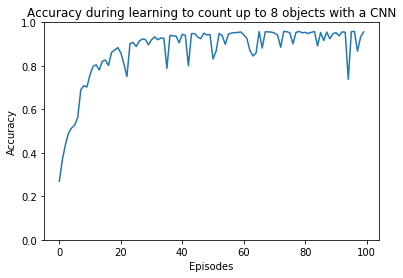

In [ ]:
#######################
## PLOT ACCURACY CURVE
######################

matplotlib.get_backend()
plt.plot(np.arange(0,n_episodes), acc_arr)
plt.ylabel('Accuracy')
plt.xlabel('Episodes')
plt.ylim(0,1)
#titlestring = 'Accuracy development during learning to count up to ' + str(trY[0].size) + ' object with a CNN'
titlestring = 'Accuracy during learning to count up to ' + "8" + ' objects with a CNN'

path_img = '/content/drive/My Drive/Tensorflow_NumEst/plots/accuracy_curve'
#plt.legend()
plt.title(titlestring)
plt.savefig(path_img, dpi = 1600)

#plt.savefig('Standard_NN.png')
#plt.plot([1,2,3], [1,1,1])
plt.show()

In [ ]:

####################
## Neuron filter
##################


def create_neuron_filter(batch_size, listy_, n_neurons=90):
    filty = np.ones(n_neurons)
    listy = listy_
    filty[listy] = 0

    # Stacked filter
    filty_stacked = np.zeros((batch_size,n_neurons))
    for i in range(batch_size):
      filty_stacked[i,:] = filty

    return filty_stacked

def create_neuron_filter_turn_on(batch_size, listy_, n_neurons=90):
    filty = np.zeros(n_neurons)
    listy = listy_
    filty[listy] = 1

    # Stacked filter
    filty_stacked = np.zeros((batch_size,n_neurons))
    for i in range(batch_size):
      filty_stacked[i,:] = filty

    return filty_stacked



In [ ]:
teX = imgs[:9000]
teY = classes_one_hot[:9000]

In [ ]:
###############################
## TEST AND USE LEARNED MODEL
###########################

with tf.Session() as sess:
    #sess = tf_debug.TensorBoardDebugWrapperSession(sess, "localhost:6064")
    save_model_path = '/content/drive/My Drive/Tensorflow_NumEst/saved_models/'
    saver = tf.train.Saver()
    saver.restore(sess, tf.train.latest_checkpoint(save_model_path)) 
        
    last_layer_activity = np.zeros( shape=(max_objects,100,90 ) )
        
    
    ### Test test set
    ### Now create actual filter
    # Filter
    filty = np.ones(90)
    listy = [2,16,23,42,52,59,63,74,79]
    listy = [1,15,22,41,51,58,62,73,78]

    tf_filty_stacked = create_neuron_filter(9000, listy) 
    tf_filty_stacked_2 = np.ones((9000,90))
    
    indi, summary, acc = sess.run([indices, merged, acc_op], feed_dict={X: teX.astype(np.float32), Y: teY.astype(np.float32),filtery: tf_filty_stacked_2, p_keep_input: 1.0, p_keep_hidden: 1.0,is_training: False, failed_object: 0,failed_object_string: "0"})
    print("Total accuracy with all neurons: ", acc)
      
    indi, summary, acc = sess.run([indices, merged, acc_op], feed_dict={X: teX.astype(np.float32), Y: teY.astype(np.float32),filtery: tf_filty_stacked, p_keep_input: 1.0, p_keep_hidden: 1.0,is_training: False, failed_object: 0,failed_object_string: "0"})
    print("Total accuracy with missing neurons: ", acc)  
      
    tf_filty_stacked_2 = np.ones((100,90)) 
    tf_filty_stacked = create_neuron_filter(100, listy) 
      
    test_acc = []
    test_acc_2 = []
    #test_avg = []
    #test_avg_2 = []
      
    ### Test single number seperately  
    ### Create 1000 test examples for each number of squares each
    for i in range(max_objects):
        mult_img2, mult_class2,areas, orig_areas = Create_N_Images(100, only_one_number=True, n_squares=i+1) 
        mult_images.append(mult_img2)
        mult_classes.append(mult_class2)
        
        indi, summary, acc, last_layer_activity[i,:] = sess.run([indices, merged, acc_op, fc1], feed_dict={X: mult_img2.astype(np.float32), Y: mult_class2.astype(np.float32),filtery: tf_filty_stacked_2, p_keep_input: 1.0, p_keep_hidden: 1.0,is_training: False, failed_object: 0,failed_object_string: "0"})
        test_acc.append(acc)
        print("Individual_accuracy", i, ": ", acc)
        
    for i in range(max_objects):
        mult_img2, mult_class2,areas, orig_areas = Create_N_Images(100, only_one_number=True, n_squares=i+1) 
        mult_images.append(mult_img2)
        mult_classes.append(mult_class2)
        
        indi, summary, acc, last_layer_activity[i,:] = sess.run([indices, merged, acc_op, fc1], feed_dict={X: mult_img2.astype(np.float32), Y: mult_class2.astype(np.float32),filtery: tf_filty_stacked, p_keep_input: 1.0, p_keep_hidden: 1.0,is_training: False, failed_object: 0,failed_object_string: "0"})
        test_acc_2.append(acc)    
        print("Individual_accuracy", i, ": ", acc)
        

    
    
    
    test_acc_areas = np.zeros((5, 3))
    ### Test single number with FIXED AREAS  
    ### Create 100 test examples for each number of squares each
    
    for i in range(5):
        for j in range(3):
            mult_img2, mult_class2,areas, orig_areas = Create_N_Images(100, only_one_number=True, n_squares=i+1, fixed_area=True, area_=j)
            mult_images.append(mult_img2)
            mult_classes.append(mult_class2)

            indi, summary, acc, last_layer_activity[i,:] = sess.run([indices, merged, acc_op, fc1], feed_dict={X: mult_img2.astype(np.float32), Y: mult_class2.astype(np.float32),filtery: tf_filty_stacked_2, p_keep_input: 1.0, p_keep_hidden: 1.0,is_training: False, failed_object: 0,failed_object_string: "0"})
            test_acc_areas[i,j] = acc
            print("Individual_accuracy", i, ": ", acc)

            
    last_layer_activity = np.zeros( shape=(3,100,90 ) )        
    ###################
    ## Save Network activity for n=3 for different areas
    ###############################
    for j in range(3):
            mult_img2, mult_class2,areas, orig_areas = Create_N_Images(100, only_one_number=True, n_squares=3, fixed_area=True, area_=j)

            indi, summary, acc, last_layer_activity[j,:] = sess.run([indices, merged, acc_op, fc1], feed_dict={X: mult_img2.astype(np.float32), Y: mult_class2.astype(np.float32),filtery: tf_filty_stacked_2, p_keep_input: 1.0, p_keep_hidden: 1.0,is_training: False, failed_object: 0,failed_object_string: "0"})
            
    #############################
    ## Save failed image classification
    ##############################
    tf_filty_stacked_2 = np.ones((9000,90))
    indi, summary, acc, failed = sess.run([indices, merged, acc_op, imgy2], feed_dict={X: teX.astype(np.float32), Y: teY.astype(np.float32),p_keep_input: 1.0, p_keep_hidden: 1.0,is_training: False, failed_object: 0,failed_object_string: "0", filtery:tf_filty_stacked_2})
    print("failed[0]: ", failed[0])
    import scipy.misc
    #scipy.misc.imsave('failed.jpg', failed)
    print("failed.size: ", failed.shape)
    failed_c = failed.copy()
    first_image = Image.fromarray(failed_c[0].resize((28,28)).resize( (400,400) ) )
    first_image.save(PATH, save_all=True)
    

INFO:tensorflow:Restoring parameters from /content/drive/My Drive/Tensorflow_NumEst/saved_models/simple_model
Total accuracy with all neurons:  0.9642222
Total accuracy with missing neurons:  0.8641111
Individual_accuracy 0 :  1.0
Individual_accuracy 1 :  1.0
Individual_accuracy 2 :  1.0
Individual_accuracy 3 :  1.0
Individual_accuracy 4 :  0.99
Individual_accuracy 5 :  1.0
Individual_accuracy 6 :  0.94
Individual_accuracy 7 :  0.9
Individual_accuracy 8 :  0.86
Individual_accuracy 9 :  0.92
Individual_accuracy 0 :  1.0
Individual_accuracy 1 :  1.0
Individual_accuracy 2 :  1.0
Individual_accuracy 3 :  0.0
Individual_accuracy 4 :  1.0
Individual_accuracy 5 :  0.98
Individual_accuracy 6 :  0.98
Individual_accuracy 7 :  0.95
Individual_accuracy 8 :  0.9
ATTENTION: OBJECTS COULD NOT FIT INTO WINDOW. CHOOSE DIFFERENT SIZE FOR WINDOW OR OBJECTS
ATTENTION: OBJECTS COULD NOT FIT INTO WINDOW. CHOOSE DIFFERENT SIZE FOR WINDOW OR OBJECTS
Individual_accuracy 9 :  0.93
Individual_accuracy 0 :  1.0
I

AttributeError: ignored

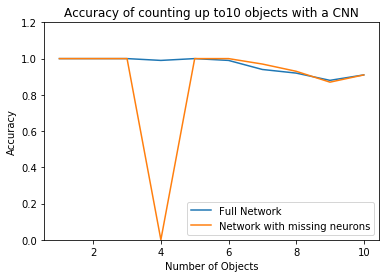

In [ ]:
#######################
## PLOT ACCURACY CURVE: with and without missing neurons
######################

matplotlib.get_backend()
plt.plot(np.arange(1,max_objects+1), test_acc, label='Full Network')
plt.plot(np.arange(1,max_objects+1), test_acc_2, label='Network with missing neurons')
#plt.legend([test_acc, test_acc_2], ['Full network', 'Network with missing neurons'])
plt.ylabel('Accuracy')
plt.xlabel('Number of Objects')
plt.ylim(0,1.2)
titlestring = 'Accuracy of counting up to' + str(trY[0].size) + ' objects with a CNN'
plt.title(titlestring)
path_img = '/content/drive/My Drive/Tensorflow_NumEst/plots/comparison_turn_off_neurons'
#plt.plot([1,2,3], [1,1,1])
plt.legend()
plt.savefig(path_img, dpi = 1000)
plt.show()


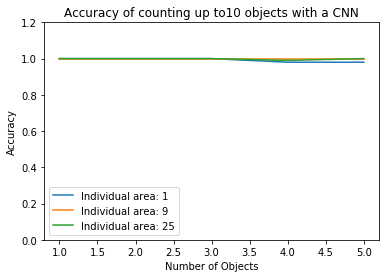

In [ ]:
#######################
## PLOT ACCURACY CURVE: for all different areas
######################

matplotlib.get_backend()
for j in range(3):
    legendy = "Individual area: " + str( (2*j+1)*(2*j+1)  )
    plt.plot(np.arange(1,6), test_acc_areas[:,j], label=legendy)
#plt.legend([test_acc, test_acc_2], ['Full network', 'Network with missing neurons'])
plt.ylabel('Accuracy')
plt.xlabel('Number of Objects')
plt.ylim(0,1.2)
titlestring = 'Accuracy of counting up to' + str(trY[0].size) + ' objects with a CNN'
plt.title(titlestring)
path_img = '/content/drive/My Drive/Tensorflow_NumEst/plots/diff_areas'
#plt.plot([1,2,3], [1,1,1])
plt.legend()
plt.savefig(path_img, dpi = 1000)
plt.show()

In [ ]:
########################
## Create test set with equal cumulative area
#####################################



In [ ]:
### Save last layer activity as mat-file 
import scipy
import scipy.io as sio
#last_layer_activity = np.zeros( shape=(max_objects,1000 ) )

PATH_mat = '/content/drive/My Drive/last_layer_activity/last_layer_activity_n_3_diff_areas.mat'

scipy.io.savemat(PATH_mat, mdict={'arr': last_layer_activity})


In [ ]:
sess = tf.InteractiveSession()

#example_test_layer = last_layer_activity[0]
#print(example_test_layer.shape)

turn_off_list = [4, 14, 23, 38, 58, 60, 63, 70, 82]

#example_test_layer


## 1 rank tensor

# Filter
filty = np.ones(9)
listy = [0,1,2]
filty[listy] = 0
tf_filty = tf.convert_to_tensor(filty, dtype=tf.float32)
#print(tf_ony.eval())

# Test layer
tf_test_layer = np.ones(9)*2
#print(tf_test_layer)
tf_test_layer = tf.convert_to_tensor(tf_test_layer, dtype=tf.float32)

# Multiply: Filter*test layer
new_test_layer = tf.math.multiply(tf_test_layer, tf_filty)
#print(new_test_layer.eval())



## 2 ranked tensor

# Filter
filty = np.ones(9)
listy = [0,4,8]
filty[listy] = 0

# Stacked filter
filty_stacked = np.zeros((10,9))
for i in range(10):
  filty_stacked[i,:] = filty
  
tf_filty_stacked = tf.convert_to_tensor(filty_stacked, dtype=tf.float32)
print("2 rank filter: ", tf_filty_stacked.eval())

# Testlayer
test_layer_stacked = np.ones( (10,9) )*2
tf_test_layer_stacked = tf.convert_to_tensor(test_layer_stacked, dtype=tf.float32)
print("2 rank test layer", tf_test_layer_stacked.eval())

# Multiply: Filter*test layer
new_test_layer = tf.math.multiply(tf_test_layer_stacked, tf_filty_stacked)
print("2 rank filtered test layer", new_test_layer.eval())


### Now create actual filter
# Filter
filty = np.ones(90)
listy = [4, 14, 23, 38, 58, 60, 63, 70, 82]
filty[listy] = 0

# Stacked filter
filty_stacked = np.zeros((100,90))
for i in range(100):
  filty_stacked[i,:] = filty
  
tf_filty_stacked = tf.convert_to_tensor(filty_stacked, dtype=tf.float32)
#new_test_layer = tf.math.multiply(tf_test_layer_stacked, tf_filty_stacked)
print("2 rank filter: ", tf_filty_stacked.eval())




2 rank filter:  [[0. 1. 1. 1. 0. 1. 1. 1. 0.]
 [0. 1. 1. 1. 0. 1. 1. 1. 0.]
 [0. 1. 1. 1. 0. 1. 1. 1. 0.]
 [0. 1. 1. 1. 0. 1. 1. 1. 0.]
 [0. 1. 1. 1. 0. 1. 1. 1. 0.]
 [0. 1. 1. 1. 0. 1. 1. 1. 0.]
 [0. 1. 1. 1. 0. 1. 1. 1. 0.]
 [0. 1. 1. 1. 0. 1. 1. 1. 0.]
 [0. 1. 1. 1. 0. 1. 1. 1. 0.]
 [0. 1. 1. 1. 0. 1. 1. 1. 0.]]
2 rank test layer [[2. 2. 2. 2. 2. 2. 2. 2. 2.]
 [2. 2. 2. 2. 2. 2. 2. 2. 2.]
 [2. 2. 2. 2. 2. 2. 2. 2. 2.]
 [2. 2. 2. 2. 2. 2. 2. 2. 2.]
 [2. 2. 2. 2. 2. 2. 2. 2. 2.]
 [2. 2. 2. 2. 2. 2. 2. 2. 2.]
 [2. 2. 2. 2. 2. 2. 2. 2. 2.]
 [2. 2. 2. 2. 2. 2. 2. 2. 2.]
 [2. 2. 2. 2. 2. 2. 2. 2. 2.]
 [2. 2. 2. 2. 2. 2. 2. 2. 2.]]
2 rank filtered test layer [[0. 2. 2. 2. 0. 2. 2. 2. 0.]
 [0. 2. 2. 2. 0. 2. 2. 2. 0.]
 [0. 2. 2. 2. 0. 2. 2. 2. 0.]
 [0. 2. 2. 2. 0. 2. 2. 2. 0.]
 [0. 2. 2. 2. 0. 2. 2. 2. 0.]
 [0. 2. 2. 2. 0. 2. 2. 2. 0.]
 [0. 2. 2. 2. 0. 2. 2. 2. 0.]
 [0. 2. 2. 2. 0. 2. 2. 2. 0.]
 [0. 2. 2. 2. 0. 2. 2. 2. 0.]
 [0. 2. 2. 2. 0. 2. 2. 2. 0.]]
2 rank filter:  [[1. 1. 1. ... 1. 1.

/usr/local/lib/python3.6/dist-packages/tensorflow/python/client/session.py:1735: UserWarning: An interactive session is already active. This can cause out-of-memory errors in some cases. You must explicitly call `InteractiveSession.close()` to release resources held by the other session(s).
  warnings.warn('An interactive session is already active. This can '


In [ ]:
print(last_layer_activity.shape)
print(last_layer_activity[0][0][:])

(10, 100, 90)
[3.77446413e-03 0.00000000e+00 5.96046448e-08 0.00000000e+00
 1.88004971e-03 9.98759449e-01 1.00000000e+00 0.00000000e+00
 9.85675037e-01 1.00000000e+00 0.00000000e+00 9.96856451e-01
 5.14888763e-03 1.00000000e+00 0.00000000e+00 1.00000000e+00
 9.85499859e-01 9.96807575e-01 1.00000000e+00 1.28665566e-03
 1.00000000e+00 3.20985913e-03 0.00000000e+00 8.99940729e-04
 1.00000000e+00 0.00000000e+00 2.81974673e-03 5.96046448e-08
 0.00000000e+00 0.00000000e+00 1.00000000e+00 0.00000000e+00
 0.00000000e+00 1.00000000e+00 1.00000000e+00 9.16656852e-03
 9.96425390e-01 0.00000000e+00 2.59807706e-03 9.98939931e-01
 9.99447405e-01 9.97742951e-01 0.00000000e+00 1.00000000e+00
 1.00000000e+00 1.00000000e+00 1.00000000e+00 0.00000000e+00
 0.00000000e+00 9.98010755e-01 1.00000000e+00 1.00000000e+00
 9.94495988e-01 2.98023224e-08 0.00000000e+00 1.00000000e+00
 5.97059727e-04 1.00000000e+00 0.00000000e+00 1.00000000e+00
 1.00000000e+00 0.00000000e+00 0.00000000e+00 0.00000000e+00
 1.3766884

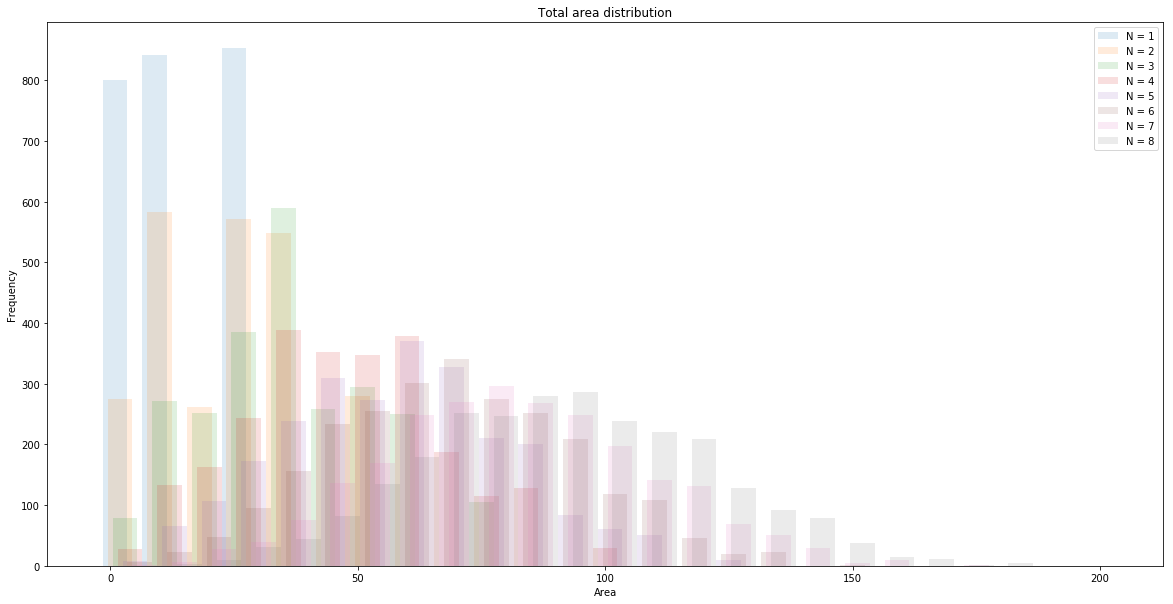

In [ ]:
#######################
## PLOT ACCURACY CURVE
######################
  import numpy as np
  import matplotlib
  import matplotlib.pyplot as plt

data=[]
for i in range(max_objects+1):
    data.append(areas[:,i])

plt.figure(figsize=(20,10))
matplotlib.get_backend()
width = area_chunk
for i in range(max_objects+1):
    if(i>0):
      plt.bar(np.arange(0,max_objects*25+1), orig_areas[:,i], width,alpha=0.15,label='N = ' + str(i))
      #plt.bar(np.arange(0,max_objects*25+1), data[i],width, alpha=0.50, bottom = np.sum(data[:i], axis = 0),label='N = ' + str(i))
      #pass
#plt.bar(np.arange(0,max_objects*25+1), orig_areas[:,3], width,alpha=0.15,label='N = 3', color='g')
#plt.bar(np.arange(0,max_objects*25+1), orig_areas[:,4], width,alpha=0.15,label='N = 4', color='b')
#plt.bar(np.arange(0,max_objects*25+1), areas[:,5], width,alpha=0.15,label='N = 5', bottom=areas[:,4])
#plt.bar(np.arange(0,max_objects*25+1), data[2],width, alpha=0.50, bottom = np.sum(data[:2], axis = 0),label='N = ' + str(i))

plt.ylabel('Frequency')
plt.xlabel('Area')
plt.legend(loc='upper right')
#plt.ylim(0,1)
titlestring = 'Total area distribution'
plt.title(titlestring)
#plt.savefig('Standard_NN.png')
#plt.plot([1,2,3], [1,1,1])
plt.show()


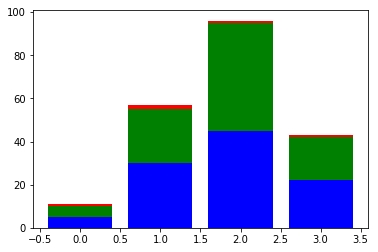

In [ ]:
import numpy as np
import matplotlib.pyplot as plt

data = np.array([[5., 30., 45., 22.],[5., 25., 50., 20.],[1.,  2.,  1.,  1.]])

color_list = ['b', 'g', 'r']

X = np.arange(data.shape[1])
for i in range(data.shape[0]):
  plt.bar(X, data[i],bottom = np.sum(data[:i], axis = 0),color = color_list[i % len(color_list)])

plt.show()

In [ ]:
## Probability for given total area A, that this stems from N objects

#print(areas[5,:])

print(areas[0:17,0:5])

def p_N_A(N,A):
    #Sum over one whole bar = sum over all Ns
    area_a = areas[A,:]
    sum_n_in_one_bar = np.sum(area_a)
    p_n_a = 0
    if(sum_n_in_one_bar>1e-8):
        p_n_a = areas[A,N]/sum_n_in_one_barc
    
    return p_n_a
    
print(  p_N_A(2,0) )
print(25/90)

print(len(areas[:,0]) )
    
def mean_weighted_p_N_A(N):
  
    #weighted sum of probabilities
    n_areas = len(areas[:,0])
    weighted_sum = 0
    for a in range(n_areas):
        all_n_of_single_N = areas[:,N]
        total_n_of_N_objects = np.sum(all_n_of_single_N)
        weighted_sum += p_N_A(N,a)*areas[a,N]/total_n_of_N_objects
    mean_weighted_sum = weighted_sum #/n_areas
    
    return mean_weighted_sum

for i in range(max_objects):
    print("mean_weighed_p_na: ", mean_weighted_p_N_A(i) )

[[  0. 800. 275.   0.   0.]
 [  0.   0.   0.   0.   0.]
 [  0.   0.   0.   0.   0.]
 [  0.   0.   0.   0.   0.]
 [  0.   0.   0.   0.   0.]
 [  0.   0.   0.  79.  28.]
 [  0.   0.   0.   0.   0.]
 [  0.   0.   0.   0.   0.]
 [  0.   0.   0.   0.   0.]
 [  0.   0.   0.   0.   0.]
 [  0. 841. 583. 271. 133.]
 [  0.   0.   0.   0.   0.]
 [  0.   0.   0.   0.   0.]
 [  0.   0.   0.   0.   0.]
 [  0.   0.   0.   0.   0.]
 [  0.   0.   0.   0.   0.]
 [  0.   0.   0.   0.   0.]]
0.2558139534883721
0.2777777777777778
201
mean_weighed_p_na:  nan
mean_weighed_p_na:  0.5518063474211965
mean_weighed_p_na:  0.3032240573955288
mean_weighed_p_na:  0.2639438643312231
mean_weighed_p_na:  0.25718864452773055
mean_weighed_p_na:  0.2698340697689116
mean_weighed_p_na:  0.2825358742249939
mean_weighed_p_na:  0.32474515143599847


/usr/local/lib/python3.6/dist-packages/ipykernel_launcher.py:27: RuntimeWarning: invalid value encountered in double_scalars


ValueError: ignored

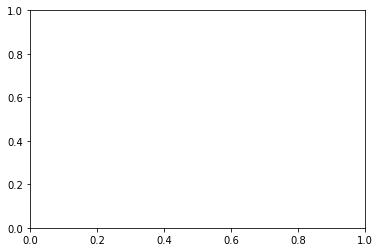

In [ ]:
fig = plt.figure()
ax = plt.subplot(111)
width = 8.0
for i in range(max_objects):
    if(i>0):
      ax.hist(np.arange(0,max_objects*25+1), areas[:,i], width,alpha=0.15,label='N = ' + str(i))
plt.title('Legend inside')
ax.legend(loc='upper center', bbox_to_anchor=(0.5, 1.00), shadow=True, ncol=2)

In [ ]:
def myround(x, base=5):
    for i in range(len(x)):
        x[i] = base * round(x[i]/base)
    return x

myround([12,13])

[10, 15]

In [ ]:
def myround_single(x, base=5):
    return base * round(x/base)
print(myround_single(2))

0


In [ ]:
#########################
## You can also upload files from your local drive 
## (for the case you it takes a lot of time to create the data and you do not want to create them in each runtime session again)
###############################################

from google.colab import files
uploaded = files.upload()
!pwd

import numpy as np
##### the file names in np.load (...) should be the same as it says in the output after you uploaded them: e.g. "Saving teX.npy to ....." --- ... is how you can access the data now
trX = np.load('trX (3).npy')
trY = np.load('trY (3).npy')
teX = np.load('teX (3).npy')
teY = np.load('teY (3).npy')

print(trY[0])
print(teY[0])


/content


FileNotFoundError: ignored

In [ ]:
##############################
## Create a directory 'logs' to save the results
###################################

import os
# Where to run code?: /content/logs
!pwd
!ls
!mkdir logs
os.chdir('/content/logs')
!ls

os.system('fuser 6006/tcp -k')
os.chdir('/content/')

############################### 
## or remove all logs you have done so far
################################
#!rm -rf *


/content
sample_data


In [ ]:
######################
## This is required to run tensorboard on Google Colab - Jupyter Notebook: 
##  This will create a link ending with ... .ngrok.io which you can open to get to tensorboard
#####################################


!wget https://bin.equinox.io/c/4VmDzA7iaHb/ngrok-stable-linux-amd64.zip
!unzip ngrok-stable-linux-amd64.zip

LOG_DIR = '/content/logs'
get_ipython().system_raw(
    'tensorboard --logdir {} --host 0.0.0.0 --port 6006 &'
    .format(LOG_DIR)
)
#--debugger_port 6064

get_ipython().system_raw('/content/ngrok http 6006 &')
! curl -s http://localhost:4040/api/tunnels | python3 -c \
    "import sys, json; print(json.load(sys.stdin)['tunnels'][0]['public_url'])"

--2020-02-13 10:48:47--  https://bin.equinox.io/c/4VmDzA7iaHb/ngrok-stable-linux-amd64.zip
Resolving bin.equinox.io (bin.equinox.io)... 52.45.70.48, 34.204.59.252, 34.206.126.139, ...
Connecting to bin.equinox.io (bin.equinox.io)|52.45.70.48|:443... connected.
HTTP request sent, awaiting response... 200 OK
Length: 13773305 (13M) [application/octet-stream]
Saving to: ‘ngrok-stable-linux-amd64.zip.1’

ngrok-stable-linux- 100%[===================>]  13.13M  14.4MB/s    in 0.9s    

2020-02-13 10:48:48 (14.4 MB/s) - ‘ngrok-stable-linux-amd64.zip.1’ saved [13773305/13773305]

Archive:  ngrok-stable-linux-amd64.zip
replace ngrok? [y]es, [n]o, [A]ll, [N]one, [r]ename: y
  inflating: ngrok                   
https://6c0e9fb9.ngrok.io


ValueError: ignored

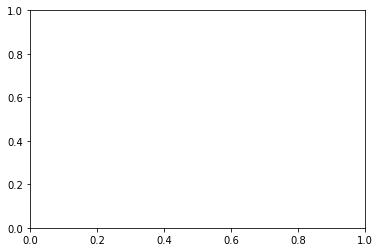

In [ ]:
import os
# Where to run code?: /content/logs
#!pwd
#os.chdir('/content')
#!pwd
#!mkdir /content/drive/My\ Drive/PyTorch_Models
#!ls
#os.chdir('/content/models/')
#os.chdir('/content/drive/My Drive/PyTorch_Models')
#!ls
#from google.colab import drive
#drive.mount('/content/drive')
#PATH = '/content/drive/My Drive/'




#######################
## PLOT ACCURACY CURVE
######################

matplotlib.get_backend()
plt.plot(np.arange(0,n_episodes), acc_arr)
plt.ylabel('Accuracy')
plt.xlabel('Episodes')
plt.ylim(0,1)
#titlestring = 'Accuracy during learning to count up to ' + str(trY[0].size) + ' object with a CNN'
titlestring = 'Accuracy during learning to count up to ' + "8" + ' object with a CNN'
plt.title(titlestring)
path_img = '/content/drive/My Drive/Tensorflow_NumEst/plots/comparison_turn_off_neurons'
#plt.plot([1,2,3], [1,1,1])
plt.legend()
plt.savefig(path_img, dpi = 1200)



plt.savefig('/content/drive/My Drive/Standard_NN.png')


Text(0.5, 1.0, 'Comparison between model accuracy and area based correlation ')

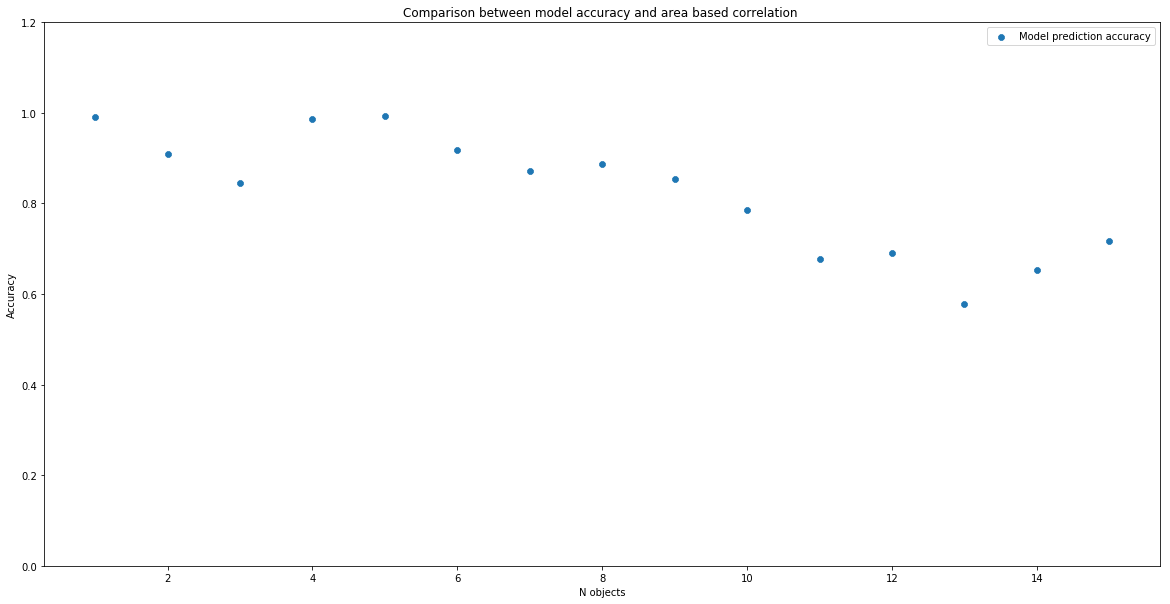

In [ ]:
#######################
## PLOT ACCURACY FOR EACH N + AREA BASED CLASSIFICATION
######################

#area_based_prob = []
#for i in range(max_objects+1):
#    area_based_prob.append( mean_weighted_p_N_A(i) )

    
plt.figure(figsize=(20,10))
matplotlib.get_backend()
plt.scatter(np.arange(1,max_objects+1), test_acc, label='Model prediction accuracy', marker="8")
#plt.scatter(np.arange(0,max_objects+1), area_based_prob, label='Area based classification',marker="8")
plt.ylabel('Accuracy')
plt.xlabel('N objects')
plt.ylim(0,1.2)
plt.legend(loc='upper right') 
titlestring = 'Comparison between model accuracy and area based correlation '
plt.title(titlestring)

In [ ]:







#######################################
## TRASH, meanwhile
########################################


# Initialize the embedding variable with the shape of our desired tensor
tensor_shape = (trX.shape[0] , fc1.get_shape()[1].value) # [test_set , h1] = [10000 , 200]
embedding_var = tf.Variable(tf.zeros(tensor_shape), 
                            name='fc1_embedding')
# assign the tensor that we want to visualize to the embedding variable
embedding_assign = embedding_var.assign(fc1) 

from tensorflow.contrib.tensorboard.plugins import projector

# Create a config object to write the configuration parameters
config = projector.ProjectorConfig()

# Add embedding variable
embedding = config.embeddings.add()
embedding.tensor_name = embedding_var.name

# Link this tensor to its metadata file (e.g. labels) -> we will create this file later
embedding.metadata_path = 'metadata.tsv'

# Specify where you find the sprite. -> we will create this image later
embedding.sprite.image_path = 'sprite_images.png'
embedding.sprite.single_image_dim.extend([img_w, img_h])

# Write a projector_config.pbtxt in the logs_path.
# TensorBoard will read this file during startup.
projector.visualize_embeddings(train_writer, config)







# Run session to evaluate the tensor
x_test_fc1 = sess.run(embedding_assign, feed_dict={x: x_test})

# Save the tensor in model.ckpt file
saver = tf.train.Saver()
saver.save(sess, os.path.join(logs_path, "model.ckpt"), global_step)



 '''
        #################################################################################
        # Load the test set
        x_test = teX
        y_test = teY

        fc1 = sess.run(fc1, feed_dict={X: teX.astype(np.float32), Y: teY.astype(np.float32),p_keep_input: 1.0, p_keep_hidden: 1.0,is_training: False, failed_object: 0,failed_object_string: "0"})

        # Initialize the embedding variable with the shape of our desired tensor
        tensor_shape = (x_test.shape[0] , fc1.shape[1]) # [test_set , h1] = [10000 , 200]
        embedding_var = tf.Variable(tf.zeros(tensor_shape), 
                                    name='fc1_embedding')
        # assign the tensor that we want to visualize to the embedding variable
        embedding_assign = embedding_var.assign(fc1) 



        

        # Create a config object to write the configuration parameters
        config = projector.ProjectorConfig()

        # Add embedding variable
        embedding = config.embeddings.add()
        embedding.tensor_name = embedding_var.name

        # Link this tensor to its metadata file (e.g. labels) -> we will create this file later
        embedding.metadata_path = 'metadata.tsv'

        # Specify where you find the sprite. -> we will create this image later
        embedding.sprite.image_path = 'sprite_images.png'
        embedding.sprite.single_image_dim.extend(trX[0].shape)   #[img_w, img_h]

        # Write a projector_config.pbtxt in the logs_path.
        # TensorBoard will read this file during startup.
        projector.visualize_embeddings(writer, config)



          
        
         # Run session to evaluate the tensor
        x_test_fc1 = sess.run(embedding_assign, feed_dict={x: x_test})

        # Save the tensor in model.ckpt file
        saver = tf.train.Saver()
        saver.save(sess, os.path.join(logs_path, "model.ckpt"), global_step)





        def write_sprite_image(filename, images):
          """
              Create a sprite image consisting of sample images
              :param filename: name of the file to save on disk
              :param shape: tensor of flattened images
          """

          # Invert grayscale image
          images = 1 - images

          # Calculate number of plot
          n_plots = int(np.ceil(np.sqrt(images.shape[0])))

          # Make the background of sprite image
          sprite_image = np.ones((img_h * n_plots, img_w * n_plots))

          for i in range(n_plots):
              for j in range(n_plots):
                  img_idx = i * n_plots + j
                  if img_idx < images.shape[0]:
                      img = images[img_idx]
                      sprite_image[i * img_h:(i + 1) * img_h,
                      j * img_w:(j + 1) * img_w] = img

          plt.imsave(filename, sprite_image, cmap='gray')
          print('Sprite image saved in {}'.format(filename))

        def write_metadata(filename, labels):
            """
                    Create a metadata file image consisting of sample indices and labels
                    :param filename: name of the file to save on disk
                    :param shape: tensor of labels
            """
            with open(filename, 'w') as f:
                f.write("Index\tLabel\n")
                for index, label in enumerate(labels):
                    f.write("{}\t{}\n".format(index, label))

            print('Metadata file saved in {}'.format(filename))







        # Reshape images from vector to matrix
        x_test_images = np.reshape(np.array(x_test), (-1, img_w, img_h))
        # Reshape labels from one-hot-encode to index
        x_test_labels = np.argmax(y_test, axis=1)

        write_sprite_image(os.path.join(logs_path, 'sprite_images.png'), x_test_images)
        write_metadata(os.path.join(logs_path, 'metadata.tsv'), x_test_labels)
    
    
        '''    
    
    
    
    
    

In [ ]:




class autoencoder(nn.Module):
    def __init__(self, img_size, c, h, h2 ):
        super().__init__()
        KERNEL_SIZE = 3
        PADDING = 1
        self.img_size = img_size
        self.representation_size = 40
        self.representation_size2 = self.representation_size
        
        self.h2 = h2
        self.h = h
 
        self.conv1 = nn.Conv2d(c, h, KERNEL_SIZE, padding=PADDING)
        self.conv2 = nn.Conv2d(h, h2, KERNEL_SIZE, padding=PADDING)
    
        self.fc1 = nn.Linear(h2*img_size*img_size, self.representation_size)
        self.fc2 = nn.Linear(self.representation_size, self.representation_size2)
        
        self.fc3 = nn.Linear(self.representation_size2, self.representation_size)
        self.fc4 = nn.Linear(self.representation_size, img_size*img_size)
        self.deconv = nn.ConvTranspose2d(1, h2, 5, stride=1, padding=2)
        self.deconv2 = nn.ConvTranspose2d(h2, 1, 5, stride=1, padding=2)
        #self.n_actions = n_actions
        #self.fc1 = nn.Linear(200*200, n_actions)
        #self.pool = torch.nn.MaxPool2d(kernel_size=2, stride=2, padding=0)
        

        

    def forward(self, x):

        repres = self.encoder(x)
        decoded = self.decoder(repres)

        return decoded, repres
      

    def encoder(self, x):
        conv1 =self.conv1(x)
        conv1 = f.relu(conv1)
        conv2 = self.conv2(conv1)
        conv2 = f.relu(conv2)

        
        conv2_flatten = conv2.view(-1,self.h2*img_size*img_size)

        fc1 = f.relu( self.fc1(conv2_flatten) )
        fc2 = f.relu( self.fc2(fc1) )
        
        #x = x.view(-1,self.img_size*self.img_size)
        #fc1 = f.relu( self.fc1(x) )
        #fc2 = f.relu( self.fc2(fc1) )
        
        return fc2   

      
    def decoder(self, x):

        fc3 = f.relu( self.fc3(x) )
        fc4 = f.relu( self.fc4(x) )
        fc4 = fc4.view(-1, self.img_size,self.img_size)
        
        
        fc4_2d = fc4.reshape(-1,1,self.img_size,self.img_size)
        deconv = f.relu( self.deconv(fc4_2d) )
        #deconv = f.relu( self.deconv(deconv) )
        deconv =  self.deconv2(deconv) 
        
        
        
        #print("deconv.size(): ", deconv.size())
        
        return deconv  
      
      
img_siz = 20
model = autoencoder(img_siz,1, 4, 4)      

In [ ]:
################################
## With stride
###############################

class autoencoder(nn.Module):
    def __init__(self, img_size, c, h, h2 ):
        super().__init__()
        KERNEL_SIZE = 3
        PADDING = 1
        self.img_size = img_size
        self.representation_size = 40
        self.representation_size2 = self.representation_size
        
        self.h2 = h2
        self.h = h
 
        self.conv1 = nn.Conv2d(c, h, KERNEL_SIZE, padding=PADDING,stride=2)
        self.conv2 = nn.Conv2d(h, h2, KERNEL_SIZE, padding=PADDING,stride=2)
    
        self.fc1 = nn.Linear(h2*img_size*img_size, self.representation_size)
        self.fc2 = nn.Linear(self.representation_size, self.representation_size2)
        
        self.fc3 = nn.Linear(self.representation_size2, self.representation_size)
        self.fc4 = nn.Linear(self.representation_size, img_size*img_size)
        self.deconv = nn.ConvTranspose2d(h2, h2, 3, stride=2, padding=1)
        self.deconv2 = nn.ConvTranspose2d(h2, 1, 3, stride=2, padding=1)
        #self.n_actions = n_actions
        #self.fc1 = nn.Linear(200*200, n_actions)
        #self.pool = torch.nn.MaxPool2d(kernel_size=2, stride=2, padding=0)
        

        

    def forward(self, x):

        repres = self.encoder(x)
        decoded = self.decoder(repres)

        return decoded, repres
      

    def encoder(self, x):
        conv1 =self.conv1(x)
        conv1 = f.relu(conv1)
        conv2 = self.conv2(conv1)
        conv2 = f.relu(conv2)

        
        #conv2_flatten = conv2.view(-1,self.h2*img_size*img_size)

        #fc1 = f.relu( self.fc1(conv2_flatten) )
        #fc2 = f.relu( self.fc2(fc1) )
        
        #x = x.view(-1,self.img_size*self.img_size)
        #fc1 = f.relu( self.fc1(x) )
        #fc2 = f.relu( self.fc2(fc1) )
        
        return conv2

      
    def decoder(self, x):

        #fc3 = f.relu( self.fc3(x) )
        #fc4 = f.relu( self.fc4(x) )
        #fc4 = fc4.view(-1, self.img_size,self.img_size)
        
        #print("x.size(): ", x.size() )
        #fc4_2d = fc4.reshape(-1,1,self.img_size,self.img_size)
        deconv = f.relu( self.deconv(x) )
        #print("deconv.size(): ", deconv.size() )
        #deconv = f.relu( self.deconv(deconv) )
        deconv =  self.deconv2(deconv) 
        #print("deconv2.size(): ", deconv.size() )
        
        
        
        #print("deconv.size(): ", deconv.size())
        
        return deconv  
      
      
img_siz = 20
model = autoencoder(img_siz,1, 8, 8)      

In [ ]:
model_copy = (model.parameters())

In [ ]:
model.load_state_dict( model_copy )

AttributeError: ignored

In [ ]:
### From https://github.com/L1aoXingyu/pytorch-beginner/blob/master/08-AutoEncoder/conv_autoencoder.py

__author__ = 'SherlockLiao'

import torch
import torchvision
from torch import nn
from torch.autograd import Variable
from torch.utils.data import DataLoader
from torchvision import transforms
from torchvision.utils import save_image
from torchvision.datasets import MNIST
import os
import torch
import torch.nn.functional as f




def to_img(x):
    x = 0.5 * (x + 1)
    x = x.clamp(0, 1)
    x = x.view(x.size(0), 1, 28, 28)
    return x


num_epochs = 100
batch_size = 128
learning_rate = 1e-2

img_transform = transforms.Compose([
    transforms.ToTensor(),
    transforms.Normalize((0.5, 0.5, 0.5), (0.5, 0.5, 0.5))
])

#dataset = MNIST('./data', transform=img_transform, download = True)
#dataloader = DataLoader(dataset, batch_size=batch_size, shuffle=True)










criterion = nn.MSELoss()
optimizer = torch.optim.Adam(model.parameters(), lr=learning_rate)





torch.manual_seed(0)
N = 1000

loss_fn = nn.MSELoss()



for n in range(0, N):
  
    n_batch = 16
    mult_img, mult_class,areas, orig_areas = Create_N_Images(n_batch-1, only_one_number=True, n_squares=3)
    
    mult_img = np.asarray(mult_img) 
    #print("mult_img.shape(): ", mult_img.shape )
    
    img_original = torch.from_numpy( mult_img ).reshape(n_batch, 1, img_size, img_size).float()/255.
    #print(img_original.size() )

    image, _ = model(img_original)
    loss = loss_fn(image, img_original)
    
    #print("image.size(): ", image.size() )
    #print(img_original.size( ))

    # zero grad parameters
    model.zero_grad()

    # compute new grad parameters through time!
    loss.backward()
    optimizer.step()
    
    if(n%100 == 0):
      print(' > Iteration {:2d} loss: {:.3f}'.format((n+1), loss.data) )
      







'''
for epoch in range(num_epochs):
    for data in dataloader:
        img, _ = data
        img = Variable(img).cuda()
        # ===================forward=====================
        output = model(img)
        loss = criterion(output, img)
        # ===================backward====================
        optimizer.zero_grad()
        loss.backward()
        optimizer.step()
    # ===================log========================
    print('epoch [{}/{}], loss:{:.4f}'
          .format(epoch+1, num_epochs, loss.data[0]))
    if epoch % 10 == 0:
        pic = to_img(output.cpu().data)
        save_image(pic, './dc_img/image_{}.png'.format(epoch))

torch.save(model.state_dict(), './conv_autoencoder.pth')
'''

NameError: ignored

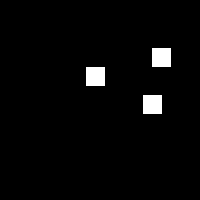

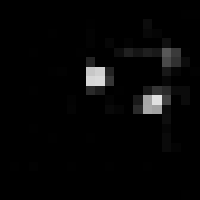

repres:  tensor([[[[1.1331, 1.2474, 1.2474, 1.2474, 1.2474, 1.2359],
          [1.2543, 1.2839, 1.2298, 1.4028, 2.5884, 1.0762],
          [1.2543, 1.2839, 1.6519, 0.6605, 0.9235, 1.4313],
          [1.2543, 1.2839, 1.2839, 1.3098, 1.3210, 1.2909],
          [1.2543, 1.2839, 1.2839, 1.2839, 1.2839, 1.2909],
          [1.1774, 1.2794, 1.2794, 1.2794, 1.2794, 1.2582]],

         [[0.4405, 0.4466, 0.4466, 0.4466, 0.4466, 0.4367],
          [0.4550, 0.4618, 0.3095, 0.7665, 2.0705, 0.2872],
          [0.4550, 0.4618, 1.6634, 0.5392, 0.0000, 0.4634],
          [0.4550, 0.4618, 0.4618, 0.3586, 0.0000, 0.4577],
          [0.4550, 0.4618, 0.4618, 0.4618, 0.4618, 0.4577],
          [0.4292, 0.4668, 0.4668, 0.4668, 0.4668, 0.4651]],

         [[0.0000, 0.0000, 0.0000, 0.0000, 0.0000, 0.0000],
          [0.0045, 0.0321, 0.0903, 0.1016, 0.0000, 0.0000],
          [0.0045, 0.0321, 3.0530, 0.6875, 0.0000, 0.0000],
          [0.0045, 0.0321, 0.0321, 0.0000, 0.0000, 0.0000],
          [0.0045, 0.0321, 

In [ ]:
##########################
## TEST AUTOENCODER
####################



#### Create image you want to reproduce
mult_img, mult_class,areas, orig_areas = Create_N_Images(1, only_one_number=True, n_squares=3)
img_np = mult_img[0, :]
img = Image.fromarray(np.reshape(img_np, (img_size,img_size)))  # Create a PIL image
img.show()  # View in default viewer
img = img.resize((200,200))
display(img)

     
img_original = torch.from_numpy( img_np).reshape(1, 1, img_size, img_size).float()/255.
image, repres = model(img_original)

img = Image.fromarray(np.reshape(image.detach().numpy()*255, (img_size,img_size)) ).convert('RGB')  # Create a PIL image
img.show()  # View in default viewer
img = img.resize((200,200))
display(img)

print("repres: ", repres)


In [ ]:
def Create_N_Images(n_images, only_one_number=False, n_squares=5):

    areas = np.zeros((max_objects*25+1, max_objects+1))
    orig_areas = np.zeros((max_objects*25+1, max_objects+1))
  
    n_objects = random.randint(1, max_objects)
    if (only_one_number):
        n_objects = n_squares

    mult_img, mult_class, total_area, orig_area = Create_N_Sqaures(n_objects)
    for i in range(n_images):
        n_objects = random.randint(1, max_objects)
        if (only_one_number):
            n_objects = n_squares

        data_flatten, n_obj_one_hot, total_area, orig_area = Create_N_Sqaures(n_objects)
        mult_img = np.vstack([mult_img, data_flatten])
        mult_class = np.vstack((mult_class, n_obj_one_hot))
        areas[total_area][n_objects]+=1
        orig_areas[orig_area][n_objects]+=1

    return mult_img, mult_class, areas, orig_areas




# Prepare Training data
mult_img, mult_class,areas, orig_areas = Create_N_Images(8000, only_one_number=True, n_squares=1)  # original 20000!!!!!
trX = mult_img